### To Do 

* run for 10 years

1. Graph sentiment per day / month 

https://medium.com/analytics-vidhya/utilizing-twint-and-textblob-for-scraping-and-sentimenet-analysis-of-caucasianjamess-tweets-c1c548f52bbb

2. Check textblob - can I improve the sentiment score

3. Add Nedbank and Investec!! 

4. get customer satisfaction index (CSI) numbers - do they correlate to the Twitter sentiment 

# Project: Bank Sentiment Analysis 

## Summary 
Compare customer sentiment of the top 4 Banks in South Africa via rolling twitter sentiment scores 
Identify the banks with the most satisfied customer base
Compare results to the Customer Satifaction Index (CSI) and determine if the CSI is a correct reflection of the consumer sentiment

-> Twitter sentiment is derived by sentiment analysis of bank tweets
-> CSI is obtained by ____

### Operations
#### Twitter data
Twint to scrape tweets of the top 4 banks in South Africa \
Clean tweets with WordPunctTokenizer and Regex \
TextBlog to process sentiment of tweets 
Matplotlib / Seaborn to visualise data 

### Project 2:
Bank outages play a large factor in the customer sentiment and overall customer satisfaction 

use:https://downdetector.co.za/

## Twint quick guide

https://github.com/Slyth3/Twitter_NLP/blob/main/Quick%20Twint%20Code.txt


In [1]:
import twint
import pandas as pd
import nest_asyncio
nest_asyncio.apply()            #for compatibility issues with twint
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
import numpy as np
import datetime as dt
import seaborn as sns

#cleaning
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords             #check this compared to world cloud 

# NLP
from textblob import TextBlob

#word cloud and stopwords
from wordcloud import WordCloud, STOPWORDS

### Configure and run Twint (twitter scrapper)

In [2]:
def twintConfig(date_from,search_string):    
    c = twint.Config()
    c.Search = search_string
    c.Pandas = True
    
    #english only
    c.Lang = "en"
    c.Since = date_from
    
    #c.Until = "2021-07-30"
    twint.run.Search(c)
    
#stdBankString = "StandardBankZA OR \"Standard Bank\""
#FNB_String = "FNBSA"

### Run twint

In [3]:
bank_search = {"FNB":"FNBSA", "StandardBank":"StandardBankZA OR \"Standard Bank\" OR \"standard bank\"","Nedbank":"Nedbank OR nedbank","ABSA": "Absa OR ABSA OR absa OR AbsaSouthAfrica"}
since = "2021-09-01"

def Run_Twint(search_vals):
    
    #set empty dataframe
    Final_df= pd.DataFrame()
    
    for bank in search_vals.items():
        print ("running: "+bank[0]+"\n")
        
        #run twint
        twintConfig(since,bank[1])
        
        #get dataframe
        tweets_df = twint.storage.panda.Tweets_df
        
        #join Dataframes and create Bank name column
        tweets_df["Bank"]= bank[0]
        Final_df = pd.concat([Final_df,tweets_df])
    return Final_df

In [16]:
tweets_df = Run_Twint(bank_search)

running: FNB

1435637598416932872 2021-09-08 18:14:10 +0200 <AnushaGovende13> @FNBSA FNB Easy Account is way convenient for me. I can send and receive money, pay accounts, swipe, can access ewallets and apply for instant loans. No queues.. No hassles thanks to @FNBSA I love @FNBSA
1435636995905232897 2021-09-08 18:11:47 +0200 <Iam_Timbanesam> @CapitecBankSA Fees are starting go swana letsa @FNBSA too much now 😒 July R136.90 and is August R139.70  https://t.co/fV4fro1uLg
1435635515106250766 2021-09-08 18:05:54 +0200 <TrishaNaidoo14> @FNBSA FNB Easy Zero makes life so much more convenient #LoveFNB
1435635270976684037 2021-09-08 18:04:56 +0200 <VarsityDiski> Final game of the opening round and expect fireworks! Defending champs @nwusports1 take on the @UJ_Sport  orange army!   Watch it live on @SuperSportTV 205 or follow updates on the Varsity Sports APP  https://t.co/3r0FdnXheI.   #VarsityDiski proudly brought to you by @FNBSA  https://t.co/lRAnI1nh8K
1435634608557772801 2021-09-08 18:02

1435607429153185797 2021-09-08 16:14:18 +0200 <Anastac95986960> @FNBSA FNB Easy Zero ❤️ #LoveFNB
1435607179038543874 2021-09-08 16:13:18 +0200 <Spenza_Rapati> Ba eja bale ba 1 promo ya @FNBSA our South African celebrities  https://t.co/QGxoLUBa45
1435606513524088835 2021-09-08 16:10:39 +0200 <Amukelwa17> @FNBSA Fnb premier cheque account.I can yonke into at the app zonke  https://t.co/fyN8Z80UFj save time and stress free.#LoveFNB
1435606468347244558 2021-09-08 16:10:28 +0200 <mikzofficial> @FNBSA FNB EAZY ZERO #LoveFNB 😍😍😍 No worries about crazy bank charges or transactional charges and that means More money to save
1435606083490435073 2021-09-08 16:08:57 +0200 <Buccwe_Mvuleni> Thank you @FNBSA I got my @Clicks_SA voucher  I'm so excited rn  https://t.co/v0V0bkj3lS
1435604889590194178 2021-09-08 16:04:12 +0200 <thembeka_lov465> @FNBSA How do I get My Easy Zero Banking Card? Happy times 💃free and no charges for using the Card, it finally reached the good target, which is me😍. Can it be 

1435585328992165888 2021-09-08 14:46:28 +0200 <Khanya63339852> @FNBSA #LoveFNB  Fnb Easy Zero acc
1435585280212361218 2021-09-08 14:46:17 +0200 <1BadOu> @FNBSA I have my FNB Aspire Current and I enjoy my fee savings and benefits for convenience stress free #LoveFNB
1435585198163468291 2021-09-08 14:45:57 +0200 <Gogo86635029> @FNBSA @LiftAirlineSA @mrdfood #LoveFNB
1435585184204738561 2021-09-08 14:45:54 +0200 <Phumudzo_Rams> @FNBSA I was assisted by Arinao Ramashia @fnbthavhani. She went all out to give me the best service. Very friendly person, and she assisted me with a smile through out. I'm glad I went to Thavhani mall branch.
1435584874241527810 2021-09-08 14:44:40 +0200 <Gogo86635029> @FNBSA FNB easy account #LoveFNB
1435584837272940552 2021-09-08 14:44:31 +0200 <Iamtiaantjie> @FNBSA @LiftAirlineSA @mrdfood #LoveFNB    Great 👏
1435584481776349190 2021-09-08 14:43:06 +0200 <Cassereen1> @FNBSA Yay thank you so much will do that now!!!❤❤❤
1435584416269615109 2021-09-08 14:42:51 +020

1435576296420089856 2021-09-08 14:10:35 +0200 <NgemaNkosinathi> @FNBSA I'm using FNB Easy Account and I also have the smart app... life is so easy now I simply make bill payments on the App without leaving home 😎 #LoveFNB
1435576286160818182 2021-09-08 14:10:32 +0200 <xilavi> @karabo80630538 @TerryPheto @FNBSA I have an open ended case with fnb via this Rbjacobs, ended up moving my banking to nedbank because wooow. Fnb is for tweeter not for banking
1435575856655634435 2021-09-08 14:08:50 +0200 <ItsLeethar> @FNBSA Done 👌🏽 I’m so happy🥺🙌🏽
1435575751919742977 2021-09-08 14:08:25 +0200 <Lesego93298467> @Tshego_13 @FNBSA Did they take your phone number and email?
1435575428694020098 2021-09-08 14:07:08 +0200 <Naomi48083883> @FNBSA FNB Easy .....makes my life simple and stress free. #LoveFNB
1435575388835655680 2021-09-08 14:06:59 +0200 <wymsoc> @TerryPheto @FNBSA Please don’t…advertisements are so tiring!!!
1435575379981488131 2021-09-08 14:06:56 +0200 <TlaleTlhogi> @FNBSA @SuperSportTV #L

1435566199459520520 2021-09-08 13:30:28 +0200 <mak21345> @FNBSA Fnb easy account makes it easy for me, I always pay my dstv monthly subscription with my banking app. #LoveFNB
1435565750920613893 2021-09-08 13:28:41 +0200 <fasbrant> @SeanGoss31 @StandardBankZA @FNBSA @AbsaSouthAfrica @Nedbank If a fact
1435565569001107459 2021-09-08 13:27:57 +0200 <IzelleBrand> @FNBSA #LoveFNB
1435565422577868803 2021-09-08 13:27:22 +0200 <thisistwitch08> @FNBSA  https://t.co/RmIuyuebOP
1435564990153564162 2021-09-08 13:25:39 +0200 <RushanaMeyer> @FNBSA Fnb easy account #LoveFNB
1435564230531559425 2021-09-08 13:22:38 +0200 <CarolineMasheg5> @FNBSA I have FNB Easy Account which helps me alot with saving my money #LoveFNB
1435563733502332928 2021-09-08 13:20:40 +0200 <tatkayodidi> @TerryPheto @FNBSA You Madam, are one of SA women that that puff my chest up with pride, Thuli, Redi, Phumzile Ngcuka, Lindiwe Mazibuko and others. You are our shining lights. God bless you all
1435563232740118528 2021-09-08 13

1435549474361860106 2021-09-08 12:24:00 +0200 <HappinessMart11> @FNBSA Fnb savings account do wonders 💙👌😍🤸‍♀️ #LoveFNB
1435549465377746949 2021-09-08 12:23:58 +0200 <oraclerob_za> @TerryPheto @FNBSA But isn't fnb giving black people higher interest rates?
1435549409308196867 2021-09-08 12:23:45 +0200 <Beauty19439923> @FNBSA FNB Savings account..I can make fast payments too my family or transfer money #LoveFNB
1435549101777690628 2021-09-08 12:22:31 +0200 <lucha_1979> @FNBSA FNB Savings Account #LoveFNB
1435548877000781825 2021-09-08 12:21:38 +0200 <AA58953181> @FNBSA FNB Easy Zero account..It helps me too make fast payments and swipe at my favorite supermarket #LoveFNB
1435548648633470976 2021-09-08 12:20:43 +0200 <Daniel07gmail> @FNBSA FNB Easy Account... I'm freed #LoveFNB
1435548468794339330 2021-09-08 12:20:00 +0200 <Nthabisengmg24> @FNBSA #LoveFNB
1435548402935291912 2021-09-08 12:19:45 +0200 <Car58396052> @FNBSA The FNB Aspire account works wonders for me i never experienced any 

1435532650345869314 2021-09-08 11:17:09 +0200 <Noleen13733217> @FNBSA FNB Easy Zero Account Makes my Life  as A  Mom Very Easy and Cofient, leaving me with No Bank fees and no Hassle  #LoveFNB
1435532558079561728 2021-09-08 11:16:47 +0200 <Nkosi4603478> @FNBSA FNB Easy Zero account is the only account help me to save even more, and make payment very easy because I don't like queuing at the branch to make payment, I just use my FNB app to make all my payment very easily and I save even more  #LoveFNB
1435532472528384002 2021-09-08 11:16:27 +0200 <Sefularo_Keamo> @FNBSA The new Aspire Debit, love it because I can save on bank charges and still enjoy the full benefits of a cheque account #LoveFNB
1435532429327011840 2021-09-08 11:16:16 +0200 <Kirsty94k> @FNBSA FNB Easy Account
1435532127022592006 2021-09-08 11:15:04 +0200 <NehemiaAnderso1> I have an Easy Account  💳 #LoveFNB @FNBSA
1435532092377640967 2021-09-08 11:14:56 +0200 <NehemiaAnderso1> @FNBSA I have an Easy Account  💳 #LoveFNB @FN

1435523027760988160 2021-09-08 10:38:55 +0200 <Preciou27417218> @FNBSA FNB Easy Zero Account  #LoveFNB
1435523004272939010 2021-09-08 10:38:49 +0200 <PearlNd13098790> @FNBSA The FNB easy acount has helped me save my money. Its such an affordable option #LoveFNB
1435522987885748228 2021-09-08 10:38:45 +0200 <Zukie60425347> @FNBSA #LoveFNB FNB Easy Account
1435522785665818626 2021-09-08 10:37:57 +0200 <constancenell1> @FNBSA #LoveFNB
1435522735732674560 2021-09-08 10:37:45 +0200 <Lesego93298467> I'm learning about #MoneyCoach using nav» Money on the @FNBSA App. What would you like to learn about? 𝗧𝗔𝗣 𝗕𝗘𝗟𝗢𝗪 👇 to get money smart &amp; you could 𝗪𝗜𝗡 gift vouchers up to the value of R3,000 #LoveFNB
1435522706531921923 2021-09-08 10:37:38 +0200 <RamaRochi> @FNBSA FNB Easy account, I'm stress free and loving using FNB  #LoveFNB
1435522531918819329 2021-09-08 10:36:56 +0200 <kim_plaatj> @FNBSA #LoveFNB I have a Aspire account, as well as a bank your change account. Helps me to save
143552244787

1435516932057350144 2021-09-08 10:14:41 +0200 <Dur8anPoison> Does anyone know if we still earn eBucks while using the new @FNBSA ApplePay as its linked to the same credit card? I hope so! @Rbjacobs ?
1435516931927416832 2021-09-08 10:14:41 +0200 <dyangumuni> @FNBSA Easy Account #LoveFNB
1435516905230684170 2021-09-08 10:14:35 +0200 <Mogale17499424> @FNBSA FNB Easy Zero account. I find it wow👌 #LoveFNB
1435516877200105474 2021-09-08 10:14:28 +0200 <SuzanLovedonia> @FNBSA With Easy Zero FNB Account  I bank stress free because it doesn't have monthly account fees. #LoveFNB
1435516793536368642 2021-09-08 10:14:08 +0200 <yamkelampini> @FNBSA #LoveFNB   FNB Easy Account
1435516734170091525 2021-09-08 10:13:54 +0200 <ComforterThrow> @FNBSA FNB easy account I get wellness benefits as well as free card swipes the list is endless #LoveFNB
1435516615286824960 2021-09-08 10:13:26 +0200 <barelyDevon> @FNBSA #LoveFNB FNBy account helping me bank stress free
1435516598727684098 2021-09-08 10:13:22 +0

1435510321456820225 2021-09-08 09:48:25 +0200 <Yingwani8> @FNBSA Easy Zero account is best. #LoveFNB
1435510216783798275 2021-09-08 09:48:00 +0200 <dammertkay> @FNBSA As a stay at home daughter and a struggling student, my FNB transact account is looking a lot like the Sahara. But I can always count on that savings account of mine👌🏼 #LoveFNB
1435510101016727553 2021-09-08 09:47:33 +0200 <ChowderNkosi> @Rbjacobs @FNBSA hi, how do e bucks work and how do i get them activated on my account?
1435510073690894340 2021-09-08 09:47:26 +0200 <Matsena18> @FNBSA FNB Easy Zero account make banking easy and smart free. #LoveFNB
1435509927167107072 2021-09-08 09:46:51 +0200 <Evidenc54006875> @FNBSA #LoveFNB 😎😎😎❤
1435509844350578694 2021-09-08 09:46:32 +0200 <Evidenc54006875> @FNBSA @FNBSA  easy zero account  is has made my life more easier for almost years now i love it its simple  and easy to use #LoveFNB ❤❤❤❤❤💃💃💃😎😎😎😎
1435509716462018562 2021-09-08 09:46:01 +0200 <Nxalati75776129> @FNBSA #LoveFNB F

1435503528492085254 2021-09-08 09:21:26 +0200 <Paula15817005> @FNBSA #LoveFnb Easy zero minis one problem thanx.
1435503453627895808 2021-09-08 09:21:08 +0200 <Washu09016350> @FNBSA @FNBSA  Easy Zero Account Banking made easy and stress free ❤️ #LoveFNB
1435503373869096970 2021-09-08 09:20:49 +0200 <shibu_siya> @FNBSA FNB Easy Zero Account  #LoveFNB
1435503189483261955 2021-09-08 09:20:05 +0200 <ElegantZinhle> @FNBSA #LoveFNB FNB Aspire Current Account, its flexible with multi features to do ewallets, cardless banking, Pay recipients and beneficiaries monthly , Debit orders monitoring all in the App. Its cost effive saves time i don't have to do my stuff at the branch! My FNB app is my bank😃
1435503176753598468 2021-09-08 09:20:02 +0200 <lizzy_930> @FNBSA FNB Easy Zero Account #LoveFNB
1435503133191442434 2021-09-08 09:19:51 +0200 <Notoriouspoi> @FNBSA FNB Easy Zero Account. I make Data and airtime purchases at no extra cost. This account can help you avoid fees when you need to top up

1435499339913338884 2021-09-08 09:04:47 +0200 <Lyndacomps> @FNBSA FNB Easy #LoveFNB
1435499328634859523 2021-09-08 09:04:44 +0200 <MphahleleRanny> @FNBSA @f_shogs @KeitumetseMmbe1
1435499258657054722 2021-09-08 09:04:28 +0200 <MphahleleRanny> @FNBSA It is the FNB easy account for me😍😊🥂 #LoveFNB   🕯  for me to be a winner 🥺🥺🥺been trying since day one 🥺
1435499235424735232 2021-09-08 09:04:22 +0200 <vonganinkuna2> @FNBSA I withdraw at Usave while shopping,it's so helpful #LoveFNB
1435499215803793408 2021-09-08 09:04:17 +0200 <LondieZehm> @FNBSA FNB Easy Zero account #LoveFNB
1435499198879784961 2021-09-08 09:04:13 +0200 <Tht891> @FNBSA #LoveFnb Fnb easy account is reliving my stress levels and saving me time and money. Time lost is money lost in my business
1435499164897529857 2021-09-08 09:04:05 +0200 <malili29445698> @FNBSA #LoveFNB
1435499086808035332 2021-09-08 09:03:47 +0200 <Notoriouspoi> @FNBSA FNB Easy Zero Account #LoveFNB
1435499062380335107 2021-09-08 09:03:41 +0200 <fazbucks>

1435472928028626944 2021-09-08 07:19:50 +0200 <SESHSA> @FNBSA #LoveFNB I save by shopping at retailers that I can earn ebucks.. In doing that I save by gaining ebucks which I use for thing I won't normally afford cash for. @mikzofficial
1435471995412561923 2021-09-08 07:16:08 +0200 <MmaBana_> @Sakhile63755762 @sylvesterchauke @Lfc_Za_ @TerryPheto @FNBSA Acting is not the only thing.. Producing Directing etc.. 🤷🏽‍♀️
1435471854815285254 2021-09-08 07:15:34 +0200 <thembamabala> @NoziphoPatosi @chgzsa @Babo_Melthaf @Karabo_Mokgoko @Nedbank @FNBSA @homeaffairsZA I lost my ID, how much is temporary and e expire after nako e kae?
1435470552140025860 2021-09-08 07:10:24 +0200 <Sakhile63755762> @Thando_Fosgate @sylvesterchauke @Lfc_Za_ @TerryPheto @FNBSA Hhay wena!! 😀😅😀
1435469932423225345 2021-09-08 07:07:56 +0200 <Itumelengpagea3> @TerryPheto @FNBSA Which films sis?
1435467999478222852 2021-09-08 07:00:15 +0200 <IamMalusiMsomi> @TerryPheto @FNBSA Aw no disrespect but ngakugcina kwi Bold n Bea

1435350182309335045 2021-09-07 23:12:05 +0200 <Nkoesheng> @TerryPheto @lungstar_Msane @karabo80630538 @FNBSA All banks do this...anyway. One of the reasons I bank with fnb is because of the number of atm's available.
1435348740693536769 2021-09-07 23:06:21 +0200 <ladyveerh> @TerryPheto @FNBSA 🤣🤣🤣
1435344434825240590 2021-09-07 22:49:15 +0200 <siv_k> @FNBSA I always try to draw cash at the till in the morning around 8 without success. There’s always unavailability of cash at that time
1435342166851788800 2021-09-07 22:40:14 +0200 <OFFICIALMO23> @TerryPheto @FNBSA Kahle wena
1435341819928367113 2021-09-07 22:38:51 +0200 <Chakalisto> Somebody, Someone,  HELP🙏 #KeaDrive #KeaGiveaways #uMjoloWithAzola #MrAirtime #BetterTogether #HealthHubOn405 @HermaieneM @MrHandsomeSA @big_guy_015 @Cellular__ZA @Cellulite_ZA @MTNza @AngloAmerican @LesediFM @Vodacom @FNBSA @Nedbank @Shoprite_SA @PicknPay @Boity @casspernyovest
1435341203650777096 2021-09-07 22:36:24 +0200 <ThaStiffler> @TerryPheto @FNBSA  h

1435311442476011523 2021-09-07 20:38:09 +0200 <Vinesh30310581> @FNBSA @SuperSportTV #varsityfootball #LoveFNB #Iyachesa
1435310978808393728 2021-09-07 20:36:18 +0200 <YourCoffee_girl> @Karabo_Mokgoko @chgzsa @Nedbank @FNBSA I replaced my lost ID smart card at investec Bank, I don't bank with them.
1435310377693220864 2021-09-07 20:33:55 +0200 <TiisetsoThato> @TemoshoSekgala @TerryPheto @Gabriel34353726 @FNBSA Leeseng
1435310305274470412 2021-09-07 20:33:38 +0200 <ItsLeethar> @FNBSA So convenient for me, Whenever I’m in town and scared to withdraw at the ATM’s in town, because of robbery &amp; fraudulent there, I always go 2 pickNpay or checkers to do cash backs &amp; I’m so happy this option was introduced to us.  #LoveFNB
1435310181701783553 2021-09-07 20:33:08 +0200 <Karabo_Mokgoko> @chgzsa @Nedbank @FNBSA Can I make lost iD from there?
1435309380635869189 2021-09-07 20:29:57 +0200 <TomMischsWife> Why isn’t @FNBSA accepting passport applications?🥲
1435309196824743942 2021-09-07 20:29

1435265791939731473 2021-09-07 17:36:45 +0200 <nhlapo_jomo> @FNBSA Always get cash at Pick&amp;Pay store #LoveFNB
1435265061703016454 2021-09-07 17:33:51 +0200 <pixelsmith__> @FNBSA Problem No.#3   Once we’ve forgotten these RIDICULOUS usernames/passwords, after going through all the admin of changing our password, you still want us to confirm our details SPECIFICALLY on the device we forgot it on even if we’re using another device to retrieve our pin
1435264678591074306 2021-09-07 17:32:19 +0200 <Dilshaa66187126> @FNBSA #LoveFNB
1435264632923508736 2021-09-07 17:32:09 +0200 <Dilshaa66187126> @FNBSA #LoveFNB
1435264550811668491 2021-09-07 17:31:49 +0200 <TemoshoSekgala> @TerryPheto @Gabriel34353726 @FNBSA Sesi Terry makip'kip ateng ko US kante??
1435264531652096001 2021-09-07 17:31:44 +0200 <Dilshaa66187126> @FNBSA #LoveFNB
1435264130739548163 2021-09-07 17:30:09 +0200 <pixelsmith__> @FNBSA  Problem No.#2  Retrieving the forgotten username/password, is a damn obstacle and a half, CHANG

1435241095500271621 2021-09-07 15:58:37 +0200 <d_molahlehi> @FNBSA #LoveFNB
1435241049266475008 2021-09-07 15:58:26 +0200 <d_molahlehi> @FNBSA @ArabileG #LoveFNB
1435240984212905989 2021-09-07 15:58:10 +0200 <d_molahlehi> @FNBSA #LoveFNB awesome
1435240896874885122 2021-09-07 15:57:49 +0200 <d_molahlehi> @FNBSA #LoveFNB
1435240838905438218 2021-09-07 15:57:36 +0200 <d_molahlehi> @FNBSA #LoveFNB
1435240774560587781 2021-09-07 15:57:20 +0200 <d_molahlehi> @FNBSA @SuperSportTV #VarsityFootball #LoveFNB #IYACHESA
1435240551138447362 2021-09-07 15:56:27 +0200 <d_molahlehi> @FNBSA Yes I have at Pnp till. #LoveFNB
1435240445332819972 2021-09-07 15:56:02 +0200 <kiengineering> @TerryPheto @FNBSA Please don't tarrasso us  https://t.co/l2Qa7Yz0Ul
1435240149848363016 2021-09-07 15:54:51 +0200 <ruhanclaassen> @FNBSA has to be the most difficult and inefficient bank to open a new account. I’m practically begging them to be a client. Have spent hours on the phone trying to get my credit card to me. A

1435212243428429827 2021-09-07 14:03:58 +0200 <KKhumelo> @FNBSA @KaraboSegopo Congratulations
1435212081691779076 2021-09-07 14:03:19 +0200 <King_LS69> @FNBSA @NatashaSivpers3 Congratulations
1435212046283464707 2021-09-07 14:03:11 +0200 <Dyondzan1> @FNBSA Wow thank you #LoveFNB
1435211997189132294 2021-09-07 14:02:59 +0200 <zamathusini6> @FNBSA I have a an @FNBSA  easy account and it cost me zero to get my Randelas @PicknPay while doing my groceries so yes every month thats how I get my Randelast #LoveFNB helping me save time and money
1435211844751437826 2021-09-07 14:02:23 +0200 <TBredenhand> @FNBSA @NatashaSivpers3 Congratulations 🎉
1435211702845464576 2021-09-07 14:01:49 +0200 <realnorma_kay> @TerryPheto @FNBSA Still doesn't the fact that it favors white people more than blacks
1435211687636914176 2021-09-07 14:01:45 +0200 <IamShonisani> @FNBSA @NatashaSivpers3 Congratulations @NatashaSivpers3
1435211594032717829 2021-09-07 14:01:23 +0200 <enzeka1> @ILovePhends @FNBSA @Rbjacobs He

1435203579233636354 2021-09-07 13:29:32 +0200 <TrevoltaGeneral> @FNBSA @SuperSportTV #LoveFNB #IYACHESA #VarsityFootball
1435203386790629385 2021-09-07 13:28:46 +0200 <Shelesta2021> @FNBSA #LoveFNB
1435202937249206276 2021-09-07 13:26:59 +0200 <lubabalosidiya> @TerryPheto @FNBSA influencer nangoku Terry
1435202504845926402 2021-09-07 13:25:16 +0200 <Glynis89549097> @FNBSA @SuperSportTV #VarsityFootball #LoveFNB  #IYACHESA
1435202332267061251 2021-09-07 13:24:35 +0200 <TLiz23> @FNBSA @SuperSportTV #LoveFNB
1435202266785632259 2021-09-07 13:24:19 +0200 <Mandisa43241579> @FNBSA @SuperSportTV #VarsityFootball #LoveFNB #IyaChesa
1435202197164281857 2021-09-07 13:24:03 +0200 <Edward98859286> @FNBSA @SuperSportTV #VarsityFootball #LoveFNB #IyaChesa
1435202130655293444 2021-09-07 13:23:47 +0200 <Yingwani8> @FNBSA @SuperSportTV #VarsityFootball #LoveFNB #IyaChesa
1435202001021947905 2021-09-07 13:23:16 +0200 <HendriccahM> @FNBSA @SuperSportTV #VarsityFootball #IYACHESA  #LoveFNB
143520194119018

1435190122820087816 2021-09-07 12:36:04 +0200 <Blessin76127171> @FNBSA @supersport #LoveFNB
1435190051990872065 2021-09-07 12:35:47 +0200 <Ruthayzia_23> @FNBSA @supersport #VarsityFootball #LiveFNB #iYACHESA
1435189933107523589 2021-09-07 12:35:19 +0200 <Kgo_Thii> @FNBSA @supersport #LoveFNB
1435189879592431619 2021-09-07 12:35:06 +0200 <RaisonChauke> @FNBSA @supersport #LoveFNB
1435189677632495617 2021-09-07 12:34:18 +0200 <ice2cool7z> @the__Legacy__ @itsJ3ssgaming @FNBSA @AbsaSouthAfrica Sorry ABSA sole goal is to rip you of thats why i ditched them after 30years
1435189248018243585 2021-09-07 12:32:35 +0200 <ChantalOliver1> @FNBSA #LoveFNB at all ages
1435189025913118724 2021-09-07 12:31:42 +0200 <AndileWentPvt> @FNBSA or @Nedbank or @StandardBankZA where should I open my business bank account and why?
1435188639839948802 2021-09-07 12:30:10 +0200 <Vinesh30310581> @IAAESA @FNBSA #LoveFNB
1435188190256803847 2021-09-07 12:28:23 +0200 <DintwaSekiba> @TerryPheto @FNBSA I hate this bank

1435168837138329603 2021-09-07 11:11:29 +0200 <IzelleBrand> @FNBSA #LoveFNB
1435168678249631748 2021-09-07 11:10:51 +0200 <PRINCES82338068> @FNBSA #LoveFNB I save 30% of all my earnings
1435168487673053185 2021-09-07 11:10:06 +0200 <Royal_Pearlette> So y'all don't want to help me @FNBSA ?????
1435168457427935232 2021-09-07 11:09:59 +0200 <PRINCES82338068> @FNBSA #LoveFNB Cash@Till help me to avoid long atm queues and save on the withdrawal costs
1435168164443217920 2021-09-07 11:08:49 +0200 <nadeemkola> This watch is advertised but when you add it to cart the price is different @FNBSA  https://t.co/5hEMMTXNGT
1435167984931201026 2021-09-07 11:08:06 +0200 <Princess__Sole> @Matema_ @FNBSA #LoveFNB
1435167983450607619 2021-09-07 11:08:06 +0200 <the__Legacy__> @itsJ3ssgaming @FNBSA @AbsaSouthAfrica Strongly considering it 😔
1435167851325820935 2021-09-07 11:07:34 +0200 <Saajiebear> @FNBSA This will be so amazing.. This could potentially create jobs as opening a business allows for job crea

1435154784475045890 2021-09-07 10:15:39 +0200 <Flora_A4> @FNBSA @KungfuFanda1 Congratulations #LoveFNB
1435154737310076930 2021-09-07 10:15:27 +0200 <Flora_A4> @FNBSA @TLiz23 Congratulations #LoveFNB
1435154684419923969 2021-09-07 10:15:15 +0200 <Flora_A4> @FNBSA @MichaelMoroba18 #LoveFNB congratulations
1435154616400977924 2021-09-07 10:14:59 +0200 <Flora_A4> @FNBSA @Nunuye_ #LoveFNB congratulations
1435154562776711168 2021-09-07 10:14:46 +0200 <Flora_A4> @FNBSA @LeanneDavids6 Congratulations #LoveFNB
1435154499144933380 2021-09-07 10:14:31 +0200 <Flora_A4> @FNBSA @GoodmanNomafusi #LoveFNB congratulations
1435154426973544454 2021-09-07 10:14:13 +0200 <Flora_A4> @FNBSA @AshleyM79214461 #LoveFNB congratulations
1435154402856345605 2021-09-07 10:14:08 +0200 <Moss_Maluleke> @kerapetsi_major @CapitecBankSA @FNBSA Am migrating Sir
1435154331804880897 2021-09-07 10:13:51 +0200 <Flora_A4> @FNBSA @cindy11809 Congratulations
1435154302822191108 2021-09-07 10:13:44 +0200 <Flora_A4> @FNBSA @lehlo

1435142227697618944 2021-09-07 09:25:45 +0200 <Khanyo_lwam> @FNBSA Keep track to my spending #LoveFNB
1435141986894417920 2021-09-07 09:24:47 +0200 <zandilicio> @FNBSA Yes convenient and easy #LoveFNB 🙏
1435141595846828033 2021-09-07 09:23:14 +0200 <Nthabisengmg24> @FNBSA #LoveFNB
1435141348869431298 2021-09-07 09:22:15 +0200 <KeanenC18> @FNBSA #LoveFNB
1435140894714368007 2021-09-07 09:20:27 +0200 <KeanenC18> @FNBSA #LoveFNB
1435140875206672391 2021-09-07 09:20:22 +0200 <fulumichelle> @FNBSA @ArabileG #FNBS  #LoveFNB
1435140617718452227 2021-09-07 09:19:21 +0200 <NokthulaBlessed> @FNBSA @ArabileG #LoveFNB #FNBSpaces
1435140511464140805 2021-09-07 09:18:56 +0200 <NokthulaBlessed> @FNBSA #LoveFNB
1435140319612444673 2021-09-07 09:18:10 +0200 <IAAESA> Our theme for our next #IAAESummit in association with @FNBSA  is Funding: Getting It Right!  Saturday, 18 September, 10:00 - 11:30.  Register now:  https://t.co/HeAvZjZwpu #IAAESummit #iaaesa  https://t.co/xs9gWaXYl0
1435140229824974848 20

1435130194310975493 2021-09-07 08:37:56 +0200 <Matsena18> @FNBSA #LoveFNB
1435130094897537026 2021-09-07 08:37:32 +0200 <Yingwani8> @FNBSA #LoveFNB
1435129989465362432 2021-09-07 08:37:07 +0200 <Edward98859286> @FNBSA #LoveFNB
1435129920125120512 2021-09-07 08:36:51 +0200 <SurpriseMomWabo> @FNBSA #LoveFNB
1435129898012717057 2021-09-07 08:36:45 +0200 <Mandisa43241579> @FNBSA #LoveFNB
1435129791645114374 2021-09-07 08:36:20 +0200 <RaisonChauke> @FNBSA #LoveFNB
1435129549969371139 2021-09-07 08:35:22 +0200 <herchantal332> @FNBSA #LoveFNB
1435129465487732736 2021-09-07 08:35:02 +0200 <MissMogau> @FNBSA #LoveFNB
1435129179557797888 2021-09-07 08:33:54 +0200 <Tht891> @FNBSA #LoveFnb
1435128702401228801 2021-09-07 08:32:00 +0200 <BlerkClaudine> @FNBSA #LoveFNB
1435128582712463363 2021-09-07 08:31:32 +0200 <MonamaziMr> @FNBSA #LoveFnb
1435128565985595396 2021-09-07 08:31:28 +0200 <MoushZN> @FNBSA #LoveFNB
1435128502970470402 2021-09-07 08:31:13 +0200 <Nunuye_> @FNBSA #LoveFNB
1435128469495689

1435119654884843523 2021-09-07 07:56:03 +0200 <Matsena18> @FNBSA #LoveFNB
1435119582084272129 2021-09-07 07:55:46 +0200 <AlHaill_King> @FNBSA #LoveFNB
1435119561204977669 2021-09-07 07:55:41 +0200 <Nxalati75776129> @FNBSA #LoveFNB
1435119494855331845 2021-09-07 07:55:25 +0200 <shibu_siya> @FNBSA #LoveFNB
1435119413292945417 2021-09-07 07:55:06 +0200 <Blessin76127171> @FNBSA #LoveFNB
1435119389821612032 2021-09-07 07:55:00 +0200 <sashaleigh7706> @FNBSA #LoveFNB
1435119278181789696 2021-09-07 07:54:33 +0200 <RaisonChauke> @FNBSA #LoveFNB
1435119271516987392 2021-09-07 07:54:32 +0200 <Najuma65731390> @FNBSA #TheChangeables
1435119187479904258 2021-09-07 07:54:12 +0200 <TinyOneGirl> @FNBSA #LoveFNB
1435119030462042114 2021-09-07 07:53:34 +0200 <FNBSA> When are u going to start saving for that SBWL purchase🏖🛍? Phela Bank Your Change® helps u automatically save as u swipe 💳  Simply set up the amount to the nearest round value Eg: Swipe for R101 &amp; tadaa u've saved R9 into ur linked acc. S

1435104810278309889 2021-09-07 06:57:04 +0200 <Maureen08985971> @FNBSA I have set up  a reminder  for this useful information #LoveFNB
1435104715847700480 2021-09-07 06:56:41 +0200 <BiermanSasha> @FNBSA no queueing  No bank charges Easy and very convenient  #LoveFNB  I can get my groceries and my cash easy and fast, at the same time So I can go home and be safe ❤,.,.😃😃🤘🤘🤘
1435104669525848064 2021-09-07 06:56:30 +0200 <Maureen08985971> @FNBSA @ArabileG I will tune in for knowledge  #LoveFNB
1435104560117428224 2021-09-07 06:56:04 +0200 <BiermanSasha> @FNBSA no queueing  No bank charges Easy and very convenient  #LoveFNB  I can get my groceries and my cash easy and fast, at the same time So I can go home and be safe ❤,.,.😃. .
1435104517297684483 2021-09-07 06:55:54 +0200 <BiermanSasha> @FNBSA no queueing  No bank charges Easy and very convenient  #LoveFNB  I can get my groceries and my cash easy and fast, at the same time So I can go home and be safe ❤,.,.😃😃,,,
1435104450968965122 2021-0

1434975796721037317 2021-09-06 22:24:25 +0200 <Naseera_SA> @FNBSA Swith to FNB! What a joke 10 days later and 2 requests logged on their website and still no response What horrible service #CustomerLost
1434975629477359620 2021-09-06 22:23:45 +0200 <natasha_sass> @LindiMngomezulu @FNBSA  https://t.co/qQeYsRExYS
1434975274102403079 2021-09-06 22:22:20 +0200 <natasha_sass> @LindiMngomezulu @FNBSA It works when it feels like it. I keep getting error 504 though 🤷🏻‍♀️
1434974373711171589 2021-09-06 22:18:45 +0200 <MerciaSiphugu1> @FNBSA Cash @till really helps me  in terms of my monthly bank charges because its free of charge and also instead of withdrawing from other ATMs,I prefer it to avoid unnecessary charges #LoveFNB
1434973310983544841 2021-09-06 22:14:32 +0200 <ThatoMaile1> @FNBSA Yes it has made life easier and saves alot of time😊👌 #LoveFNB
1434972459241988105 2021-09-06 22:11:09 +0200 <PabloEs287> @sa_lottery @FNBSA @CapitecBankSA when are we having this on the app We also wanna be

1434918741297487875 2021-09-06 18:37:42 +0200 <Shameeg87> @FNBSA My wife needed cash while at the mall to pay for something. I just went to pick pay and I got her the cash we were at pick n pay when I went to the cashier to draw. It was less than 45 seconds and I got the cash. #LoveFNB I LOVE FNB ❤️
1434918279731195905 2021-09-06 18:35:52 +0200 <cheeky1602> @FNBSA It's so convenient and safe #LoveFNB
1434917404849713159 2021-09-06 18:32:23 +0200 <Bikofiles> Have you ever been robbed by @CapitecBankSA / @FNBSA / @StandardBankZA / @AbsaSouthAfrica ? Tell us how in the comments....
1434916216569798657 2021-09-06 18:27:40 +0200 <Collabo08112532> @FNBSA The spar stores not part of the relationship? 😳
1434915517542846467 2021-09-06 18:24:53 +0200 <masegojoy__> @FNBSA i've got my fingers crossed , thank you . #LoveFNB
1434914997134561280 2021-09-06 18:22:49 +0200 <masegojoy__> @FNBSA yes i have tried it so many times . it’s safe and convenient . it makes me happy that i can withdraw cash from

1434877538241851393 2021-09-06 15:53:58 +0200 <ALetsapa> @FNBSA #LoveFNB thanks to my bank I get a limited num of free instore withdrawal that way I never worry about bank charges and the easiest and safe way to take out cash
1434876530006667266 2021-09-06 15:49:58 +0200 <Pokkel486980> @FNBSA Yes and it's amazing 👌👌👍 thank you @FNBSA #LoveFNB
1434874298875908096 2021-09-06 15:41:06 +0200 <Just_Jamie_j> @FNBSA #LoveFNB
1434874117296173061 2021-09-06 15:40:22 +0200 <Tete_Dimples> @FNBSA Yes I have. I actually prefer Cash@Till cos it's very convenient and safe #LoveFNB
1434874088766545925 2021-09-06 15:40:16 +0200 <KBriyella> @FNBSA #LoveFNB
1434874030138568707 2021-09-06 15:40:02 +0200 <KBriyella> @FNBSA #LoveFNB
1434873907568316419 2021-09-06 15:39:32 +0200 <KBriyella> @FNBSA Convenient and easy #LoveFNB
1434873428054532103 2021-09-06 15:37:38 +0200 <JeanetJudith> @FNBSA I always do it at Shoprite and Boxer till point and i love it..no charges and no long que #LoveFNB
143487303147060019

1434851580944211969 2021-09-06 14:10:49 +0200 <TLiz23> @FNBSA Wow,thank you @FNBSA ❤️‍🔥❤️‍🔥 #LoveFNB
1434851009185058817 2021-09-06 14:08:33 +0200 <TBredenhand> @FNBSA @cindy11809 Congratulations 🎉 friend. #LoveFNB
1434850325907836928 2021-09-06 14:05:50 +0200 <PontshoMofoke16> @FNBSA Yes everytime when I'm doing  my groceries...makes my life so easier and i can safe #LoveFNB
1434850151407968257 2021-09-06 14:05:08 +0200 <Saajiebear> @FNBSA Wow that would be so nice to go to Cape Town again didn't get to see everyone the last time I went #LoveFNB
1434850141115138048 2021-09-06 14:05:06 +0200 <Aubricator> @FNBSA @Rbjacobs only 3 counters are operating out of 8. The 3rd one just left her workstation and we are left with 2 counters to service us. There’s a huge queue outside, the service on this branch is appalling. The name is Ulundi. Please intervene, we’ve been waitng for hours.  https://t.co/2AthoMLCKr
1434849820292886532 2021-09-06 14:03:50 +0200 <Farhana4July> @FNBSA @Buccwe_Mvuleni

1434841728863846403 2021-09-06 13:31:40 +0200 <Auden_ZA> @Tshepo_Chang @FNBSA Thanks so much 🙃
1434841522722250755 2021-09-06 13:30:51 +0200 <AnnaHMalims> @FNBSA Yes it’s easy #LoveFNB
1434841507094278144 2021-09-06 13:30:48 +0200 <seshagan> @FNBSA Yes I do always at Checkers and Pick n Pay ask the teller same time to please can I have cash back it helps so much cause go with the family shopping  #LoveFNB
1434841452081729542 2021-09-06 13:30:34 +0200 <Nthabisengmg24> @FNBSA #LoveFNB
1434841331885649927 2021-09-06 13:30:06 +0200 <Nompumelelo_T1> @FNBSA @ArabileG Can't wait #LoveFNB
1434841304106737670 2021-09-06 13:29:59 +0200 <Nthabisengmg24> @FNBSA @ArabileG #LoveFNB
1434841301795618819 2021-09-06 13:29:59 +0200 <dineonestaSA> @FNBSA @ArabileG Be there or be told #FNBSpaces
1434841243511631879 2021-09-06 13:29:45 +0200 <HendriccahM> @FNBSA @ArabileG #LoveFNB
1434841145171906562 2021-09-06 13:29:21 +0200 <FNBSA> 📢Join our #FNBSpaces event on Thursday, 9 Sep at 18:00 SAST as Arabile Gum

1434828398463967233 2021-09-06 12:38:42 +0200 <TrishMolepo> @FNBSA Yes i have its my favourite feature right now I don't even go to atm anymore because it doesn't charge me any atm charges I love it #LoveFNB
1434828314405965824 2021-09-06 12:38:22 +0200 <Blitzboks> #MondayMoments Productive training day loading... #BestOfUs @WorldRugby7s  @FNBSA @ASICS_ZA @sas_hp  https://t.co/ml5SzolfzE
1434827636673503232 2021-09-06 12:35:41 +0200 <samuel_Pisco1> @FNBSA I have tried it saves so much of your time and you really don't have to worry about your ATM charges is the best 😍❤ #LoveFNB
1434827634404438022 2021-09-06 12:35:40 +0200 <DiosaNtshingila> @FNBSA I use it all the time 💯💯💯💯 So convenient and time saving. I can now ask for cash simultaneously when doing groceries instead of going to queue at an ATM to get cash. Also I love that it reduces the risk of being scammed   #LoveFNB
1434827257609166849 2021-09-06 12:34:10 +0200 <masaswivona> @CapitecBankSA You told me my money is going back to 

1434812939358310400 2021-09-06 11:37:16 +0200 <HerMaje56054668> @FNBSA Yes #LoveFNB
1434812882332622848 2021-09-06 11:37:03 +0200 <BlueyeSniper> @FNBSA Yes I only withdraw at PnP and Checkers #LoveFNB
1434812873369325568 2021-09-06 11:37:01 +0200 <Yanga16242876> @FNBSA Yes,  Safe and Secure, No widrawal cost and I save service fees while shopping ❤❤. #LoveFNB
1434812594381021184 2021-09-06 11:35:54 +0200 <Spannie10> @FNBSA #LoveFNB  Cash@Till®  is way cheaper and easy.  No need of language selections, "are you sure"
1434812331763146755 2021-09-06 11:34:52 +0200 <AntheaW56492631> @FNBSA #LoveFNB
1434812199806119939 2021-09-06 11:34:20 +0200 <AntheaW56492631> @FNBSA #LoveFNB
1434812144420376577 2021-09-06 11:34:07 +0200 <Mohamme30120242> @FNBSA #LoveFNB
1434812052607016961 2021-09-06 11:33:45 +0200 <Mohamme30120242> @FNBSA #LoveFNB #TheChangeables
1434812036400177156 2021-09-06 11:33:41 +0200 <Mzamo_Njapha> @FNBSA #LoveFNB Yes most of the time I use it. It saves time as you can also do t

1434802468471332865 2021-09-06 10:55:40 +0200 <Jacquel54T> @FNBSA @Kantar_AME #LoveFNB
1434802468068679680 2021-09-06 10:55:40 +0200 <Emmanzo> @FNBSA @Rbjacobs what ever you do don’t EVER BANK with FNB!!!! Weak and most pathetic service and they aren’t ashamed of it!!!!
1434802467615739904 2021-09-06 10:55:40 +0200 <Letisha48378272> @FNBSA Tried an it works perfectly for me #LoveFNB
1434802382999785472 2021-09-06 10:55:20 +0200 <Jacquel54T> @FNBSA #LoveFNB
1434802300904775680 2021-09-06 10:55:00 +0200 <Jacquel54T> @FNBSA #LoveFNB
1434802236945801217 2021-09-06 10:54:45 +0200 <Jacquel54T> @FNBSA #LoveFNB
1434802221410131968 2021-09-06 10:54:41 +0200 <Emmanzo> @Rbjacobs @FNBSA so I have to wait till next year to get my own money back in my account !!!!!!
1434802148425011200 2021-09-06 10:54:24 +0200 <Jacquel54T> @FNBSA It helps me save time,save and multiple tasks shopping and withdrawal free no hustle #LoveFNB
1434801384193466368 2021-09-06 10:51:21 +0200 <Leslie22Bergh> @FNBSA Your pho

1434792258390433796 2021-09-06 10:15:06 +0200 <Rihana16314917> @FNBSA Yep I did #LoveFNB
1434792119235981314 2021-09-06 10:14:33 +0200 <Tania82628846> @FNBSA I always use this method #LoveFNB
1434792113930182660 2021-09-06 10:14:31 +0200 <Theshnee2> @FNBSA I love withdrawing at the tills! It's easy, convenient and saves on banking fees. #LoveFNB
1434791959495909376 2021-09-06 10:13:54 +0200 <Shakira82294508> @FNBSA Most convenient #LoveFNB
1434791842852311040 2021-09-06 10:13:27 +0200 <Kajal41763797> @FNBSA Yes I do #LoveFNB
1434791718679982080 2021-09-06 10:12:57 +0200 <Diya20999580> @FNBSA The best #LoveFNB
1434791671468896257 2021-09-06 10:12:46 +0200 <Tweet77112201> @FNBSA I always do it at Shoprite till point and i love it..It saves me soo much time and i dont have too spend soo much on bank charges anymore,Its really convenient and i recommend everyone too try it #LoveFNB
1434791623301402626 2021-09-06 10:12:34 +0200 <Janesha38164111> @FNBSA Love it #LoveFNB
1434791552757403652 2

1434787628923170816 2021-09-06 09:56:42 +0200 <Car58396052> @FNBSA Yes and its very convenient and saves me on bank charges #LoveFNB
1434787609272795146 2021-09-06 09:56:37 +0200 <CalvinBless> @FNBSA Pick n Pay is my fighter ,as they never fail me. #LoveFNB   @FNBSA
1434787396936142853 2021-09-06 09:55:47 +0200 <Sego14791330> @FNBSA Cash@Till it's a nice choice to avoid long queues and less charges #LoveFNB
1434787378938384385 2021-09-06 09:55:42 +0200 <ThabileSMhlungu> @FNBSA I've try it many times and it goes well to me...coz I hate standing on those long ATM queue just to withdraw. But at the till,I can withdraw as little as R10.All thanks to @FNBSA #LoveFNB
1434787221769494531 2021-09-06 09:55:05 +0200 <Miss_Ladydee> @FNBSA Yes and I love it  #LoveFNB
1434787147819753472 2021-09-06 09:54:47 +0200 <GreshamMadhan> @FNBSA Cash@Tills helps me because I don't pay for withdrawals @FNBSA #LoveFNB, every cent counts and if I'm saving, I'm happy 🙌
1434787037631090689 2021-09-06 09:54:21 +02

1434782003296182273 2021-09-06 09:34:21 +0200 <NeemaTasneema> @FNBSA That is really great #LoveFNB
1434781959683772417 2021-09-06 09:34:10 +0200 <Masana94003467> @FNBSA Yes when I want to avoid long queue to atm and scammers I always withdraw my cash at Checkers tills #LoveFNB
1434781948442865664 2021-09-06 09:34:08 +0200 <AshTarryn> @FNBSA Cash @tills has helped me tremendously because I no longer have to stand in long queues to draw money .For me it is a one stop shop getting groceries and cash at the same time .Super convenient #LoveFNB
1434781870206726145 2021-09-06 09:33:49 +0200 <MaleleLebogang> @FNBSA Yes I have, I mostly withdraw at @PicknPay  which saves time and it is easy to use #LoveFNB
1434781860119433217 2021-09-06 09:33:47 +0200 <LucasObed20> @FNBSA I have tried so many times to withdraw money  from the tills,it's very easy and you don't have to wait in long queues to withdraw the money.  #LoveFNB
1434781787750871050 2021-09-06 09:33:29 +0200 <EndsInHappiness> @FNBSA I l

1434778155294801922 2021-09-06 09:19:03 +0200 <IsaacNkuna17> @FNBSA It's so easy and safe to withdraw ur cash @tills you get your cash with no extra withdrawal fees #LoveFNB
1434778066686038019 2021-09-06 09:18:42 +0200 <nattylicious4> @FNBSA Its the best especially when I'm  in need of  urgent money I just withdraw at Shoprite till very fast and convenience to use while doing my shopping hustle Free !!! No queues  no waiting !!! #LoveFNB  https://t.co/Eecuai9jvK
1434777914189533184 2021-09-06 09:18:06 +0200 <phatQuen> @FNBSA Yes i use it most of the time for small amounts. For biger amounts we always struggle, cashiers always tell us they don't  have money. But i love it, it cheap  #LoveFNB
1434777867725025280 2021-09-06 09:17:55 +0200 <avhaathunemagu2> @FNBSA Yes I always withdraw my Money at Shoprite.  #LoveFNB
1434777736002801667 2021-09-06 09:17:23 +0200 <Blessin76127171> @FNBSA Yes i always withdraw at Checkers and is easy,save with no extra charges.  #LoveFNB
1434777719934525440

1434773787875151873 2021-09-06 09:01:42 +0200 <Suzey_N> @FNBSA #LoveFNB  I have done it it's Soo easy and there is no extra cost
1434773750919086083 2021-09-06 09:01:33 +0200 <PuseletsoPvm> @FNBSA Good morning, my App is not working, since on Friday... It says the system is currently unavailable
1434773713333989384 2021-09-06 09:01:24 +0200 <Heedieboy1> @FNBSA Yes i have makes life so easy! #LOVEFNB
1434773394009034754 2021-09-06 09:00:08 +0200 <FNBSA> Need to withdraw cash? Remember, you can use💰Cash@Till® to get ur Randelas at selected Boxer, Checkers, Pick ‘n Pay &amp; Shoprite tills. Convenience whilst you shop babes 😊👌  Have you tried it? Tell us using #LoveFNB &amp; u could win a voucher valued up to R3,000.  https://t.co/sf6Gujo8c1
1434773389391114242 2021-09-06 09:00:07 +0200 <Mango_the_OG> @PhutiLamola4 @FNBSA @TAKEALOT Geez it’s been way to long even
1434772653970231297 2021-09-06 08:57:12 +0200 <Pokkel486980> @FNBSA #LoveFNB
1434772554149937154 2021-09-06 08:56:48 +0200 <Pok

1434713998079975426 2021-09-06 05:04:07 +0200 <Khumoet07769782> @FNBSA #LoveFNB
1434713432817811456 2021-09-06 05:01:52 +0200 <KagisoSeb90> @FNBSA #LoveFNB
1434712792209166338 2021-09-06 04:59:19 +0200 <LesibaSebuenya1> @FNBSA #LoveFNB
1434676426020642817 2021-09-06 02:34:49 +0200 <NokthulaBlessed> @FNBSA #LoveFNB
1434676371679289347 2021-09-06 02:34:36 +0200 <NokthulaBlessed> @FNBSA #LoveFNB
1434676308727013377 2021-09-06 02:34:21 +0200 <NokthulaBlessed> @FNBSA #FNBSafe
1434673669737959424 2021-09-06 02:23:52 +0200 <JnrThandukwazi> @ZoeMsutwana @FNBSA Ey fokof pls
1434672589159415810 2021-09-06 02:19:34 +0200 <Shameeg87> I helped a friend as well using this awesome feature #LoveFNB @FNBSA
1434672516715401225 2021-09-06 02:19:17 +0200 <Shameeg87> @FNBSA I helped a friend as well using this awesome feature #LoveFNB
1434671681554063360 2021-09-06 02:15:58 +0200 <Shameeg87> This is why fnb is the best bank #LoveFNB @FNBSA
1434671629007790082 2021-09-06 02:15:45 +0200 <Shameeg87> @FNBSA Th

1434531285322641421 2021-09-05 16:58:05 +0200 <bayandoda> @FNBSA No unsafe queuing #LoveFNB
1434530991184523265 2021-09-05 16:56:55 +0200 <mhlekazi2021> @FNBSA Never having a fear of card being swallowed #LoveFNB
1434524099049672708 2021-09-05 16:29:32 +0200 <Angelmarkus1> @FNBSA #loveFNB it makes its a lot easier and safer then moving from place to place, i can take my mom shopping and she can draw her cash. Saves time and money. @Nortonh88
1434523053896175619 2021-09-05 16:25:22 +0200 <AneleZR> @CzArODriego @CapitecBankSA @FNBSA No I mean it’s not a lot that they cannot recover it especially coz it happened at an ATM
1434521339000467466 2021-09-05 16:18:33 +0200 <CzArODriego> @AneleZR @CapitecBankSA @FNBSA Nromele yona mowe
1434521143139053575 2021-09-05 16:17:47 +0200 <AneleZR> @CzArODriego @CapitecBankSA @FNBSA No it’s not
1434520815324782592 2021-09-05 16:16:29 +0200 <CzArODriego> @AneleZR @CapitecBankSA @FNBSA Is R700 a lot?
1434520736190828548 2021-09-05 16:16:10 +0200 <AneleZR>

1434418419131109377 2021-09-05 09:29:35 +0200 <Emmanzo> @FNBSA @Rbjacobs @CapitecBankSA do u know Capitec is open today??? Service nd prioritizing ppl
1434418278269652992 2021-09-05 09:29:02 +0200 <mbazZzo> @FNBSA @FNBSA. I’m still waiting for a refund for my license disc that Nav&gt;Car failed to do on time and I ended up doing it myself, then later some tried to send to me a reprint of what I already had. Not  sure whether to #LoveFNB
1434418102910001152 2021-09-05 09:28:20 +0200 <Khumoet07769782> @FNBSA #LoveFNB
1434417524792299523 2021-09-05 09:26:02 +0200 <KagisoSeb90> @FNBSA #LoveFNB
1434417517783568387 2021-09-05 09:26:01 +0200 <Emmanzo> @FNBSA @Rbjacobs I paid for a service it was not even a weekend and this is the service I’m getting wait for working hours???? @Rbjacobs just admit this is the worst service in the world
1434416646039474179 2021-09-05 09:22:33 +0200 <LesibaSebuenya1> @FNBSA #LoveFNB
1434416406754385921 2021-09-05 09:21:36 +0200 <Emmanzo> @FNBSA @Rbjacobs @financ

1434201998170198028 2021-09-04 19:09:37 +0200 <stainlanda4> @FNBSA #LoveFNB  @FNBSA 💕🤩💕
1434201928175689736 2021-09-04 19:09:20 +0200 <mak21345> @FNBSA #LoveFNB
1434201839294193667 2021-09-04 19:08:59 +0200 <stainlanda4> @FNBSA #LoveFNB  @FNBSA
1434201332999720967 2021-09-04 19:06:58 +0200 <mak21345> @FNBSA #LoveFNB my favorite bank
1434201045362696194 2021-09-04 19:05:50 +0200 <mak21345> @FNBSA #LoveFNB
1434200676767252484 2021-09-04 19:04:22 +0200 <Lethu_Gumed> @FNBSA hi there you never thought of this guy in one of your adverts?  https://t.co/y8XeC1tqOO
1434194491183878150 2021-09-04 18:39:47 +0200 <sizzabantuMa> @ZoeMsutwana @FNBSA  https://t.co/lNzicegItw
1434192821611806722 2021-09-04 18:33:09 +0200 <MissNokcy> Hi @FNBSA , Tried logging into my banking app but it’s not allowing me to do any transactions without updating some info first. Why?
1434191257866276864 2021-09-04 18:26:56 +0200 <Sportinghero247> @ZoeMsutwana @FNBSA 🏆🏆🏆🏆🏆💪💪💪💪
1434191006765883394 2021-09-04 18:25:56 +0200 

1434094117932437507 2021-09-04 12:00:56 +0200 <Thabo14738799> @NomsaMadida But such a shitty bank @FNBSA
1434089265328185345 2021-09-04 11:41:39 +0200 <_GreatGcwanini_> @FNBSA your app is down again trying to buy electricity
1434088794047881219 2021-09-04 11:39:47 +0200 <VictorMolokwane> @FNBSA As to Why you guys would change your customers limits without their consent I'll never understand.. I've never been so embarassed, when my card kept on declining in store   You can't treat your clients like some kids!!  Hello @Nedbank
1434087575166365696 2021-09-04 11:34:56 +0200 <GeraldKamogelo> S/O to @FNBSA for making life easy, I paid all my traffic fines using their app  https://t.co/FvALt0FeIU
1434087252402057221 2021-09-04 11:33:39 +0200 <twinrings2> @FNBSA are u having problems with electronic payments? My Pay and clear now payments aren’t going through…
1434086589769129984 2021-09-04 11:31:01 +0200 <BoitumeloSkyler> @FNBSA Thank you @FNBSA 💃💃💃
1434080337206956033 2021-09-04 11:06:10 +02

1434007269512028161 2021-09-04 06:15:50 +0200 <NombuleloNkosi2> @Vusi_Dhlozi @FNBSA Okay brother 😂, thanks
1434007091862286336 2021-09-04 06:15:07 +0200 <Vusi_Dhlozi> @NombuleloNkosi2 @FNBSA Chill, I have many of those typos so khululeka🤌🤗✊
1434006863763365888 2021-09-04 06:14:13 +0200 <NombuleloNkosi2> @Vusi_Dhlozi @FNBSA Yoh I'll delete that tweet, I know you got a msg. But the typo 🙈😂, clearly I'm still sleepy 😴
1434006492185829377 2021-09-04 06:12:44 +0200 <Vusi_Dhlozi> @NombuleloNkosi2 @FNBSA Yey when God shows up He shows off 🙌💃💃
1434003807504146432 2021-09-04 06:02:04 +0200 <NombuleloNkosi2> @Vusi_Dhlozi @FNBSA I also once got a notification from Standard Bank money send enotification our of the blue before 😂, when I needed it the most  https://t.co/MPyCqoAYRy
1434000345131327491 2021-09-04 05:48:19 +0200 <felo_dikgale> @FNBSA It has assisted me as I don't have to wait in long queues especially month end as well as knowing that I don't even have to pay for withdrawal charges whi

1433846835060350984 2021-09-03 19:38:19 +0200 <constancenell1> @FNBSA #FNBSafe  #LoveFNB
1433845226133540866 2021-09-03 19:31:56 +0200 <fazbucks> @FNBSA #LoveFNB
1433843857377071110 2021-09-03 19:26:29 +0200 <IbhunguL> @ChrisExcel102 @umalambane_zn @Ori_Debig_Beats @FNBSA @FNBSA @CapitecBankSA @AbsaSouthAfrica @PrincessKay_SA @casspernyovest @djsbu @ntsikimazwai  please help
1433842621475135511 2021-09-03 19:21:35 +0200 <mi5690> So you can earn ebucks and buy what you want but you not allowed to do with it as you please after you own it? @FNBSA  https://t.co/1BaCA7bOeS
1433839194506469390 2021-09-03 19:07:58 +0200 <Lush46587> @FNBSA #LoveFNB the convenience of having this option makes like simper
1433835082326937603 2021-09-03 18:51:37 +0200 <ThembaMnguni3> Regreting  why I am banking with @FNBSA , @Nedbank has showed me so much love and support in every dream and goal that I have ever  attempted.  Trust  me @nedbank  makes a real difference.  Thank you so much. #MovingToNedbank
143383

1433786015261597697 2021-09-03 15:36:39 +0200 <Mabenaldo> @FNBSA Let me tool. I leave it here.  https://t.co/SgcF6khoi9
1433785862970650628 2021-09-03 15:36:02 +0200 <BelindaMomberg> @FNBSA  #LoveFNB 💖💋💖💋💖💋💖💋
1433785557780471811 2021-09-03 15:34:50 +0200 <Ntenga3ZN> @Rbjacobs I’ve been trying to cancel @FNBSA merchant device for months, made several attempts to contact the call centre with an intention to cancel the device but no luck. Every month you’re debiting us for something we aren’t using! Scam 🚩 🚩 🚩
1433785224853430273 2021-09-03 15:33:30 +0200 <LithaneCleaning> @FNBSA Thank you, will do
1433784210578345984 2021-09-03 15:29:28 +0200 <kidwidflow> @FNBSA Saves time and money instead of standing in queues for the atm and paying more for withdrawals from the atm. #LoveFNB
1433783783023693838 2021-09-03 15:27:46 +0200 <VictorS51104114> @FNBSA #LoveFNB
1433783758692495360 2021-09-03 15:27:41 +0200 <Theshnee2> @FNBSA Saves on bank charges and sometimes the ATMs are out of order.. Easi

1433761732275707904 2021-09-03 14:00:09 +0200 <FNBSA> @phat_siiFashion congratulations! You are one step closer to winning a voucher. 😀 Please DM us on @FNBSA with your full name and ID number. 🙌  Ts &amp; Cs apply. #LoveFNB
1433761732275679234 2021-09-03 14:00:09 +0200 <FNBSA> @officialMickies congratulations! You are one step closer to winning a voucher. 😀 Please DM us on @FNBSA with your full name and ID number. 🙌  Ts &amp; Cs apply. #LoveFNB
1433761732275625987 2021-09-03 14:00:09 +0200 <FNBSA> @Chantel______10 congratulations! You are one step closer to winning a voucher. 😀 Please DM us on @FNBSA with your full name and ID number. 🙌  Ts &amp; Cs apply. #LoveFNB
1433761732019859457 2021-09-03 14:00:09 +0200 <FNBSA> @mmagebasimane congratulations! You are one step closer to winning a voucher. 😀 Please DM us on @FNBSA with your full name and ID number. 🙌  Ts &amp; Cs apply. #LoveFNB
1433761705671155743 2021-09-03 14:00:03 +0200 <Kantar_AME> 🥳 Congratulations to the 2021 @Kantar #Bran

1433736280471375873 2021-09-03 12:19:01 +0200 <MakeItHappen___> @FNBSA #LoveFNB
1433736211466760194 2021-09-03 12:18:45 +0200 <MakeItHappen___> @FNBSA Wow amazing #LoveFNB
1433736098719674405 2021-09-03 12:18:18 +0200 <MakeItHappen___> @FNBSA #LoveFNB
1433735992758915073 2021-09-03 12:17:52 +0200 <MakeItHappen___> @FNBSA Convience and time saving #LoveFNB
1433734397811961866 2021-09-03 12:11:32 +0200 <MPUMIEGHNDLOVU> @FNBSA Easy payment &amp; more convenient #LoveFNB
1433734305684021250 2021-09-03 12:11:10 +0200 <DaisyMolatlhegi> @FNBSA #LoveFNB
1433734241821601828 2021-09-03 12:10:55 +0200 <DaisyMolatlhegi> @FNBSA #LoveFNB
1433733180968873997 2021-09-03 12:06:42 +0200 <getopico> @FNBSA Please check dm please #LoveFNB
1433732982997753856 2021-09-03 12:05:55 +0200 <Mvusiwekhaya> @FNBSA Any update on this competition?
1433732936923238400 2021-09-03 12:05:44 +0200 <SueAnn73819637> @FNBSA #LoveFNB saver to draw money
1433732700582653976 2021-09-03 12:04:47 +0200 <its_MzX_to_U> Yho @FNBSA a

1433716832096108545 2021-09-03 11:01:44 +0200 <judypadayachee> @FNBSA #LoveFNB
1433716778417500160 2021-09-03 11:01:31 +0200 <nnana_warrent> @TelkomZA  and @CapitecBankSA are not willing to solve their problem. I complained about the app that needs data to access a month go,  let me switch to @FNBSA
1433716092598427648 2021-09-03 10:58:48 +0200 <roselakhe> @FNBSA There are no bank charges when withdrawing money from the till #LoveFNB
1433715806920183809 2021-09-03 10:57:40 +0200 <Sthoko43244592> @FNBSA #lovefnb
1433715524484177922 2021-09-03 10:56:32 +0200 <Sthoko43244592> @FNBSA #lovefnb
1433715071398682626 2021-09-03 10:54:44 +0200 <Nelisiwekhoza8> @FNBSA #LoveFNB
1433715030307053571 2021-09-03 10:54:35 +0200 <Nelisiwekhoza8> @FNBSA #LoveFNB
1433714968688463872 2021-09-03 10:54:20 +0200 <Nelisiwekhoza8> @FNBSA #LoveFNB
1433714901961297925 2021-09-03 10:54:04 +0200 <Nelisiwekhoza8> @FNBSA #LoveFNB
1433714768259526662 2021-09-03 10:53:32 +0200 <t_siko> @FNBSA Saving bank charges cost..

1433703099277905920 2021-09-03 10:07:10 +0200 <Edward98859286> @FNBSA #LoveFNB
1433703030566834182 2021-09-03 10:06:54 +0200 <Yingwani8> @FNBSA #LoveFNB
1433703019468705825 2021-09-03 10:06:51 +0200 <PButthelezi> @FNBSA #LoveFNB
1433702940435435545 2021-09-03 10:06:32 +0200 <Matsena18> @FNBSA #LoveFNB
1433702856591298566 2021-09-03 10:06:12 +0200 <VarsityDiski> Two time champs and 6 time finalists @Sport_TUT are determined to reclaim the #VarsityDiski title they lost to NWU in 2019!  The red machine have a score to settle and here's their squad, player to watch &amp; fact file.  Brought to you by @FNBSA. #iyachesa   https://t.co/6UTQZQwtwz
1433702821233315866 2021-09-03 10:06:04 +0200 <Nxalati75776129> @FNBSA #LoveFNB
1433702740715261972 2021-09-03 10:05:44 +0200 <edwin_mcent> @FNBSA Convenient do my grocery n withdrawal cash 💸 #LoveFNB
1433702736713895968 2021-09-03 10:05:43 +0200 <Blessin76127171> @FNBSA #LoveFNB
1433702432471666720 2021-09-03 10:04:31 +0200 <Glynis89549097> @FNBSA #

1433685261322440709 2021-09-03 08:56:17 +0200 <MonamaziMr> @FNBSA #LoveFNB My customers would prefer to pay with "QR" codes because it convenient, contactless and simple.Thats how i have seen growth and change in my business.
1433685133786238985 2021-09-03 08:55:47 +0200 <MzansiGain> @FNBSA #LoveFNB QR code is the game changer for clients hardly even carry cash this nowadays just the simplest method of payment really ..💃💃💃❤❤? 🌹🌹🌹👆👆👆👆👆
1433685010591141915 2021-09-03 08:55:17 +0200 <DaisyMolatlhegi> @FNBSA Easy Payments #LoveFNB  @EtsaneThelma
1433684997869817875 2021-09-03 08:55:14 +0200 <Maureen08985971> @FNBSA Simple and quick payment  #LoveFNB
1433684836309422134 2021-09-03 08:54:36 +0200 <DaisyMolatlhegi> @FNBSA Easy Payments #LoveFNB  @Lazzy70892008
1433684701420605464 2021-09-03 08:54:04 +0200 <DaisyMolatlhegi> @FNBSA #LoveFNB
1433684626908794888 2021-09-03 08:53:46 +0200 <DaisyMolatlhegi> @FNBSA Easy Payments #LoveFNB
1433684598773403649 2021-09-03 08:53:39 +0200 <Shathe4> @FNBSA

1433643799985668101 2021-09-03 06:11:32 +0200 <RidingsLucille> @FNBSA #LoveFNB
1433643709103493121 2021-09-03 06:11:10 +0200 <RidingsLucille> @FNBSA #LoveFNB
1433637534823763968 2021-09-03 05:46:38 +0200 <WilliamsVirgill> @FNBSA #LoveFNB Helped me save alot and also made me work wisely with money
1433636050056921088 2021-09-03 05:40:44 +0200 <constancenell1> @FNBSA #LoveFNB  @Stephan7073
1433635463550623746 2021-09-03 05:38:24 +0200 <Mpuse_Mota> @FNBSA It's just so convenient. Do my groceries and get cash at the same time. No need to worry about finding an atm. #LoveFNB
1433635293723336704 2021-09-03 05:37:44 +0200 <Riaanafrica> @Wendy94669657 I’ll believe that when I see white people in banking adds again😂😂 @FNBSA @Nedbank @AbsaSouthAfrica @StandardBankZA
1433634665785708544 2021-09-03 05:35:14 +0200 <mz_J_JaY> #LoveFNB had a great experience with withdrawing at @Shoprite_SA  using my @FNBSA card. Plus I earn bucks for doing shopping at @Shoprite_SA.
1433634189023272963 2021-09-03 05:

1433485104140193793 2021-09-02 19:40:56 +0200 <iam_rosina> @FNBSA Money 💰 on the go #LoveFNB
1433484346590117891 2021-09-02 19:37:55 +0200 <ThomMashinini> @FNBSA There's no need to stand in the long ATM queues #LoveFNB
1433483358907011076 2021-09-02 19:34:00 +0200 <BraB_Dj> @FNBSA Withdrawal made me save time and money #LoveFNB
1433480339964497931 2021-09-02 19:22:00 +0200 <TonyNkadimeng> @FNBSA Maybe it’s time I switch to FNB.
1433479589947453450 2021-09-02 19:19:01 +0200 <29Kubeka> @Miss_Roxxx @andilejele_ @FNBSA  wtf
1433479210379714565 2021-09-02 19:17:31 +0200 <XGantsa> @FNBSA #LoveFNB
1433478931093590018 2021-09-02 19:16:24 +0200 <MnkandlaB> @FNBSA #LoveFNB ...it helps me expand extra hand..for this little rascals to get extra food to keep her goin...future banker🤣🤣🤣🤣  https://t.co/28ECmA1ORT
1433477528740585476 2021-09-02 19:10:50 +0200 <Ndoxie1> @FNBSA The new "black" premiere and credit card design looks cheap. The front is bare, the name looks like it's been stamped on. Pleas

1433435540901306371 2021-09-02 16:23:59 +0200 <A_Cwayitile> @Resegofetse85 @AsanteMokhuoa @molepane_ @FNBSA @WOOLWORTHS_SA @Nedbank I mean why is Dstv even there??
1433434473790689283 2021-09-02 16:19:45 +0200 <Resegofetse85> @AsanteMokhuoa @molepane_ I would put @FNBSA to number 10 @WOOLWORTHS_SA number 1 @Nedbank 2 Remove dstv ,mtn,discovery eintlik the rest remove remove
1433432516682080268 2021-09-02 16:11:58 +0200 <Linkie87280968> @FNBSA #LoveFNB
1433432430699028481 2021-09-02 16:11:38 +0200 <Linkie87280968> @FNBSA #LoveFNB
1433430651051466752 2021-09-02 16:04:33 +0200 <KfKaydene> @FNBSA @FNBSA #LoveFNB  This means ultimate convenience 🙌 I get my Shopping done, Cash withdrawn at no extra cost, Simplifying my banking &amp; shopping experience, You wont find me standing at an ATM Queue with grocery bags in hand  😃😅✋🛍 #LoveFNB
1433429787515654147 2021-09-02 16:01:07 +0200 <KfKaydene> @FNBSA #LoveFNB no more heart palpitations when I realise my licences is about to expire,No dreaded d

1433406787617759237 2021-09-02 14:29:44 +0200 <MduduziNkosi00> @FNBSA I don't have to pay extra cost to withdraw my money and it saves me time because I don't have to que at ATMs and again at grocery store. #LoveFNB
1433405796885336064 2021-09-02 14:25:48 +0200 <Farhana4July> @FNBSA #LoveFNB
1433405585211498507 2021-09-02 14:24:57 +0200 <VarsityDiski> Varsity Diski is back! Drop a 🔥 and use #iyachesa in the comments if you are excited to see who will be crowned 2021 champions 🏆.   Here's everything you need to know about the upcoming tournament proudly brought to you by @FNBSA.    https://t.co/MtktHqiQBb
1433405143903608832 2021-09-02 14:23:12 +0200 <Tammy_Leyds> @getopico @FNBSA Congratulations 🙌🙌🎉🎊
1433405025615761408 2021-09-02 14:22:44 +0200 <getopico> @FNBSA Done #LoveFNB
1433404041577467907 2021-09-02 14:18:49 +0200 <trisilsley> @Rbjacobs @FNBSA can someone please assist me! I have been trying to access my Online banking APP for over a year!!!! I just keep getting told to come in

1433387160770596868 2021-09-02 13:11:44 +0200 <GsMosia> @sa_lottery @FNBSA what’s going on?@StandardBankZA is taking over🙌
1433386523223789574 2021-09-02 13:09:12 +0200 <vsunkardutt> @FNBSA , your business banking department is absolutely useless. I opened a bank account with you 3 weeks ago. You sent me a bank card and an sms that the card is active. Yet the actual bank account is not active. I’ve called you business banking dept and I was told it….
1433386240011800578 2021-09-02 13:08:05 +0200 <EssayvanieP> @FNBSA Nav car has helped me to purchase my license for my car which expired on Tuesday. #LoveFNB
1433386178120765443 2021-09-02 13:07:50 +0200 <Chantel______10> @FNBSA #LoveFNB   yes, my fnb app is like my PA I get everything done on the app in the comfort of my home 😃 @FNBSA
1433386061128998919 2021-09-02 13:07:22 +0200 <MoseaTania> @FNBSA #LoveFNB - Its about to help me pay those my license disc which expired on the 31 August. Will be using this tool for the first time. Super e

1433369299478097921 2021-09-02 12:00:46 +0200 <Leonie01221338> @FNBSA Cash@Till has helped me to save on bank charges and avoid standing in long lines and its saver  #LoveFNB
1433369252069847040 2021-09-02 12:00:35 +0200 <Leonie01221338> @FNBSA Cash@Till has helped me to save on bank charges and avoid standing in long lines and its saver..  #LoveFNB
1433369154812317699 2021-09-02 12:00:11 +0200 <Leonie01221338> @FNBSA Cash@Till has helped me to save on bank charges and avoid standing in long lines and its saver  .  #LoveFNB
1433369096180142081 2021-09-02 11:59:57 +0200 <Leonie01221338> @FNBSA Cash@Till has helped me to save on bank charges and avoid standing in long lines and its saver .  #LoveFNB
1433369050365759489 2021-09-02 11:59:46 +0200 <Leonie01221338> @FNBSA Cash@Till has helped me to save on bank charges and avoid standing in long lines and its saver.  #LoveFNB
1433369013095120896 2021-09-02 11:59:38 +0200 <Leonie01221338> @FNBSA Cash@Till has helped me to save on bank charges

1433349655014879232 2021-09-02 10:42:42 +0200 <MashaoSamuel2> @FNBSA #LoveFNB
1433349617425526784 2021-09-02 10:42:33 +0200 <judypadayachee> @FNBSA #LoveFNB
1433349194828374018 2021-09-02 10:40:53 +0200 <Makhathula6> @FNBSA Cash@Till has saved me so much time, instead of standing in long ques at the ATM...this is convenient #LoveFNB
1433348877369888772 2021-09-02 10:39:37 +0200 <DeenaPadayache2> @FNBSA @Kantar_AME #LoveFNB
1433348791114027011 2021-09-02 10:39:16 +0200 <PearlNd13098790> @FNBSA Nav is exactly that, its navigating my money, spend. Its helped me understand my finances more and it helped me change my money attitude. #LoveFNB
1433348021996171266 2021-09-02 10:36:13 +0200 <Absteen1> Special thank you to Michelle from @FNBSA Gardens. Excellent service much appreciated 👌🏽 @Rbjacobs
1433347468448645120 2021-09-02 10:34:01 +0200 <EtsaneThelma> @FNBSA #LoveFNB
1433347428896460809 2021-09-02 10:33:52 +0200 <EtsaneThelma> @FNBSA @Kantar_AME #LoveFNB
1433347329369718785 2021-09-02 10

1433328794455232514 2021-09-02 09:19:49 +0200 <tat2gaz> Hey @FNBSA, wake the fk up! 23mins and counting on hold  https://t.co/jws7Vm5ZU0
1433328766475022337 2021-09-02 09:19:42 +0200 <KhanyieOmuhle> @FNBSA It really helps yes..i managed too renew my licence disk helped me avoid long ques #LoveFNB
1433328252907671554 2021-09-02 09:17:40 +0200 <Bronwyn92643131> @FNBSA @Kantar_AME #LoveFNB
1433328228421210116 2021-09-02 09:17:34 +0200 <soso_gcelu> @FNBSA Nav 》 makes it convenient to pay for my all purchases online  Reduces the amount of time i spend at till and shopping  #LoveFNB
1433328162906255360 2021-09-02 09:17:18 +0200 <Tshego_13> @FNBSA #LoveFNB
1433327940939436034 2021-09-02 09:16:25 +0200 <Shathe4> @FNBSA #LoveFNB
1433327383730339844 2021-09-02 09:14:12 +0200 <Shathe4> @FNBSA Its helps me alot as a student i can withdraw huge money for my fees,registration 😎😎without being scammed 😎😎without charges @FNBSA thank you for making my life more easier #LoveFNB
1433327190448427009 2021-0

1433321265524355073 2021-09-02 08:49:54 +0200 <rikash_j_b> @FNBSA #LoveFNB
1433321043909820416 2021-09-02 08:49:01 +0200 <MissLuu16> @FNBSA Saves me time #LoveFNB
1433320667362037762 2021-09-02 08:47:31 +0200 <FrizzannGee> My renewed car licence has landed after an eventful couple of days.  Thank you @FNBSA and more especially the ever patient and kind @Rbjacobs   🌟🌟🌟
1433320622327742466 2021-09-02 08:47:20 +0200 <Fameda6> @FNBSA @Kantar_AME #LoveFNB
1433320510318862340 2021-09-02 08:46:54 +0200 <Tania82628846> @FNBSA #LoveFNB
1433320278881411075 2021-09-02 08:45:58 +0200 <Shakira82294508> @FNBSA #LoveFNB
1433319590872879105 2021-09-02 08:43:14 +0200 <LifeZwide> @FNBSA whats wrong with the App we can't do transactions
1433318934325903361 2021-09-02 08:40:38 +0200 <sa_lottery> @ArzziA @FNBSA @StandardBankZA The bonus number is an additional number to better your odds of winning which increases your chances of getting more numbers in the matrix. You cannot select the bonus number when pl

1433256630234357762 2021-09-02 04:33:03 +0200 <Fameda6> @FNBSA @Kantar_AME #loveFNB
1433252574761730048 2021-09-02 04:16:57 +0200 <Lady_Googs> @FNBSA @Kantar_AME I joined 2 other banks, mara @FNBSA  always has my back, I still don't know how to access internet banking for the other 2 banks 😂😂😂 Still remember my old BOB card.
1433252423032770560 2021-09-02 04:16:20 +0200 <ZwelakheNkuna2> @FNBSA #LoveFNB  @FNBSA
1433251904751116289 2021-09-02 04:14:17 +0200 <ZwelakheNkuna2> @FNBSA #LoveFNB  @FNBSA
1433251598428475392 2021-09-02 04:13:04 +0200 <ZwelakheNkuna2> @FNBSA NAV&gt;&gt; money helps me to track my credit record #LoveFNB  @FNBSA
1433250086637740033 2021-09-02 04:07:03 +0200 <ZwelakheNkuna2> @FNBSA @SuperSportTV #varsitynetball
1433249835604451329 2021-09-02 04:06:03 +0200 <ZwelakheNkuna2> @FNBSA @Kantar_AME #LoveFNB
1433249366421262336 2021-09-02 04:04:12 +0200 <ZwelakheNkuna2> @FNBSA Is helps me by serving my time for stand long queue to withdraw money at ATM #LoveFNB
143324012340

1433136663639756803 2021-09-01 20:36:21 +0200 <JabulileM07> @Ashen_Uchiha @Zethu_L @CulpritEnter I pay R8 with @FNBSA easy account.  https://t.co/N9qrOf9Vze
1433135815585112064 2021-09-01 20:32:59 +0200 <LaurenceMathe1> @FNBSA #LoveFNB
1433134996118810628 2021-09-01 20:29:44 +0200 <winner9774> @FNBSA #LoveFNB With a small baby, it’s so convenient and safe to withdraw cash at the till &amp; do my grocery shopping. I kill 2 birds with one stone.
1433134768674246665 2021-09-01 20:28:49 +0200 <Bassonia3> @FNBSA  https://t.co/TCf9ZPCcUd
1433134518014300161 2021-09-01 20:27:50 +0200 <Carolin03164568> @FNBSA Its very helpful with free withdrawals and also save #LoveFNB
1433134008876081156 2021-09-01 20:25:48 +0200 <Patrick44649963> @FNBSA Cash@till has help me save on bank charges and avoid long lines #LoveFNB
1433133233558929415 2021-09-01 20:22:43 +0200 <annahpuleng> @FNBSA #LoveFNB Helps a lot with no additional  cost
1433131306683097090 2021-09-01 20:15:04 +0200 <TakeUpSpacc> @marvin_H96 

1433088552506646531 2021-09-01 17:25:11 +0200 <ThivhiRamovha> @FNBSA @Kantar_AME #LoveFNB
1433088392644939790 2021-09-01 17:24:32 +0200 <Wangqhazar_> Why did I get a pop up from the app when I didn’t open it @FNBSA
1433088034803703810 2021-09-01 17:23:07 +0200 <Refilwepitso6> @FNBSA #LoveFNB   With Easy account for only R59pm #LoveFNB
1433087785854963720 2021-09-01 17:22:08 +0200 <Maskertees> @FNBSA #LoveFNB I can't even save ne 2rand yaz yin kunyiwa beke le beke
1433087753802194950 2021-09-01 17:22:00 +0200 <CphaSpain> @FNBSA #LoveFNB so helpful
1433086818082344960 2021-09-01 17:18:17 +0200 <Naicker_94> My experience today with @FNBSA and the logic they apply to their processes is completely idiotic. No startup we found or back will EVER bank with them - I can assure you that. - this after paying over R2,000 in fees on that account this month alone
1433086791016456195 2021-09-01 17:18:11 +0200 <Refilwepitso6> @FNBSA It's easy to withdraw money and so convenient time and it no extra co

1433063637934034946 2021-09-01 15:46:10 +0200 <Zukie60425347> @FNBSA #LoveFNB
1433063441611304966 2021-09-01 15:45:24 +0200 <Tshego_13> @FNBSA @Kantar_AME #LoveFNB
1433063160148279296 2021-09-01 15:44:17 +0200 <StaporasaNyoko> @FNBSA I can get cash while shopping #LoveFNB
1433062918501900291 2021-09-01 15:43:19 +0200 <Agm_vessel> @FNBSA #LoveFNB
1433062796078555138 2021-09-01 15:42:50 +0200 <Agm_vessel> @FNBSA @Kantar_AME #LoveFNB #BrandZSA
1433062468633382922 2021-09-01 15:41:32 +0200 <Cutestqueen3> @FNBSA It saves on withdrawal fees #LoveFNB
1433062166169587712 2021-09-01 15:40:20 +0200 <Agm_vessel> @FNBSA #LoveFNB
1433062141817495552 2021-09-01 15:40:14 +0200 <R_Filwe1> @FNBSA Its helpful because I no longer have to queue and ATMs and there are no bank charges #LoveFNB
1433062005460684802 2021-09-01 15:39:41 +0200 <Agm_vessel> @FNBSA Small fees compared to ATM #LoveFNB
1433061204893765636 2021-09-01 15:36:30 +0200 <Mr_LMatlou> @FNBSA on the 7/08/2021 I did a refund at a store, to my

1433037788555976705 2021-09-01 14:03:28 +0200 <raggie_786> @FNBSA @TheQueen3976698 Congrats 💃
1433037080830042113 2021-09-01 14:00:39 +0200 <_am_godschild> @FNBSA Wow thanks @FNBSA
1433036966241710083 2021-09-01 14:00:11 +0200 <FNBSA> @Lesego93298467 congratulations! You are one step closer to winning a voucher. 😀 Please DM us on @FNBSA with your full name and ID number. 🙌  Ts &amp; Cs apply. #LoveFNB
1433036966203908097 2021-09-01 14:00:11 +0200 <FNBSA> @MsingoMATIMBA congratulations! You are one step closer to winning a voucher. 😀 Please DM us on @FNBSA with your full name and ID number. 🙌  Ts &amp; Cs apply. #LoveFNB
1433036966203899911 2021-09-01 14:00:11 +0200 <FNBSA> @speciallady87 congratulations! You are one step closer to winning a voucher. 😀 Please DM us on @FNBSA with your full name and ID number. 🙌  Ts &amp; Cs apply. #LoveFNB
1433036966195519488 2021-09-01 14:00:11 +0200 <FNBSA> @Ntatemic congratulations! You are one step closer to winning a voucher. 😀 Please DM us on @FNB

1433021453553868801 2021-09-01 12:58:33 +0200 <Zenobia96952496> @FNBSA Cash@Till is very convenient, so that you don't have to queue at the bank. Do your shopping and draw money at the same time. #LoveFNB
1433021337870684166 2021-09-01 12:58:05 +0200 <KeanenC18> @FNBSA Fnb service are really awesome👌👍 #LoveFNB
1433021131762569218 2021-09-01 12:57:16 +0200 <JackNgope> @FNBSA I've been using CashTill®️ for a while now and it charges absolutely nothing! #LoveFNB
1433020639707865099 2021-09-01 12:55:19 +0200 <LeahKoena> @FNBSA @Kantar_AME 👏🏾👏🏾
1433020537450737667 2021-09-01 12:54:55 +0200 <Farhana4July> @FNBSA @Kantar_AME #LoveFNB
1433020472204185603 2021-09-01 12:54:39 +0200 <LeadDriverSA> Hi @FNBSA, SMS says I must collect new Aspire card at Sea Point.   Sea Point branch no longer exists, pls. advise where to pick up.
1433020388234211328 2021-09-01 12:54:19 +0200 <ChanArendse> @FNBSA Are we getting new bank cards?
1433020308898861057 2021-09-01 12:54:00 +0200 <KeanenC18> @FNBSA @Kantar_A

1433011618372276224 2021-09-01 12:19:28 +0200 <Elsie18809127> @FNBSA No more long queues at ATMs, and it's less at it saves time. #LoveFNB
1433011551120805891 2021-09-01 12:19:12 +0200 <EmilyMamogo> @FNBSA #LoveFNB
1433011185125834753 2021-09-01 12:17:45 +0200 <mahlasedisama> @FNBSA It is too convenient and it is cheaper to withdraw your cash at tills than at ATM and it saves lot of time of standing long queues. #LoveFNB
1433010894242516995 2021-09-01 12:16:35 +0200 <Amukels> @FNBSA @Kantar_AME 🙄
1433010878283239427 2021-09-01 12:16:32 +0200 <bathandwayo> @FNBSA #LoveFNB  It’s super convenient and easy
1433010830728126477 2021-09-01 12:16:20 +0200 <VellyMoagi> @FNBSA It saves me time because I do my shopping and withdrawal at the same time and I also love the fact that it's free of charge #LoveFNB
1433010731558084610 2021-09-01 12:15:57 +0200 <Amukels> @karinduchenne @FNBSA @Kantar_AME @Kantar I felt that way the past 5 hours. The horrible customer service has changed my mind. I can't 

1432998711374852099 2021-09-01 11:28:11 +0200 <StemmetCarol> @FNBSA @Kantar_AME #LoveFNB
1432998559624933381 2021-09-01 11:27:35 +0200 <StemmetCarol> @FNBSA #LoveFNB  Best way to go. Love shopping at shoprite and getting cash so easy and save
1432998389352968192 2021-09-01 11:26:54 +0200 <Pearlish_Queen> @FNBSA #LoveFNB
1432998200294641667 2021-09-01 11:26:09 +0200 <IsayaLativa> @FNBSA @Kantar_AME #LoveFNB
1432998197681664003 2021-09-01 11:26:08 +0200 <Shathe4> @FNBSA #LoveFNB
1432998145416380417 2021-09-01 11:25:56 +0200 <Shathe4> @FNBSA @Kantar_AME ❤❤❤❤😎 much love #LoveFNB
1432998032417636353 2021-09-01 11:25:29 +0200 <Amon_Mali> @FNBSA #LoveFNB
1432997959206117376 2021-09-01 11:25:11 +0200 <Amon_Mali> @FNBSA @Kantar_AME #LoveFNB
1432997486482927617 2021-09-01 11:23:19 +0200 <tloroks> @FNBSA @Kantar_AME #LoveFNB
1432997427804614657 2021-09-01 11:23:05 +0200 <tloroks> @FNBSA #LoveFNB
1432997162661593090 2021-09-01 11:22:02 +0200 <sholo123> @FNBSA #LoveFNB
1432997114305449984 2021-09-0

1432993402589679619 2021-09-01 11:07:05 +0200 <SueAnn73819637> @FNBSA #LoveFNB
1432993387616034822 2021-09-01 11:07:01 +0200 <Mahloromela_MI> @FNBSA Im avoiding withdrawal charges at ATMs and long queues  I save lots of money with Cash@Till  #LoveFNB
1432993384642252801 2021-09-01 11:07:01 +0200 <hope_moteane> @FNBSA @Kantar_AME #LoveFNB
1432993377428152320 2021-09-01 11:06:59 +0200 <MACASSER> @FNBSA I was one person who would withdraw cash to ATMs but i then realized that is was costing me too much in fees. I started doing my withdrawals at Checkers when i do grocery shopping and it has been sooo convenient for me. No costs at all. #LoveFNB
1432993367521206273 2021-09-01 11:06:57 +0200 <KholoBaloyi> @FNBSA @Kantar_AME #LoveFNB #BrandZSA
1432993351725375492 2021-09-01 11:06:53 +0200 <SueAnn73819637> @FNBSA #LoveFNB
1432993320431665152 2021-09-01 11:06:45 +0200 <TshepoM61158154> @FNBSA @Kantar_AME #LoveFNB
1432993311745261584 2021-09-01 11:06:43 +0200 <SueAnn73819637> @FNBSA @tendanilid

1432987108986269696 2021-09-01 10:42:05 +0200 <IsaacNkuna17> @FNBSA #LoveFNB
1432987032666714112 2021-09-01 10:41:46 +0200 <IsaacNkuna17> @FNBSA #LoveFNB
1432986928878653446 2021-09-01 10:41:22 +0200 <Natalie_007_> No more long queues just life made simple with @FNBSA Cash till option 😃 #LoveFNB @FNBSA
1432986928652095491 2021-09-01 10:41:22 +0200 <IsaacNkuna17> @FNBSA I save from bank charges #LoveFNB
1432986902844657664 2021-09-01 10:41:15 +0200 <Natalie_007_> @FNBSA No more long queues just life made simple with @FNBSA Cash till option 😃 #LoveFNB @RicadoMorne
1432986862826790915 2021-09-01 10:41:06 +0200 <Natalie_007_> @FNBSA No more long queues just life made simple with @FNBSA Cash till option 😃 #LoveFNB @NehemiaAnderso1 @fjb
1432986801711501312 2021-09-01 10:40:51 +0200 <Natalie_007_> @FNBSA No more long queues just life made simple with @FNBSA Cash till option 😃 #LoveFNB @FNBSA
1432986752575225858 2021-09-01 10:40:40 +0200 <Natalie_007_> No more long queues just life made simple

1432982002932797440 2021-09-01 10:21:47 +0200 <ElremineK> @FNBSA #LoveFNB  , It saved me time and I feel save.😃
1432981981248249857 2021-09-01 10:21:42 +0200 <ElremineK> @FNBSA #LoveFNB  , It saved me time and I feel save.😀
1432981965247033347 2021-09-01 10:21:38 +0200 <ChivellL> @FNBSA Helping me save on bank charges and trips to the ATM #LoveFNB .
1432981960503140352 2021-09-01 10:21:37 +0200 <Gracephathela> @FNBSA #LoveFNB  Cash till has always help me by saving time because I buy my groceries and withdraw money at the same time, it is  convenient and cheap.
1432981956438933504 2021-09-01 10:21:36 +0200 <ElremineK> @FNBSA #LoveFNB  , It saved me time and I feel save
1432981877267341313 2021-09-01 10:21:17 +0200 <ChivellL> @FNBSA Helping me save on bank charges and trips to the ATM. #LoveFNB
1432981872154447878 2021-09-01 10:21:16 +0200 <ElremineK> @FNBSA #LoveFNB  , It saved me time and I feel save.
1432981847177408516 2021-09-01 10:21:10 +0200 <ChivellL> @FNBSA Helping me save on b

1432976288298508288 2021-09-01 09:59:05 +0200 <Chizboy_SA> @FNBSA With cash at till service you can pay for your goods and withdraw cash - all at once at your favourite Shopping outlets #LoveFNB
1432976277049331713 2021-09-01 09:59:02 +0200 <WOmuhk> @FNBSA Cash@till is easy,safe and also No bank charges  #LoveFNB
1432976248800780290 2021-09-01 09:58:55 +0200 <ChivellLeonora> @FNBSA No more rushing to an ATM #LoveFNB
1432976085793349633 2021-09-01 09:58:16 +0200 <ComforterThrow> @FNBSA it has changed my life I was once scammed at the ATM with FNB cash at till I feel safe I no longer get exposed that I have cash I go to my grocery store come out with cash safe easy quick #LoveFNB
1432975963990732806 2021-09-01 09:57:47 +0200 <amggg06> @FNBSA #LoveFNB
1432975934135668736 2021-09-01 09:57:40 +0200 <BlueSpicey> @FNBSA It helps me with a budget plan and also help me keep track of my spendings #LoveFNB
1432975922265825280 2021-09-01 09:57:37 +0200 <amggg06> @FNBSA #LoveFNB
1432975866250858496

1432971324473978880 2021-09-01 09:39:21 +0200 <Gogo86635029> @FNBSA #LoveFNB
1432971288516120580 2021-09-01 09:39:13 +0200 <phat_siiFashion> @FNBSA #LoveFNB Cash@Till makes saving easy for for me and earning eBucks
1432971267162923009 2021-09-01 09:39:08 +0200 <Gogo86635029> @FNBSA #LoveFNB
1432971261496397830 2021-09-01 09:39:06 +0200 <mdk4real> @FNBSA #LoveFNB u call it cash@till, i “call it cash 911”since my nearest ATM was bombarded meanwhile i was in my way to get cash b4 going to work, then  i had to switch to planB which is to get cash at CHECKERS  #LOVEFNB
1432971225068933121 2021-09-01 09:38:58 +0200 <Gogo86635029> @FNBSA #LoveFNB
1432971178268823554 2021-09-01 09:38:46 +0200 <Gogo86635029> @FNBSA #LoveFNB
1432970967790260224 2021-09-01 09:37:56 +0200 <Mama_Ontetlile> @FNBSA It has helped me save because it is free of charge. It also saves me from long queues at the ATM when I'm in a hurry. Also, I get to tackle two tasks at one time, do my shopping and withdraw 😉 #LoveFNB
143

1432965995782721540 2021-09-01 09:18:11 +0200 <KholoBaloyi> @FNBSA #LoveFNB
1432965929491738629 2021-09-01 09:17:55 +0200 <RRH28612469> @FNBSA Its helped me to not be a victim of possibly scams at a ATM.. Its much safer and very convenient at the till points.. You less exposed to the criminals that keeps watch at ATM #LoveFNB
1432965898676101120 2021-09-01 09:17:48 +0200 <IamEster3> @FNBSA It helped save on bank charges #LoveFNB
1432965670250164225 2021-09-01 09:16:53 +0200 <Dimakat60844709> @FNBSA It has helped me save and not stand too long in ques #LoveFNB
1432965658891988995 2021-09-01 09:16:50 +0200 <Michell72567612> @FNBSA Cash@till has helped me so many times when buying groceries and not having the time to go draw money at the ATM it is so convenient to withdraw cash from Checkers and no extra costs and fees  This is an awesome feature from FNB  #LoveFNB
1432965636972503040 2021-09-01 09:16:45 +0200 <IamThapelo> @FNBSA No more spending in long queues at ATMs, it is cheaper to w

1432962090092859396 2021-09-01 09:02:40 +0200 <NasikaB> @FNBSA #LoveFNB  quick, easy and convenient and no lines and waiting. Works perfect for me!!!!
1432962039039791104 2021-09-01 09:02:27 +0200 <meli_margot> @FNBSA I went to the atm to draw cash but the q was so long and I have my 10month old baby with me and he is getting restless that's when I realised I could run into Checkers and withdraw. Saved me so much time and cost me nothing. #LoveFNB
1432961888904753160 2021-09-01 09:01:52 +0200 <KeanenC18> @FNBSA It help me a lot and I saved aswell. Just Awesome!  #LoveFNB
1432961664454959104 2021-09-01 09:00:58 +0200 <Iamtiaantjie> @FNBSA #LoveFNB    Earn with eBucks. Petrol/Diesel  increasing yes
1432961451547893761 2021-09-01 09:00:07 +0200 <FNBSA> Need to withdraw cash? Use💰Cash@Till® from select Boxer, Checkers, Pick n Pay &amp; Shoprite tills when buying ur groceries at no extra cost.  Tell us how Cash@Till® has helped u using #LoveFNB &amp; u could win a voucher valued up to R3,00

1432915439290667008 2021-09-01 05:57:17 +0200 <TrevoltaGeneral> @FNBSA #LoveFNB
1432915352116154370 2021-09-01 05:56:56 +0200 <TrevoltaGeneral> @FNBSA #LoveFNB
1432894319510306818 2021-09-01 04:33:22 +0200 <MashaoSamuel2> @FNBSA #LoveFNB
1432894246433038342 2021-09-01 04:33:04 +0200 <MashaoSamuel2> @FNBSA #LoveFNB
1432891843029655560 2021-09-01 04:23:31 +0200 <Gogo86635029> @FNBSA #Lordstest
1432873873649946624 2021-09-01 03:12:07 +0200 <ibhungu96> @FNBSA When willl e-wallets for sassa start going in ?
1432868379795283969 2021-09-01 02:50:17 +0200 <BulungaZodwa> @FNBSA Love #FNB
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
running: StandardBank

1435634854071316485 2021-09-08 18:03:16 +0200 <Keshni47082920> @StandardBankZA @ExclusiveBooks 1. Prison Child 2. Eat Pray Love 3. Long Walk to Freedom  #NationalBookWeek
1435634677512081415 2021-09-08 18:02:34 +0200 <rooimat> @StandardBankZA No
1435631217035071492 2021-09-08 17:48:49 +0200 <PusoGov> @Ntate_M

1435588067323260932 2021-09-08 14:57:21 +0200 <9th_Mike> Absolutely horrible service! @StandardBankZA
1435586937516171265 2021-09-08 14:52:52 +0200 <enarendse> @StandardBankZA I received this email in my junk folder …it looks highly suspicious …. The email otherwise look s ok.  https://t.co/4IQ0NdRs71
1435586310274748417 2021-09-08 14:50:22 +0200 <mwakkka> standard bank is the WORST bank  omg
1435585662330318850 2021-09-08 14:47:48 +0200 <ZacaWendy> @StandardBankZA Thank you so much 🥺🙏🙏🙏🙏
1435583861208096773 2021-09-08 14:40:39 +0200 <RefiloeMakhaza_> Hi @StandardBankZA Do You Exchange Torned Notes For Your Account Holders?
1435583022867304448 2021-09-08 14:37:19 +0200 <ZacaWendy> #LetsPushItCanBe I need to do these two online courses from @udemy to open up more job opportunities since I'm unemployed.  @StandardBankZA  @ecr9495 this would mean so much to me  🥺🙏.  #LetsPushItCanBe  https://t.co/8S1RNZnbu6
1435582188968296455 2021-09-08 14:34:00 +0200 <Inyathelo> Nal'ibali and Standard B

1435543442474483714 2021-09-08 12:00:02 +0200 <360_mozambique> Mozambique’s private sector economy fell back into decline in August, as Covid-19 restrictions were tightened in response to a rise in cases, Standard Bank has announced.   https://t.co/86G8MW2PXK #360Mozambique  #privatesector
1435543014265565189 2021-09-08 11:58:20 +0200 <TebogoMaduwa> @StandardBankZA Ohk thank you.
1435541150149091333 2021-09-08 11:50:55 +0200 <Chadnaude1> @StandardBankZA  https://t.co/AqLdYbajRd
1435540942413606913 2021-09-08 11:50:06 +0200 <rose62441922> @StandardBankZA Why do I keep getting an error message when trying to buy airtime with the money in my instant money wallet?
1435540332641456128 2021-09-08 11:47:41 +0200 <BenedictMaloka> @SB_BizConnect Good day  How does Std Bank repossess a car from Widow who's husband passed on in 2015, continue to levy interests on the car while the estate  hasn't  been finalized? The said estate is handled by the same Standard Bank
1435539184001892356 2021-09-08 1

1435511102796976131 2021-09-08 09:51:32 +0200 <forgoodSA> This Literacy Month, Nal’ibali and Standard Bank unlock truths in classic fairy tales for SA children.  https://t.co/ZcZ3oIfmQl
1435510665150619649 2021-09-08 09:49:47 +0200 <martinhatchuel> @StandardBankZA The sense of absolute hopelessness is driving me literally over the brink. Trying to stop this fucking 'bank' from harassing me for money SOMEONE ELSE owes them @StandardBankZA @SBGroup
1435510558615384065 2021-09-08 09:49:22 +0200 <wendyknowler> @martinhatchuel @StandardBankZA Hmm. Is the bank or collectors acting on its behalf? Could just be a case of wrong cell number, but if the debt is not in your name, and you didn’t sign surety, and this is not a ‘married in community of property’ issue, they can’t progress beyond the annoying harassment.
1435510253202853888 2021-09-08 09:48:09 +0200 <martinhatchuel> I am literally starting to experience trauma trying to deal with @StandardBankZA to stop them from harassing me for mone

1435453860466905089 2021-09-08 06:04:04 +0200 <AneleAndTheClub> Good morning! It's time for #AneleAndTheClubOn947! 😎  TODAY 6:05 #15SecondChallenge⏲️ 6:44 R10,000 Pop Quiz with @StandardBankZA✅ 6:53 #FrankiesTombola🎪 7:31 #MoneyMinute with @ArabileG 💸 7:35 #SmallTalk🗣️ 8:11 Classic Or Not📀 8:28 #BestSamoosaInJoburg🍴  https://t.co/gGFJKemzPN
1435453854326431752 2021-09-08 06:04:02 +0200 <947> Good morning! It's time for #AneleAndTheClubOn947! 😎  TODAY 6:05 #15SecondChallenge⏲️ 6:44 R10,000 Pop Quiz with @StandardBankZA✅ 6:53 #FrankiesTombola🎪 7:31 #MoneyMinute with @ArabileG 💸 7:35 #SmallTalk🗣️ 8:11 Classic Or Not📀 8:28 #BestSamoosaInJoburg🍴  https://t.co/RWoC7enb8y
1435441485030305797 2021-09-08 05:14:53 +0200 <Pointings> Standard Bank Online Banking  https://t.co/4sf3n5zdL6
1435440121751425029 2021-09-08 05:09:28 +0200 <King_LS69> @gagasifm @StandardBankZA I'm pushing for a driver's license and this R5K can literally accomplish my dream. I did learner's when I was still working but du

1435278189169885186 2021-09-07 18:26:01 +0200 <Doug_Bandow> Vincent Sisulu says he is "Chief Operating Officer of Standard Bank of South Africa" &amp; "in need of a reliable foreigner" to claim $11.5 mil in account of dead guy as next of kin. Weird he does not know my name. But why turn down such a gift. What could possibly go wrong??
1435276280165928964 2021-09-07 18:18:25 +0200 <GraceNomonde> @StandardBankZA Thank you 💙💙💙 #LetsPushitCanBe
1435275272178204676 2021-09-07 18:14:25 +0200 <HYATT_Nohs> Akeh standard bank bank transfer cuma 6bulan reseller 2009, habis berlaku program check out (hyatt) next program 2011 hybrid 6bulan provides (2 years) present Tok Kaotim , 2013 public holiday season. Overloading,,,
1435274651580649474 2021-09-07 18:11:57 +0200 <OttomaticSA> @StandardBankZA @Jay_Flawss Thank you esnang voucher number 🥱🥱 aowa efang jay Tjhelete 🤞
1435274557489913859 2021-09-07 18:11:35 +0200 <Jarushub> @Chukwu_Goziem @AtedoPeterside @StanbicIBTC IBTC founded by Mr Peterside. S

1435235327325659148 2021-09-07 15:35:42 +0200 <martinhatchuel> @beerwitching01 @clivesimpkins @StandardBankZA Although I see I'm blocked by dear Mr Simpkins, so I no longer know if I do agree with the sentiments. But I suppose I do. Either way, Standard Bank's done nothing about my complaint so there's that. Or there isn't that. If the court sees what I mean
1435235297873248273 2021-09-07 15:35:35 +0200 <LepheloCleo> #LetsPushItCanBe @ecr9495  @StandardBankZA  https://t.co/TQF8GbxqYJ
1435234996005097483 2021-09-07 15:34:23 +0200 <MmathabaABokone> @StandardBankZA Check your DM. I contacted you last Thursday about this and am still waiting for feedback, nvr mind the emails you have received from our lawyers. Or do you want me to screen grab our conversations?
1435234750898319362 2021-09-07 15:33:24 +0200 <vramaarnet> @StandardBankZA What a bunch of could not care less customer unfriendly people. How do you get an appointment to get into a deposit box at Tyger Manor? The number on the web

1435222077141929992 2021-09-07 14:43:02 +0200 <Sexybeastorigi1> @StandardBankZA You guys are useless shem
1435220774311403522 2021-09-07 14:37:52 +0200 <GraceNomonde> @gagasifm @StandardBankZA #LetsPushitCanBe ❤❤  https://t.co/lxr2wkBa5z
1435220668660977671 2021-09-07 14:37:27 +0200 <qhamanim_> @StandardBankZA You are understaffed at the Rondebosch branch in Cape Town, and the existing staff are very un-friendly. My experience with your service was very unpleasant, please do something about it.
1435220443888332813 2021-09-07 14:36:33 +0200 <MaenetjaWinnie> @StandardBankZA I haven't visit any branch i got a call from an agent which i forgot his name
1435220267631091722 2021-09-07 14:35:51 +0200 <seoka_wa> @MaenetjaWinnie @StandardBankZA Yoh
1435219803040591878 2021-09-07 14:34:00 +0200 <GraceNomonde> @ecr9495 @StandardBankZA #LetsPushitCanBe 😊😊  https://t.co/LiTgTwoPss
1435218755420889091 2021-09-07 14:29:51 +0200 <dalukthula> @Jafta_ML I don't like standard bank😭😭😭😭
1435218445767954436

1435167445174603776 2021-09-07 11:05:57 +0200 <amandamditshwa> @ecr9495 @StandardBankZA #LetsPushItCanBe @ecr9495  https://t.co/Nig6XMvW1n
1435166801227395072 2021-09-07 11:03:24 +0200 <Bhekala1> Manager - Standard Bank - Gauteng  https://t.co/QPOFemeTm5 #joblinks #CV
1435166763302457349 2021-09-07 11:03:15 +0200 <SBTopWomen> @Kaamilah17 @StandardBankZA Hi Kaamilah, we are excited and looking forward to seeing you at the conference. You are a Top Woman Delegate. a #BraveConversations driver  https://t.co/GhiknEMUJx
1435165893760270337 2021-09-07 10:59:47 +0200 <MsYonwaba> @ecr9495 @StandardBankZA A Varsity Vibe affiliate is Nandos.   #LetsPushItCanBe  https://t.co/nbyL4Debib
1435164635762728961 2021-09-07 10:54:47 +0200 <SBTopWomen> @NissiBSolutions Hi Nissi,  we are so excited to see you at the Standard Bank Top Women Conference #BraveConversations #SBTopWomen #TopWomen  https://t.co/2zZVFyRq2n
1435164090452819969 2021-09-07 10:52:37 +0200 <Mellow95239455> #LetspushItCanBe @ecr9495 @S

1435129047592341508 2021-09-07 08:33:23 +0200 <TinyOneGirl> @ecr9495 @StandardBankZA #LetsPushItCanBe @StandardBankZA  https://t.co/bBH7o16QxF
1435128719786532867 2021-09-07 08:32:04 +0200 <AndreP1991> #LetsPushItCanBe @ecr9495 @StandardBankZA  https://t.co/giyqpIMFV7
1435128484431544323 2021-09-07 08:31:08 +0200 <King_LS69> @ecr9495 @StandardBankZA #LetsPushItCanBe @ecr9495 @StandardBankZA @DarrenKeriSky  https://t.co/4fVGX66g0V
1435127965944324096 2021-09-07 08:29:05 +0200 <AndreP1991> @ecr9495 @StandardBankZA #LetsPushItCanBe  https://t.co/H55s38YTF4
1435127028123058177 2021-09-07 08:25:21 +0200 <thokozile_24> @ecr9495 @StandardBankZA #LetsPushItCanBe @ecr9495  https://t.co/EaIP9xRsxG
1435126823185223681 2021-09-07 08:24:32 +0200 <Prenisha14> @ecr9495 @StandardBankZA @ecr9495 @StandardBankZA @DarrenKeriSky  #LetsPushItCanBe You're never too old to achieve your goals, so I'm pushing towards becoming a business woman by 2022 &amp; goodbye bad debts because It Can Be🤞🤗💙💙💙💙 Whoop whoop 

1435019991624167424 2021-09-07 01:20:02 +0200 <tkkhampepe> 067, 060,06... Mac, iPad, Samsung, Acer, iCloud, standard bank, tried Investec guys I get it u together now can u pls leave me alone. Y’all can share that money ok but pls especially the 1 who sold me out pls don’t force me to go ahead &amp; in a couple of days... u are not my enemy,
1434999872474714118 2021-09-07 00:00:05 +0200 <saprepaidcard> Standard Bank Incentive Cards is a Non-Reloadable Mastercard and Visa - You will love this #prepaidcreditcard  https://t.co/m3sA6LaeJF
1434979223714816000 2021-09-06 22:38:02 +0200 <Yaaj_x> It is competition time with @StandardBankZA ⚡️❤️‍🔥 - You could be the lucky winner of R25 000 💸 &amp; other weekly amazing prizes 🍀🎮. Click this link &amp; follow the quick &amp; simple steps to enter:   https://t.co/Je7WR1a5Gm ✨  #ItCanBe #LetsPush #Ad  https://t.co/WZDpRwsCRB
1434973564906655752 2021-09-06 22:15:33 +0200 <Estianw1> @FMFSouthAfrica Had a 9.00 appointment at Home Affairs at Standard B

1434888149843447813 2021-09-06 16:36:08 +0200 <BikoNotSteve> @Mzulu__ @Kee_Mahosi @StandardBankZA That's Standard Bank for you.
1434888078053855232 2021-09-06 16:35:51 +0200 <anyikopr> WHY WE LOVE @alex_crasssie ⤵️ He's multi-talented and shines in all aspects! He has starred in commercials with major brands like Guinness, Standard Bank, Nivada etc. He has done countless voice-over recordings which have aired on CNN, Sky News, BBC just to name a few.  https://t.co/YNrEaIR6UJ
1434884835785551881 2021-09-06 16:22:58 +0200 <rayana_edwards> @StandardBankZA Standard Bank: Service request no. 7039156691 due on 09.09.2021 is now open. Queries? 0860123000.
1434884770249519105 2021-09-06 16:22:42 +0200 <rayana_edwards> @StandardBankZA Went into the bank at Cresta and was sent a sms
1434884462861557761 2021-09-06 16:21:29 +0200 <tshu_tshu2> @StandardBankZA Sent money from my standard bank account to capitec on the 4th and it's still not reflecting
1434884003258044417 2021-09-06 16:19:39 +0200 <S

1434843876666322947 2021-09-06 13:40:12 +0200 <SportsAlumni> @vee_lebo @nellieMybena @StandardBankZA Standard bank is not serious
1434840656652947459 2021-09-06 13:27:25 +0200 <TsikaSamuel> I have so much money in my EFT vaults. 1x Cash Send @AbsaSouthAfrica 1X INSTACASH @StandardBankZA 1x Mobimoney @Nedbank  2x E-wallet @FNB  https://t.co/WSCpm9Vi8M
1434839120346591233 2021-09-06 13:21:18 +0200 <_KingThabo> @StandardBankZA Dm sent
1434838620804894725 2021-09-06 13:19:19 +0200 <MerylOliver13> @FeudAfrica @StandardBankZA @IAmSteveHarvey The Rossouw
1434838524403068928 2021-09-06 13:18:56 +0200 <LngFoundation> Donation details: Standard Bank Donations and Social media accounts Dr Mcebisi MS Gqola Account type – Current Account number – 071361677 Branch – 4909 SWIFT code – SBZAZAJJ Reference your Name and Surname or Company Name donating  https://t.co/wnncD2kwTd
1434838433789353987 2021-09-06 13:18:35 +0200 <anamafalda1992> South Africa: Nal'ibali and Standard Bank Unlock Truths in Classi

1434816209279668226 2021-09-06 11:50:16 +0200 <Duduzil36389601> @StandardBankZA No matter what I will never bank with you in my life
1434815318451437570 2021-09-06 11:46:44 +0200 <Veemokoena2> @gagasifm @StandardBankZA @StandardBankZA #LetsPushItCanBe  https://t.co/OgHbU7NVAj
1434814877349068807 2021-09-06 11:44:58 +0200 <WesselLemmer> Do not miss out on this event! @WandileSihlobo @landbou @rsglandbou @farmbizmag @agri_erasmus @Ryk_van_Niekerk @Biz_Agriculture @Netwerk24 @GEAPSinfo #AgbizGrainSymposium  @GrainSA @Nedbank @Absa @StandardBankZA @FNBSA @StatsSA @SAReserveBank @afmasouthafrica @AgriSA1904
1434814781408661507 2021-09-06 11:44:36 +0200 <isabelamok> @StandardBankZA Im still waiting to be contacted
1434814649652895744 2021-09-06 11:44:04 +0200 <RangataKoena> Capitec payment + Standard bank : instant money voucher 🥺🥺 Me to money : beautiful morning you're the sun in my morning baby, nothing unwanted. 🥺🥺
1434814235742064640 2021-09-06 11:42:26 +0200 <JessicaMGiusti> Standard Ba

1434769851466326022 2021-09-06 08:46:03 +0200 <Nosipho_Mqamu> @Deeps224 @StandardBankZA Did they tell you what took them so long?
1434768566486769667 2021-09-06 08:40:57 +0200 <Deeps224> @Nosipho_Mqamu @StandardBankZA I know them very well, brace yourself for a runaround and wasting of time and airtime. As for the emails no one will ever respond to them. They paid my claim 2 weeks after the funeral N.B there was no outstanding document from my side. They are very frustrating
1434768548035973121 2021-09-06 08:40:53 +0200 <Tyrrell_8> @StandardBankZA have just created a R25 000 self-service banking competition 💥where you could win instant money 💰, A PS5 🎮 and many other gifts 😯   Do two of the followings things below to enter:  https://t.co/u0heaaaHS9
1434768320570564608 2021-09-06 08:39:58 +0200 <Nosipho_Mqamu> @madikizelan @Hlanga_O @StandardBankZA Try calling in
1434768127284363267 2021-09-06 08:39:12 +0200 <madikizelan> @Nosipho_Mqamu @Hlanga_O @StandardBankZA At that moment I have an

1434720538426068994 2021-09-06 05:30:06 +0200 <AfricaIncmag> Setiri buys Cannon/Sanlam unveils new fund/Standard Bank launches new payment platform/Trine &amp; Solarise in $5.9m framework deal/Diggypacks buys FwRun -  https://t.co/2AKGvxE2hm  https://t.co/Bbf5NxDgqv
1434714947238436865 2021-09-06 05:07:53 +0200 <Bhekala1> Manager - Standard Bank - Gauteng  https://t.co/7MxLLTyQNP #joblinks #resume
1434699875359285252 2021-09-06 04:08:00 +0200 <Bhekala1> Manager - Standard Bank - Gauteng  https://t.co/QkFD6V9Ui6 #resume #joblinks
1434691874393141249 2021-09-06 03:36:12 +0200 <Nosipho_Mqamu> @TinyPatti23 @StandardBankZA I’ll do both thank you
1434691076120588293 2021-09-06 03:33:02 +0200 <TinyPatti23> @Nosipho_Mqamu @StandardBankZA A complaint on hello peter should prompt them to call you back and resolve your issue , if not , banking ombuds but that takes time as well
1434690280268128259 2021-09-06 03:29:52 +0200 <Nosipho_Mqamu> I need to certify any of the documents. I have claimed wit

1434604796938444800 2021-09-05 21:50:11 +0200 <tndaba> @StandardBankZA your ATM is trending on #Uyajola99 #Uyajola99sunday  https://t.co/9YcxjBXF2q
1434604668848594946 2021-09-05 21:49:41 +0200 <Jabu_Macdonald> #Uyajola99 #Uyajola99Sunday atleast Standard Bank got free advertising  https://t.co/BB3XNvKvOV
1434604626536456193 2021-09-05 21:49:31 +0200 <Jabulee4> @samnyakudya @StandardBankZA You are dramatic yazi 😂😂😂
1434604581602963464 2021-09-05 21:49:20 +0200 <Prince_Mxo27> @StandardBankZA we see that you're getting airtime on #uyajola99... So your ATMs are where it all happens? At least your clients wear 😷
1434604580390719494 2021-09-05 21:49:20 +0200 <21stNhlanhla> Amavuso sponsored by standard bank #Uyajola99
1434604539777363969 2021-09-05 21:49:10 +0200 <IsaacsMonwabisi> Nifebisa abantu @StandardBankZA
1434604510157082625 2021-09-05 21:49:03 +0200 <ObakengBafetane> This episode was sponsored by Standard Bank 😂😂😂#Uyajola99
1434604486979375111 2021-09-05 21:48:58 +0200 <DiagolPlasil

1434574845828808710 2021-09-05 19:51:11 +0200 <Tebza_JT> @StandardBankZA @NdabaFundo What your routing number. I am struggling to link the account
1434573618101489677 2021-09-05 19:46:18 +0200 <Ttingtom> @StandardBankZA Please fire that idiot you hired to run the app. He cant manage his own shadow at midday
1434571833370624001 2021-09-05 19:39:12 +0200 <delansicha> @StandardBankZA please give me a new cheque card for free, this one's chip is malfunctioning. 🙏🏻
1434569446719426563 2021-09-05 19:29:43 +0200 <Ntobekosya> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally
1434567957846364161 2021-09-05 19:23:48 +0200 <t_pumi> @StandardBankZA Someone from the customer care promise to call me back,  because with the card I have i can't purchase anything online so they told me that I need to change it but no one called
1434566836629254147 2021-09-05 19:19:21 +0200 <leesmakeez> @StandardBankZA Ninesdina angifuni ukungasho
1434566248327692290 2021-09-05 19:17:01 +0200 <leesmakeez> Is the Standard

1434555041902469123 2021-09-05 18:32:29 +0200 <CynthiaMpangane> @FeudAfrica @StandardBankZA @IAmSteveHarvey Team Ally
1434554867343937536 2021-09-05 18:31:47 +0200 <GogoNgwenya> @FeudAfrica @StandardBankZA @IAmSteveHarvey The Ally #PureSave  #ItCanBe  #RapidblueTV #etvonline
1434554454074867717 2021-09-05 18:30:09 +0200 <MamaMogoroshi> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally Family  #FamilyFeudAfrica #familyfeudsa #standardbank #Puresave#etvonline #RapidblueTV #ItCanBe
1434554403596480515 2021-09-05 18:29:57 +0200 <ShanellGovende1> @FeudAfrica @StandardBankZA @IAmSteveHarvey ALLY Family #FamilyFeudSA
1434554381286977545 2021-09-05 18:29:51 +0200 <DudeZille> @FeudAfrica @StandardBankZA @IAmSteveHarvey The Rossouw family #ItCanBe #PureSave #etvonline #RapidblueTV
1434554011491966979 2021-09-05 18:28:23 +0200 <ShanellGovende1> @FeudAfrica @StandardBankZA @IAmSteveHarvey ALLY #FamilyFeudAfrica @IAmSteveHarvey #ItCanBe #PureSave #etvonline #RapidBluetv  #FamilyFuedSA
14345538861536

1434547581837840389 2021-09-05 18:02:50 +0200 <eugene_skosana> @FeudAfrica @StandardBankZA @IAmSteveHarvey ALLY FAMILY will make it through the fast money tonight. ALLY FAMILY will win the game. #AllyFamily  #FamilyFeudsSA  #FamilyFeudAfrica  #ItCanBe  #PureSave  #etvonline  #RapidBluetv  @IAmSteveHarvey  @FeudAfrica  @StandardBankZA
1434547534991605770 2021-09-05 18:02:39 +0200 <Lebxgang> those persistent discovery bank ads on youtube have finally convinced me to leave standard bank and capitec who still don't have apple pay btw😩
1434547435989356552 2021-09-05 18:02:15 +0200 <BorokoMahlatse> @FeudAfrica @StandardBankZA @IAmSteveHarvey #FamilyFeudAfrica  @IAmSteveHarvey  #ItCanBe #PureSave #etvonline #RapidBluetv The Ally family
1434547362362499077 2021-09-05 18:01:58 +0200 <markgavin21> @FeudAfrica @StandardBankZA @IAmSteveHarvey #FamilyFeudSA  ROSSOUW FAMILY  https://t.co/ZUYMYR9VMk
1434547351264374791 2021-09-05 18:01:55 +0200 <MephiWiseman> Alakhe sitting on his throne was not much

1434543309058453507 2021-09-05 17:45:52 +0200 <Gci98193465> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally
1434543245409796099 2021-09-05 17:45:36 +0200 <NomthaNdoni> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally Family
1434543144201228289 2021-09-05 17:45:12 +0200 <CalvinBless> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally's got this one!!!!   #FamilyFeudSA #FamilyFeudAfrica #ItCanBe #etvonline #RapidBluetv #PureSave @FeudAfrica
1434543062714310659 2021-09-05 17:44:53 +0200 <FifthSigns> @FeudAfrica @StandardBankZA @IAmSteveHarvey Team Ally #FamilyFeudAfrica #FamilyFeudSA
1434543006649131012 2021-09-05 17:44:39 +0200 <nvp4all> @FeudAfrica @StandardBankZA @IAmSteveHarvey The ally family for the win!
1434542980753502209 2021-09-05 17:44:33 +0200 <Clive50382486> @FeudAfrica @StandardBankZA @IAmSteveHarvey Rossouw #familyfeudsa #FamilyFeudAfrica #ItCanBe #PureSave #etvonline #RapidblueTV
1434542975963615240 2021-09-05 17:44:32 +0200 <FWalazinto> @FeudAfrica @TheoDuma2 @StandardBank

1434538353689612289 2021-09-05 17:26:10 +0200 <Sego14791330> @FeudAfrica @StandardBankZA @IAmSteveHarvey Team Rossouw #FamilyFuedSA #FamilyFuedAfrica #Iamsteveharveytv #ItCanBe #PureSave #etvonline #StandardBankSA
1434538161057697796 2021-09-05 17:25:24 +0200 <MariaTsogo> @FeudAfrica @StandardBankZA @IAmSteveHarvey Am going with the Ally family on this one #FamilyFeudAfrica #ItCanBe #PureSave #etvonline #Rapidbluetv @IAmSteveHarvey
1434538061908557830 2021-09-05 17:25:01 +0200 <KeitumetseMmbe1> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally family #familyfeudafrica
1434538045051637773 2021-09-05 17:24:57 +0200 <Queen_Phoswa> @FeudAfrica @StandardBankZA @IAmSteveHarvey The Ally Family 🤞  #FamilyFeudAfrica  @IAmSteveHarvey  #ItCanBe #PureSave #etvonline #RapidBluetv
1434537995928023040 2021-09-05 17:24:45 +0200 <Qetello_M> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally Family !!!  #FamilyFeudSA #FamilyFeudAfrica #ItCanBe #PureSave
1434537877413769221 2021-09-05 17:24:17 +0200 <Harold

1434530221814861825 2021-09-05 16:53:51 +0200 <MalangeShirley> @FeudAfrica @StandardBankZA @IAmSteveHarvey Rossouw Family    #FamilyFeudAfrica  @IAmSteveHarvey  #ItCanBe #PureSave #etvonline #RapidBluetv
1434530217733857281 2021-09-05 16:53:50 +0200 <JudithKunene> @FeudAfrica @StandardBankZA @IAmSteveHarvey Rossouw Family    #FamilyFeudAfrica  @IAmSteveHarvey  #ItCanBe #PureSave #etvonline #RapidBluetv 🤑🤑🤑
1434530196615581698 2021-09-05 16:53:45 +0200 <Miss_Ladydee> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally Family  #FamilyFeudAfrica #FamilyFeudSA #Iamsteveharveytv #StandardBankSA #ItCanBe #PureSave #etvonline #RapidBluetv
1434530158988431364 2021-09-05 16:53:36 +0200 <StaporasaNyoko> @FeudAfrica @StandardBankZA @IAmSteveHarvey Rossouw family #FamilyFeudSA #FamilyFeudAfrica #ItCanBe #PureSave #etvonline #RapidBluetv
1434530122107809800 2021-09-05 16:53:28 +0200 <thebegadi1> @7_mudau @Mdange_KaTshiw @sarstax @StandardBankZA Yes
1434530084484943880 2021-09-05 16:53:19 +0200 <JustJu

1434526557188632577 2021-09-05 16:39:18 +0200 <BukelwaMditshwa> @FeudAfrica @StandardBankZA @IAmSteveHarvey Rossouw family #FamilyFeudSA #FamilyFeudAfrica
1434526457590583299 2021-09-05 16:38:54 +0200 <ElremineK> @FeudAfrica @StandardBankZA @IAmSteveHarvey Rossouw Family   #FamilyFeudSA  #FamilyFeudAfrica  #ItCanBe  #PureSave  #etvonline  #RapidBlueTV 🤩
1434526343643947011 2021-09-05 16:38:27 +0200 <SueAnn73819637> @FeudAfrica @StandardBankZA @IAmSteveHarvey Rossouw Family   #FamilyFeudSA  #FamilyFeudAfrica  #ItCanBe  #PureSave  #etvonline  #RapidBlueTV  😃😃
1434526307572985859 2021-09-05 16:38:18 +0200 <SueAnn73819637> @FeudAfrica @StandardBankZA @IAmSteveHarvey Rossouw Family   #FamilyFeudSA  #FamilyFeudAfrica  #ItCanBe  #PureSave  #etvonline  #RapidBlueTV  .
1434526210403586055 2021-09-05 16:37:55 +0200 <bokamoso_mokone> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally family   #FamilyFeudAfrica #FamilyFeudSA #Iamsteveharveytv #StandardBankSA #ItCanBe #PureSave #etvonline #RapidBluet

1434522173650124802 2021-09-05 16:21:52 +0200 <IAmYoung01_ZA> @FeudAfrica @StandardBankZA @IAmSteveHarvey The Rasouw family  #familyfeudsa #ItCanBe #PureSave #etvonline #RapidBluetv
1434522097825554433 2021-09-05 16:21:34 +0200 <Lesedi22324030> @FeudAfrica @StandardBankZA @IAmSteveHarvey Rossouw family will be the winners tonight #FamilyFeudAfrica #ItCanBe #PureSave #etvonline #RapidBluetv
1434522070562611201 2021-09-05 16:21:28 +0200 <honeypot108> @FeudAfrica @StandardBankZA @IAmSteveHarvey @StandardBankZA #FamilyFeudSA  #FamilyFeudAfrica  @IAmSteveHarvey  #ItCanBe #PureSave #etvonline #RapidBluetv ROSSOUW  https://t.co/PmlsdoLXVa
1434521959136649218 2021-09-05 16:21:01 +0200 <abutiihalase> @FeudAfrica @StandardBankZA @IAmSteveHarvey I go with Rossow family #FamilyFeudAfrica @IAmSteveHarvey #ItCanBe #PureSaveB #etvonline #RapidBluetv
1434521903062999042 2021-09-05 16:20:48 +0200 <itsTyronePrins> @FeudAfrica @StandardBankZA @IAmSteveHarvey The Ally Family  @StandardBankZA   #familyfeud

1434519352179675143 2021-09-05 16:10:40 +0200 <Spupuni__> @FeudAfrica @StandardBankZA @IAmSteveHarvey ROSSOUW Family  #FamilyFeudSA  #ItCanBe  #PureSave  #etvonline  #RapidBluetv  @IAmSteveHarvey
1434519183560216581 2021-09-05 16:10:00 +0200 <RachidiSakie> @FeudAfrica @StandardBankZA @IAmSteveHarvey The Ally Family  #FamilyFeudAfrica  #ItCanBe  #PureSave  #etvonline  #RapidBluetv
1434519155722670086 2021-09-05 16:09:53 +0200 <Farhana4July> @mizzy911 @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally Family for the win 🌹🌹🌹🌹
1434519116078006275 2021-09-05 16:09:44 +0200 <joyi_eric16> @FeudAfrica @StandardBankZA @IAmSteveHarvey ALLY FAMILY FOR THE WIN💃🏿💃🏿💃🏿💃🏿💃🏿💰💰💰💰💰💰💰💰💰💰💰💰💰🕯🕯🕯🕯🕯🕯 #FamilyFeudAfrica  @IAmSteveHarvey  #ItCanBe #PureSave #etvonline #RapidBluetv #FamilyFeudAfrica  @IAmSteveHarvey  #ItCanBe #PureSave #etvonline #RapidBluetv  https://t.co/1S7FcTvgYJ
1434519092757729281 2021-09-05 16:09:38 +0200 <miss_jesssyy> @FeudAfrica @StandardBankZA @IAmSteveHarvey The Rossouw family will make

1434517852028121095 2021-09-05 16:04:42 +0200 <Tlothatso2> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally Family 👨‍👩‍👧‍👦 #FamilyFuedSA  #ItCanBe  #PureSave  #etvonline  #RapidBluetv
1434517813885083650 2021-09-05 16:04:33 +0200 <MazibukoElvis> @FeudAfrica @StandardBankZA @IAmSteveHarvey The Rossouw Family  #FamiltFeudSA  #FamilyFeudAfrica  @IAmSteveHarvey  #ItCanBe #PureSave #etvonline #RapidBluetv
1434517810936430592 2021-09-05 16:04:32 +0200 <Lettici91552249> @FeudAfrica @StandardBankZA @IAmSteveHarvey ROSSOUW 'S FAMILY #FamilyFuedAfrica #StandardBank #ItCanBe
1434517704770265088 2021-09-05 16:04:07 +0200 <amandamditshwa> @FeudAfrica @StandardBankZA @IAmSteveHarvey ALLY #FamilyFeudSA #StandardBank #PureSave #ItCanBe #FastMoney
1434517602609606657 2021-09-05 16:03:43 +0200 <Dumie_Mbambo> @FeudAfrica @StandardBankZA @IAmSteveHarvey Ally Family  #FamilyFeudSA  #ItCanBe  #PureSave  #etvonline  #RapidBluetv  @IAmSteveHarvey
1434517593373777924 2021-09-05 16:03:40 +0200 <lindelanimagida>

1434481354025078792 2021-09-05 13:39:40 +0200 <isabelamok> @Ntandoyakhe_N @StandardBankZA Nedbank is promising me big monies motase 🙏🏾🙏🏾🙏🏾
1434481312778366978 2021-09-05 13:39:30 +0200 <MariamJappie1> @StandardBankZA Thats making accounts that u must pay back lol nothing is free
1434481247217139722 2021-09-05 13:39:15 +0200 <isabelamok> @Ntandoyakhe_N @StandardBankZA Imagine 😭😭😭😭.. Standard bank ke sharp ka sona shem
1434481121132220417 2021-09-05 13:38:45 +0200 <isabelamok> @StandardBankZA I was never contacted.
1434479634255650819 2021-09-05 13:32:50 +0200 <givvy_givven> @StandardBankZA Why dont we just do it here read all the tweets and reply
1434478647042187269 2021-09-05 13:28:55 +0200 <Junior08790429> Standard bank been robbing things oooooo. Jurassic Park the asses ooooo. Don't know why they'd rob?!? And give the tasks to the other kids. Ooooo
1434477816972709893 2021-09-05 13:25:37 +0200 <TBMarakalala> @Mdange_KaTshiw @sarstax @StandardBankZA 1986
1434477713251868672 2021-09-05

1434446956294705160 2021-09-05 11:22:59 +0200 <nkosiyethu1980> @StandardBankZA Hello please assist is this a new normal or have i done something wrong during the process?  https://t.co/wIsLeOXpdL
1434445607796629507 2021-09-05 11:17:38 +0200 <BBALOYI> @RamafaloMoses @marumo_mogale @Stan87479150 @Adivhah32069972 Relax south africa is in Africa. Whites  are establishing bo shoprite, street gym, studio 88, standard bank (stabic bank) all over Africa. Wena o busy kadi Pazza shop economy .....wake up maan
1434445514020372480 2021-09-05 11:17:15 +0200 <Mdange_KaTshiw> Dear @sarstax  The country needs that R90 million. Please recoup it, even if it means you liquidate Kaizer Chiefs. Do what @StandardBankZA did with Mamelodi Sundowns in 1976 and sell that team and recover your R90 million. This is a very serious case... 😅  https://t.co/VrJA9ts5AF
1434444447077617667 2021-09-05 11:13:01 +0200 <TheRealUser4> @StandardBankZA Missing on ps5 on the right
1434443500074913792 2021-09-05 11:09:15 +0200

1434322895816171520 2021-09-05 03:10:01 +0200 <GTAOLOVER> 【GTA5】パシフィック銀行強盗エリートチャレンジ（破壊担当）The Pacific Standard Bank Elite Challenge (Demoliton)- [8:45R*]【PS4】 https://t.co/4q2bSYrbMf #GTA5
1434314725135892487 2021-09-05 02:37:33 +0200 <Rebatho27> @Pushetji_07 @Amyjill @Real_Cambridge @mavhuthwan @StandardBankZA @WellySikhweni @teshy360 @veneration1 @CapitecBankSA The funny thing  is that I drove from a village named Bothithong  to Vryburg  just to be told that my money  will be in my account  by the 7th meaning when I go back to townI ha e to make another full tank meaning less grocery 😭😭
1434307891561959427 2021-09-05 02:10:24 +0200 <Ronald87512182> @StandardBankZA Shit scammer
1434306434565558273 2021-09-05 02:04:36 +0200 <Pushetji_07> @Amyjill @Real_Cambridge @mavhuthwan @StandardBankZA @WellySikhweni @teshy360 @veneration1 @Rebatho27 @CapitecBankSA And mine. Joh standard bank.
1434305940187193344 2021-09-05 02:02:38 +0200 <BallHandleK> @RemainLinks @xjaiyes Da tattoo shop in San And

1434214717506170880 2021-09-04 20:00:09 +0200 <Pushetji_07> @Real_Cambridge @mavhuthwan @StandardBankZA @WellySikhweni @teshy360 @veneration1 @Rebatho27 @Amyjill What pisses me off is the lies.
1434214309282844675 2021-09-04 19:58:32 +0200 <Hail2stocks> Is this the tipping point for crypto. Easily make 3-5% APY, but in a standard bank account it’s a challenge finding anything &gt;1%. $Coin #btc #crypto
1434213336955170827 2021-09-04 19:54:40 +0200 <teshy360> @StandardBankZA The issue of immediate payments is still unresolved..we are on the third day now and before you ask me to DM you I've already done that..I can't believe that you would just live your customers hanging like that..why not just reverse the transactions? Definitely changing banks..
1434213303644037122 2021-09-04 19:54:32 +0200 <Cosa_Dolce> @Nonkulycis_01 @StandardBankZA O motle hle🥺❤
1434212729447981056 2021-09-04 19:52:15 +0200 <Real_Cambridge> @teshy360 @Rebatho27 @mavhuthwan @StandardBankZA @WellySikhweni @veneration

1434132929396027399 2021-09-04 14:35:09 +0200 <missleem> @StandardBankZA Thank you🤗💕
1434132905895280643 2021-09-04 14:35:04 +0200 <stjohns_college> The 2021 St John’s College Basketball Tournament, proudly sponsored by @StandardBankZA and brought to you by @ss_schools in association with @PUMAHoops Lounge and @SheshaLifestyle                  #writteninthestars and #sjcbasketball2021  https://t.co/kU3FXQ9GGg
1434132386678296578 2021-09-04 14:33:00 +0200 <thegreatshililo> @_mashesha Standard bank
1434129335938605061 2021-09-04 14:20:53 +0200 <Mr_Somco> @StandardBankZA why does a payment from one Standard Bank account holder to another not reflect immediately? Other banks don't make you wait. 🙄
1434128513011957768 2021-09-04 14:17:36 +0200 <MALORO2> @_mashesha 1: @absa 2:@StandardBankZA 3:@CapitecBankSA
1434125837142568970 2021-09-04 14:06:59 +0200 <Bhekala1> Manager - Standard Bank - Gauteng  https://t.co/Y6aLcdDjCK #findwork #resume
1434125376377196548 2021-09-04 14:05:09 +0200 <MisB_

1434059611485708288 2021-09-04 09:43:49 +0200 <Jay_Flawss> @SammyJoeD @Akuxola_Nxusani @StandardBankZA No.
1434059272472645633 2021-09-04 09:42:28 +0200 <24thAnathi> 0 out of 10 ....  JACK ASS  about customer service it has to be @StandardBankZA  Daveyton mall Branch i watch @Nedbank and @AbsaSouthAfrica in awe!!!! You wonder and ask urslf  if they serve a maroon clientele or what this appalling service given to your customers in that  area
1434058453933338626 2021-09-04 09:39:13 +0200 <MokgethwaMacha1> @zwidenyapT @StandardBankZA Haibo, i tou isiwa nga tshanda?
1434058325335977985 2021-09-04 09:38:42 +0200 <LordBahle> @queen2kay12 Ag its ridiculous now. It's definitely time to switch. I must look up uCount from Standard Bank. Issue with Discovery Bank is I dont want to move my car insurance to them, this might affect rewards heavily 🤔
1434057545589604357 2021-09-04 09:35:37 +0200 <TebogoMaduwa> @zwidenyapT @StandardBankZA Evho 400 ngafho.
1434056388649656325 2021-09-04 09:31:01 +0200 

1433988840977489923 2021-09-04 05:02:36 +0200 <Pushetji_07> @StandardBankZA Stop lying that money have been returned to our accounts. Your frustrating us. I want my money today
1433974327934963712 2021-09-04 04:04:56 +0200 <Bhekala1> Manager - Standard Bank - Gauteng  https://t.co/Oh1pzye1bv #findwork #resume
1433959219972218894 2021-09-04 03:04:54 +0200 <Bhekala1> Manager - Standard Bank - Gauteng  https://t.co/vqwhypLNML #resume #jobs
1433944358622056453 2021-09-04 02:05:51 +0200 <Bhekala1> Team Leader - Standard Bank - Gauteng  https://t.co/jQ0hX6gkHG #resume #findwork
1433936804944699396 2021-09-04 01:35:50 +0200 <NandiMhlongo10> As a  @StandardBankZA client, their banking app has made me #WalletWise by giving me full control over my money💰and it is super secure as well. 🔐  Hurry up and take part in the #WalletWise Quiz and get more info on the link below 👇 :   https://t.co/Mp8DyZbCMJ #WalletWise #Ad  https://t.co/FGLoYgyiF1
1433931402609938435 2021-09-04 01:14:22 +0200 <NNgqisha> 

1433823530936852480 2021-09-03 18:05:43 +0200 <teshy360> @StandardBankZA It's now been 24 hours and the money has not been returned to my account and it has not reflected in my Capitec account..mind you I made an "immediate payment"..hay Standard bank nasiphoxa maan
1433822959085441029 2021-09-03 18:03:27 +0200 <teshy360> @CapitecBankSA @Real_Cambridge Returned to which accounts because the money is not reflecting on my standard bank or Capitec account
1433822857876938775 2021-09-03 18:03:03 +0200 <onthaza> @StandardBankZA This is a third email that Standard Bank gave me.
1433822839753281536 2021-09-03 18:02:58 +0200 <This_Sisi> I hate standard bank.
1433821162967027712 2021-09-03 17:56:19 +0200 <NtateSkha> Standard Bank targets bulk of Africa’s payments with Unayo  https://t.co/qC5zEHtzPt
1433820318217428999 2021-09-03 17:52:57 +0200 <Real_Cambridge> @CapitecBankSA So its not safe anymore to use immediate payment between you @CapitecBankSA and you @StandardBankZA
1433819034777161732 2

1433788357184794629 2021-09-03 15:45:57 +0200 <webyzn> @StandardBankZA Hahaha yes I do..  😂😂
1433788041911574532 2021-09-03 15:44:42 +0200 <Rebatho27> @StandardBankZA We lost our money and you schedule a maintenance  for four days later are you guys mentally okay or you just enjoy watching  us suffer for our money?
1433787470685081604 2021-09-03 15:42:26 +0200 <Rebatho27> @teshy360 @StandardBankZA Me too and the money doesn't  even reflect on my standard bank account
1433786913417216001 2021-09-03 15:40:13 +0200 <ratecompare> @Mhk26912086 Dogecoin ;)  Just kidding. A bit of a mixed bag.  Mostly, Standard Bank Securities (OST). Hold a mix of ETFs and direct shares.
1433786774795571203 2021-09-03 15:39:40 +0200 <RobertShivambu> @StandardBankZA It’s better to save it under the pillow actually. No hustle and being made feel small when you want to withdraw and use it. You guys take it and sell it at higher interest rates and give us peanuts. On top of it, you charge us when we make emergenc

1433757115290640391 2021-09-03 13:41:48 +0200 <dorcas_mahlatse> @gagasifm @StandardBankZA #LetsPushItCanBe If I could assist my mother with her house renovations before this year end it will give me the great pleasure,Because my small catering business suffered with the lockdown and I was unable to provide and assist at home but hustlers never give up,I shall rise ❤  https://t.co/ecCIjKC6s8
1433756134351986696 2021-09-03 13:37:54 +0200 <BUBBLES_PULE> @Kokzakmc96 @Q_to_you @yanginkosintaka @Bahumi76032155 @Magayye @StandardBankZA @flawless_bae_ba I see a eBucks card
1433755922912927789 2021-09-03 13:37:04 +0200 <AsiNxiwa> #ad Standard bank has launched a self service banking competition, where you stand a chance to win R25000 and other prizes💰💰you either use the self service app or use Internet banking. click here to enter  https://t.co/Zh8kNPOmnk #ItCanBe #LetsPush @StandardBankZA  https://t.co/T7J7ag7ZF5
1433755392337666059 2021-09-03 13:34:58 +0200 <KanelaniN> @StandardBankZA Whateve

1433730085492830232 2021-09-03 11:54:24 +0200 <T_Man12_> @StandardBankZA don't dissapoint me🥺
1433727959664373785 2021-09-03 11:45:57 +0200 <RMBCIB> #WhatToWatch today:  · JN Jibun Bank Japan PMI Services · SA Standard Bank South Africa PMI · EC Retail Sales (y/y) · US Change in Nonfarm Payrolls · US Unemployment Rate #GlobalMarkets
1433725854782271500 2021-09-03 11:37:35 +0200 <Akuxola_Nxusani> @sicelauxolo @tsmanala90 @StandardBankZA @FNBSA Yeah that's the only room for improvement I must say.
1433724339199881216 2021-09-03 11:31:34 +0200 <Mama_Ontetlile> @ecr9495 @StandardBankZA #LetsPushItCanBe Pushing for saving money to pay for my registration fees next year. 🤞🤞🤞  https://t.co/9TL9PPZxFl
1433722762410012681 2021-09-03 11:25:18 +0200 <my1centsworth> @JPA_____ @City_Ekurhuleni Same with Standard Bank
1433722380094951426 2021-09-03 11:23:47 +0200 <sicelauxolo> @Akuxola_Nxusani @tsmanala90 I like the one of @StandardBankZA even if you made mistake the person you send money must get t

1433671258877702162 2021-09-03 08:00:39 +0200 <lunga5zn> 🤣🤣🤣🤣 standard bank is the worst
1433670852340592658 2021-09-03 07:59:02 +0200 <nanwarner> @StandardBankZA Your consultant Anthea Seaward in the Rondebosch branch is fantastic!
1433670723076120578 2021-09-03 07:58:31 +0200 <nikkOiGuess> @TheRealGnome1 @gitdiff_yj @minhokim @BalancedDAO @parrot9design @geometry_labs @iconosphereprep @IcxStation How much time do you spend daily logged into your standard bank?
1433668546979147783 2021-09-03 07:49:52 +0200 <Kokzakmc96> @Q_to_you @yanginkosintaka @Bahumi76032155 @Magayye @StandardBankZA @flawless_bae_ba I see FNB black card
1433666998337253396 2021-09-03 07:43:43 +0200 <Skhomo23> Have you visited Vodacom and Standard Bank to ask them for more money for transfers 😂😂😂😂😂😂
1433665595623583755 2021-09-03 07:38:08 +0200 <MolotoMokone> @StandardBankZA ..I was told to go get the physical  contract that I was given 5 years back 🤦🏾‍♀️which I don't know where it is.I don't remember skipping my  p

1433590224261730304 2021-09-03 02:38:38 +0200 <frankduxbw> @Tamindlo4 @StandardBankZA @MolotoMokone After retirement,  u shall start chewing ur retirement package and saving, after depleting them, how are u going to survive? Simple,  turn those saving into assets to survive in the future
1433590179168616452 2021-09-03 02:38:28 +0200 <orangesharinga4> @HodlSafeMoon44 @_CryptoPumper I’m still trying to figure this out. Why do people show screenshots of their TW, but no one can show me a daily pic of their standard bank account….? Where’s the FIAT love at. 😂
1433589791161999360 2021-09-03 02:36:55 +0200 <frankduxbw> @StandardBankZA @MolotoMokone Simple question: those rich guys is it their hard cash or assets which makes them billionaires 🤔?
1433582452094738439 2021-09-03 02:07:45 +0200 <Bhekala1> Analyst - Standard Bank - Gauteng  https://t.co/l2H45O54Dy #CV #findwork
1433582125824069640 2021-09-03 02:06:28 +0200 <Pushetji_07> @CapitecBankSA @phutego I'm also on the same problem. From st

1433504965998354433 2021-09-02 20:59:51 +0200 <Mikateko_Ndlovu> What does immediate pay mean guys? @StandardBankZA cos for a whole two hours I sent money and they still haven't received it yet . Can you please explain immediate pay to me?
1433503365279911939 2021-09-02 20:53:30 +0200 <BigC_04> @StandardBankZA It finally worked
1433502575416991756 2021-09-02 20:50:21 +0200 <Scatter_RSA> 🔵🔵COMPETITION ⏰ STAND A CHANCE TO R25 000 with standard bank  Simply by using your banking app or Internet banking  T's &amp; C's apply, link below for more info  https://t.co/tGtLauCnQE  Other Prizes include cell phone, tablet and PlayStation @StandardBankZA #ItCanBe #letsPush #Ad  https://t.co/tW8bDUVfyA
1433502141369495559 2021-09-02 20:48:38 +0200 <GrettahS> @lipolelo13 @keletsovionah There is an Oil ETN ya standard Bank though...
1433501594486775811 2021-09-02 20:46:27 +0200 <macekepp> @StandardBankArt @StandardBankZA @artsfestival @StandardBankZA Can I get feedback on my insurance claim. It has bee

1433454058166263813 2021-09-02 17:37:34 +0200 <onthaza> @StandardBankZA Yes.
1433453344169906178 2021-09-02 17:34:44 +0200 <Zeal_air> @StandardBankZA Thank you
1433452538251120646 2021-09-02 17:31:32 +0200 <marubiny2> @mrvos501 @KetchupKgomotso @andilejele_ @CapitecBankSA With my @StandardBankZA i can do all this
1433452154635816962 2021-09-02 17:30:00 +0200 <pabwa_afcfta> Join us at the @Topco_Media @StandardBankZA #TopWomen Conference on 6&amp;7 Oct 2021.  @pabwa_afcfta &amp; our ED @YaviMadurai will be talking about our favourite topic @AfCFTA The opportunities, the readiness factors, intra-Africa trade, 'Made in South Africa' &amp; obviously women-in-trade  https://t.co/ZhAmdc76vd
1433451509237395462 2021-09-02 17:27:26 +0200 <dnodada> @StandardBankZA Yes it has🙏🙏
1433451295243968515 2021-09-02 17:26:35 +0200 <SiyaNgxangane> @sigwabs Standard Bank. Is that even a question? 🙄
1433450231987941381 2021-09-02 17:22:22 +0200 <Zeal_air> I need a standard bank account mos. @StandardBankZA

1433394980882731017 2021-09-02 13:42:49 +0200 <TheRealKayiel> Can't wait to close all my accounts with @StandardBankZA @SBGroup   I've had it with you all!🤞🏾  Cut my ties!
1433394455026016260 2021-09-02 13:40:43 +0200 <Ntebza69> I've been to standard bank Carlton center from 11:30 am till now I haven't got help its so boring u wait outside on a que for an hour again inside u get sitted for an hour this is disgusting I am so bored
1433391808134983681 2021-09-02 13:30:12 +0200 <techtalk_za> Customers that use the @StandardBankZA's mobile banking App have experienced slower response times and intermittent access when attempting to log on, according to s statement from the bank.  https://t.co/jAm2nun5DB  https://t.co/Bb5MK4vgO4
1433391487539159045 2021-09-02 13:28:56 +0200 <CloeteJb> Bank Details Leo's Foundation NPC Standard Bank Current acc 101 344 296 97 send POP to finance@leosfoundation.co.za for a section 18A Tax Receipt
1433391379086987267 2021-09-02 13:28:30 +0200 <TowbyM> The Stan

1433353224917065730 2021-09-02 10:56:53 +0200 <RealiRM> Standard Bank (Yodlee) We’re aware of an issue with setting up new #Yodlee bank feed connections for #StandardBank. We’re working with #Yodlee to resolve this as soon as possible.  https://t.co/ZNQgHVl6gp via @xero #xero More than a month?
1433349204626132992 2021-09-02 10:40:55 +0200 <SquirrelMining> Lee banks created so far:  Standard (2 pitch standard bank) Cursed (joke bank) Thorns (2 pitch power bank) Chamomile (soft bank) VCCV (English) Arpasing (English)
1433348432614330372 2021-09-02 10:37:51 +0200 <Ma_Nxumalo_> @StandardBankZA I'm still waiting for someone to contact me
1433348240443908096 2021-09-02 10:37:05 +0200 <BlessingMonyai> @hlatseful Yes babe those girls were taking chances 🤞🏾😩sending me a fake standard bank notification yerrrrr … come take me, ke na le wena mzala, zaka ya Rena ya stokvel banna
1433347524040044544 2021-09-02 10:34:14 +0200 <efie41209591> Not sanctions but a high cost of doing business due to ille

1433323745779781635 2021-09-02 08:59:45 +0200 <stjohns_college> The 2021 St John's College Basketball Tournament is underway, proudly sponsored by @StandardBankZA  and brought to you by @ss_schools in association with @PUMASouthAfrica and SESHA Hoops Lounge, from today until Sunday. #WrittenInTheStars #SJCBasketball2021  https://t.co/isBsAZzTYj
1433323211698098177 2021-09-02 08:57:38 +0200 <Nosipho_Mqamu> @StandardBankZA will have you waiting to speak to a consultant for over 30min. Been calling since 07:50 I still haven’t been assisted! Yuuuh ha a
1433323163853656066 2021-09-02 08:57:26 +0200 <realmelt> @StandardBankZA Sms
1433323122975981572 2021-09-02 08:57:17 +0200 <communalgenus> doe capitec spam as much as standard bank?
1433322545525182465 2021-09-02 08:54:59 +0200 <ABSIP_YP> Do you think it’s possible to get out of debt without using debt consolidation?  #absip #absipyp #standardbank #trailblazer #trailblazersguide  @StandardBankZA
1433322544296235017 2021-09-02 08:54:59 +0200 

1433296722193797124 2021-09-02 07:12:22 +0200 <Bonginko01> @real_slymo @MbauReloaded @lasizwe @StandardBankZA Am are not supposed to asked that question? I do what I do to help, I don't have to post it , thats why you  don't know.
1433295187778883587 2021-09-02 07:06:16 +0200 <Mrsomebody86> @StandardBankZA Hi i put petrol in August  with my cheque  card and did social media but i did not receive  #Ucount points why?
1433293799942410241 2021-09-02 07:00:45 +0200 <real_slymo> @Bonginko01 @blackpiper5 @MbauReloaded @lasizwe @StandardBankZA Ai sad people
1433293600536805376 2021-09-02 06:59:58 +0200 <real_slymo> @Bonginko01 @MbauReloaded @lasizwe @StandardBankZA This is so disappointing... And heartbreaking Twitter is just breeding bullies who believe they know better....what have you done wena to better the life of others... That all of a sudden you have something to say regarding the manner money has to be paid....
1433290921718714369 2021-09-02 06:49:19 +0200 <sweetnesskedi> @947 @Stand

1433145574241574916 2021-09-01 21:11:46 +0200 <qhingalenkosi> @zi_nhlapo Standard bank is the worst 😂🤣 you must also go to the branch and see you will wait for a minimum of 2 hours to get help
1433144815634497537 2021-09-01 21:08:45 +0200 <Teboho22157148> @McKenzie_ZA @jah_vinny_23 No, not every customers will be satisfied about the services. It depends on individual interest, hence we still have people who complain about Standard bank service while others refer it  as the best.
1433144140875935747 2021-09-01 21:06:04 +0200 <MrB_filmmaker> @Chimhandara @StandardBankZA What are you doing with that bank?
1433143178346078216 2021-09-01 21:02:14 +0200 <_Dumza> @McKenzie_ZA @jah_vinny_23 I can actually name a few banks actually, where teams were energizing themselves before they start their day, celebrating birthdays,dancing,singing before they start they day. I've seen Absa,Standard Bank &amp; FNB Employees do this a couple of times. Question answered?
1433143068790829056 2021-09-01 21:01:

1433098001464139778 2021-09-01 18:02:43 +0200 <McKenzie_ZA> @PitsoVictor @KG_RAMABULANA @AphiweSodiya @jah_vinny_23 You're deluded if you think Standard Bank is more congested than Capitec. Have a splendid evening.👍
1433097576967020545 2021-09-01 18:01:02 +0200 <MENKagiso> @Kalashnikov_31 @smokeydockie Standard Bank Cheque Account R147
1433097281365057536 2021-09-01 17:59:52 +0200 <PitsoVictor> @McKenzie_ZA @KG_RAMABULANA @AphiweSodiya @jah_vinny_23 The branches of standard bank are always full bro, especially now that they drastically reduced branches.. it's nightmare.. I still use standard bank fortunately I have an app which saves me from visiting the branches everytime. The queus at capitec is always at the ATM
1433093930975907840 2021-09-01 17:46:33 +0200 <Mbalenhle_FG> I'm opening a standard bank account.  Thank you guys for participating😊.
1433093133705924612 2021-09-01 17:43:23 +0200 <TouchMindz> @StandardBankZA is it possible to amend a transaction from normal to immediate?
14

1433053450653347843 2021-09-01 15:05:42 +0200 <TaurusNoxy> @StandardBankZA  https://t.co/eCwg6lM7YU
1433053026848231424 2021-09-01 15:04:01 +0200 <elenaz__> And also, fuck standard bank.😭😭😭
1433052783834501126 2021-09-01 15:03:03 +0200 <KhuleMalandela> Thank you for the gift #ucount  @StandardBankZA IT CAN BE  https://t.co/wmCOqEcRCn
1433052540514545672 2021-09-01 15:02:05 +0200 <mosehle35> @StandardBankZA so every month-end your system fails?
1433051265748062209 2021-09-01 14:57:01 +0200 <IOL> Customers that use Standard Bank's mobile banking App have experienced slow response times and intermittent access when attempting to log on, according to s statement from the bank.  https://t.co/9MycLU2pAr
1433050145067782150 2021-09-01 14:52:34 +0200 <Thatazonke> @StandardBankZA @josemahapa Are your immediate payments immediate? I once tried it...I waited and nothing happened..they then told me immediate means 7pm of that day...still the case?
1433049859297366016 2021-09-01 14:51:25 +0200 <bar

1433018151776751621 2021-09-01 12:45:26 +0200 <LadyAfriqa> @StandardBankZA KwikSpar Hayfields
1433018125633662980 2021-09-01 12:45:19 +0200 <FintechBot> Standard Bank mobile app crashes again  https://t.co/zHm9XklIIE by @Finextra 2021-09-01 11:33:00
1433018035921637378 2021-09-01 12:44:58 +0200 <Denvw2016> @StandardBankZA @teamjpf I just tried my app and it is working 🙏
1433017954547945472 2021-09-01 12:44:39 +0200 <Finextra> Standard Bank mobile app crashes again  https://t.co/MGLWfSV9lQ #fintech
1433017820988772354 2021-09-01 12:44:07 +0200 <Lwazi_lr> One thing about standard bank it will experience app issues at month end
1433016817778401281 2021-09-01 12:40:08 +0200 <Denvw2016> @StandardBankZA @teamjpf But this is becoming a monthly issue now. Always at end of month......🥴
1433016064187801602 2021-09-01 12:37:08 +0200 <thobile_sn> @Jay_Moyana @StandardBankZA 😂😂😂
1433015260294885378 2021-09-01 12:33:56 +0200 <NBuddie> @Moo_Panda79 Ke nyoruweee jwae ke lineng ea standard bank... Been

1432995307940454404 2021-09-01 11:14:39 +0200 <KnownAssBee> yho, standard bank mara 😠
1432994608347242497 2021-09-01 11:11:53 +0200 <nellieMybena> @Andiswa_Pumi @StandardBankZA Eish am also frustrated  https://t.co/oVZMABlGnU
1432994536951853060 2021-09-01 11:11:36 +0200 <volidice> @StandardBankZA My bank dishes service at ANC level. Good.
1432994410078351362 2021-09-01 11:11:05 +0200 <siyaronin> The @StandardBankZA app is ALWAYS offline. Nothing new there.  https://t.co/GPzqsZ5dyw
1432993813556076544 2021-09-01 11:08:43 +0200 <BokhoniKhathali> @StandardBankZA are consultants keen on picking up phones today?
1432993419194929156 2021-09-01 11:07:09 +0200 <LadyAfriqa> @StandardBankZA Yeah ok, but why am I getting charged for something I paid for 2 months ago again? Why it is showing up as a payment with today's date? I'm not even in Hayfields today so why was that charged again?
1432992424113188867 2021-09-01 11:03:12 +0200 <Thembileeh> Standard Bank app is down😬🙄
1432992247436427265 202

1432981527189667842 2021-09-01 10:19:54 +0200 <missleem> When will your app be up @StandardBankZA? This is frustrating really!!
1432980989714776066 2021-09-01 10:17:46 +0200 <Blackrose23292> @StandardBankZA may you please ask your relevant department to call me regarding case number 7038983440 I'm sick and tired of numerous false promises made you  https://t.co/Jw7shYHHw7 text that my issue is resolved and someone will call and noone calls and Issue is Not RESOLVED 😡
1432980965186486272 2021-09-01 10:17:40 +0200 <TattooedHijabi> @stylssa @Linda82346433 @clivesimpkins @StandardBankZA My point exactly. People think that because THEY use a service, that it becomes industry standard.
1432980772978368513 2021-09-01 10:16:54 +0200 <grchcm20> @StandardBankZA we need to buy electricity grrrrrrrrrrrrrrrrrrr wtf is gng on
1432980644963962882 2021-09-01 10:16:23 +0200 <unclemoats15> 😴🤷🏽‍♂️😴... @StandardBankZA You guys are sleeping hard...😴🤷🏽‍♂️😴!!
1432980333541134339 2021-09-01 10:15:09 +0200 <As

1432967762960343043 2021-09-01 09:25:12 +0200 <Leeyandah3> Standard bank is another pandemic 😩😩😩😩
1432967688750571520 2021-09-01 09:24:54 +0200 <EphraimManamela> @StandardBankZA hellow std bank is your app working 2day,because it was not wrkng yesterday ,asking 4 a friend
1432967168602292224 2021-09-01 09:22:50 +0200 <ZainMogolegeng> @StandardBankZA 🚮🚮🚮🚮
1432967062201249793 2021-09-01 09:22:25 +0200 <mlesh237> @StandardBankZA It's just not working  https://t.co/7xo8ZREoSM
1432966707820310532 2021-09-01 09:21:01 +0200 <Varsha07343248> @StandardBankZA What nonsense today again APP offline....you will loose many customers with this kind of service
1432965878384111616 2021-09-01 09:17:43 +0200 <N_E_1_4_TOAST> Really!!!! Again @StandardBankZA 🤬you took your sweet time yesterday and now today AGAIN??? Atleast we were warned about yesterday  https://t.co/f4OtPB3oyI
1432964332590145539 2021-09-01 09:11:34 +0200 <kutlwanotumi> @_PabZie_ @StandardBankZA You're actually correct Pabi...I experienc

1432948854031323140 2021-09-01 08:10:04 +0200 <bevanherold3> @StandardBankZA yeah I think that was the last, I'm sick of it. Definitely changing banks now ✌🏼
1432948780169629703 2021-09-01 08:09:46 +0200 <Dianne01> @StandardBankZA NO IT'S NOT RESTORED! Mobile banking is STILL down  - this is not acceptable!! How long must we still wait  https://t.co/IsPtEgWzRn
1432948683834863618 2021-09-01 08:09:23 +0200 <zenny_zed> Hi @StandardBankZA, when will the banking app be back online?
1432948172339429382 2021-09-01 08:07:21 +0200 <Phinkilezi> @StandardBankZA This is very frustrating standard bank. This is happening every month, please come up with a solution.
1432948116026765318 2021-09-01 08:07:08 +0200 <katlimole> @StandardBankZA your app is offline again &amp; you said it was fixed yesterday. So annoying!!!
1432947519668031489 2021-09-01 08:04:46 +0200 <Jeff_hound> What's the problem with the app now???? @StandardBankZA ffs
1432947354626363392 2021-09-01 08:04:06 +0200 <cleo_40> Am I de on

1435634504476106752 2021-09-08 18:01:53 +0200 <GraceNomonde> @Nedbank I track my spending, savings, and investmentsIf i want to gain control of my finances quickly if you need to start with two very important things: build a budget and track your money is very important 🙌🙌 #TakeMoneySeriously
1435634474931343367 2021-09-08 18:01:46 +0200 <Sfundo_19> @QMqilingwa @Nedbank @Unlocked_ZA In for it 😤#PotentialUnlocked #YouthX
1435634323412094982 2021-09-08 18:01:10 +0200 <Sfundo_19> @Oscar_T_Hamese @Rivo_Mhlari @Unlocked_ZA @Nedbank I can't wait 🏌️‍♂️ 🏌️‍♂️ #PotentialUnlocked #YouthX
1435634172220092421 2021-09-08 18:00:34 +0200 <Nedbank> @Corsagirl21 You definitely #TakeMoneySeriously 🙌
1435634005286793218 2021-09-08 17:59:54 +0200 <Oscar_T_Hamese> We are on with another #YouthX masterclass.  It's a Tech &amp; Innovation talk with @Rivo_Mhlari brought to you by @Unlocked_ZA and @Nedbank on Friday, the 11th of September.  Register and get your free ticket to get your #PotentialUnlocked here:

1435618831330910208 2021-09-08 16:59:36 +0200 <Nedbank> @ndalimweuta 💯#TakeMoneySeriously
1435618364152557576 2021-09-08 16:57:45 +0200 <mamtimande> Ey Netflix and Nedbank are fighting again at my expense.  I'm exhausted.
1435617578676891653 2021-09-08 16:54:37 +0200 <MISS_NZIE> @Lush_Beauty1 @Nedbank #PotentialUnlocked  #Youthx 🔥
1435617296417005573 2021-09-08 16:53:30 +0200 <WandiieM_> @RosemaryShenge @Nedbank i’ll definitely join sis #YouthX #PotentialUnlocked
1435617101117595651 2021-09-08 16:52:44 +0200 <WandiieM_> @_Mbalivalentine @Rivo_Mhlari @Nedbank @Unlocked_ZA not finna miss this #YouthX #PotentialUnlocked
1435615660843966473 2021-09-08 16:47:00 +0200 <MISS_NZIE> @_Mbalivalentine @Rivo_Mhlari @Nedbank @Unlocked_ZA #PotentialUnlocked  #Youthx
1435615646201622531 2021-09-08 16:46:57 +0200 <beno_benjamin> Big thank you #LEAANDREWS @NEDBANK to solve the issue in less than 15 minutes,which your colleagues did not, or could not do since 2018. I am really grateful for your help in 

1435602351746859009 2021-09-08 15:54:07 +0200 <Forever_BlackZN> These #YouthX live events are always packed from the first one i streamed, i was amazed SIYABONGA @Nedbank 🙌🏾❤ #PotentialUnlocked
1435602310437261315 2021-09-08 15:53:57 +0200 <Nedbank> @yunghustler_za Ready to get your #PotentialUnlocked 🙌
1435602264895508483 2021-09-08 15:53:46 +0200 <_Mbalivalentine> @Modise__ZA @Nedbank @Rivo_Mhlari Register to find out 😄😄 #YouthX #PotentialUnlocked
1435602092589293568 2021-09-08 15:53:05 +0200 <ts_chiloane> @Ncumisa_Tatani @Nedbank @tymebankza I phoned @tymebankza they say they don't have immediate payment clearance. So we left our banks for this shit.
1435601911735013377 2021-09-08 15:52:22 +0200 <Modise__ZA> @_Mbalivalentine @Nedbank @Rivo_Mhlari I been wondering what's difference between the two #YouthX #PotentialUnlocked
1435601905728860160 2021-09-08 15:52:21 +0200 <LuckyMahloane> These #YouthX live events have been helping me a lot with real life experience from the changemakers

1435594852411088907 2021-09-08 15:24:19 +0200 <Nedbank> @yolandal1170 This has definitely been a difficult time, and we're inspired by your perseverance #TakeMoneySeriously
1435594785633493002 2021-09-08 15:24:03 +0200 <Nedbank> @MandyMashiane Hi Amanda :) We can confirm that 0102170000  is our Contact Centre number. Please provide us with the other number that you have received a call from.
1435594569601724416 2021-09-08 15:23:12 +0200 <_Blessed_BM> @Nedbank I have to, all thanks to @Nedbank that teaches us to #TakeMoneySeriously
1435594472763625475 2021-09-08 15:22:49 +0200 <capewinereview> For the annual #Nedbank Cape Winemakers Guild Auction   #CWGAuction2021 #Bonhams #MC #CapeWinemakersGuild #Sommelier #WineList #SouthAfrican #WorldClass #Wine #MiguelChan @CapeWinemakersG @Nedbank @bonhams1793 #London #Johannesburg #CapeTown #HongKong #Africa #Pretoria #Sandton
1435594183167840257 2021-09-08 15:21:39 +0200 <Nedbank> @Mich2612 Nicely done Michelle #TakeMoneySeriously
14355938361773

1435573238705397767 2021-09-08 13:58:26 +0200 <SakhileNtandane> @Nedbank why are you not responding to my emails &amp; DMS?
1435572335940145153 2021-09-08 13:54:51 +0200 <Nedbank> @zekhemsa Hi there😉 we just a DM away. Send us your details via DM. We cannot send you a send Imali but if you may need a personal loan we await your details😀
1435571853163220995 2021-09-08 13:52:56 +0200 <Nedbank> @mizzy911 🙌 #TakeMoneySeriously
1435571197341835266 2021-09-08 13:50:19 +0200 <EmileS51007863> @Nedbank is iMali broken??
1435570463439212547 2021-09-08 13:47:24 +0200 <APexi_ie> @Nedbank Hi  how instant is your instant payment? Because wow, I've been for like like 10 minutes now.
1435570349819760645 2021-09-08 13:46:57 +0200 <Ncumisa_Tatani> @ts_chiloane @Nedbank @tymebankza Nedbank is so annoying with this 🤞 Le palwa keng nare @Nedbank ?
1435570134312263685 2021-09-08 13:46:06 +0200 <ke_Aobakwe> @Nedbank Okay, how often does one pay it in a month? Is it possible to pay this twice in one month?
14

1435545481103413252 2021-09-08 12:08:08 +0200 <Pitso040> @Nedbank why your legal department doesnt answer their lines?I NEED PAIDUP LETTER BECAUSE I PAID YOU IN FULL someone please attend to me on 0658968141
1435545441161056257 2021-09-08 12:07:58 +0200 <eNCA> [ICYMI] Is remote working here to stay? @devan_murugan looks into #RemoteWorkforces on this week's #BusinessMatters. Watch it here:  https://t.co/RUavQM9Npg #eNCA #BusinessMatters in association with @Nedbank
1435545326820237314 2021-09-08 12:07:31 +0200 <amakururwalyu> @helmopreuss @TreasuryRSA @PresidencyZA @wto @wef @WorldBank @IMFNews @TheBricsPost @busrep @Jay_Naidoo @Derek_Hanekom @BRICSResearch @TransnetNPA @CPBnl @VWSAnews @Nedbank Dear Helmo, this is Lyu. I'm a journalist and is looking for an interview about BRICS cooperation. How can I reach you? Thank you.
1435544911311425537 2021-09-08 12:05:52 +0200 <Nedbank> @SelaniePillay7 Excellent ways to stay on track #TakeMoneySeriously 🙌
1435544722165096449 2021-09-08 12:05:0

1435512025883480069 2021-09-08 09:55:12 +0200 <sirdwyz> Hi @Nedbank today marks the 7th day ever since my money disappeared from my acc , until today  I haven’t gotten anyone from your team to resolve this for me , I have encountered almost 10 agents online ,2 visits to your @Nedbank branch, 2 hours of waiting in the Que 🤦🏿‍♂️
1435511779468185600 2021-09-08 09:54:13 +0200 <Nedbank> @BuuhleShushu Hi there, we apologise for any inconvenience caused. Kindly send us a DM with your personal details as well as the reference number you received and we'll assist you further.
1435511545237229571 2021-09-08 09:53:17 +0200 <Cybucyso> @OdzulahoDemana @minenhleskhy1 @NonhleBeryl @FNBSA @Nedbank FNB? log into your online portal. Go to your profile , it’s long but it’s under settings. You can also google how to link your FNB card to your PayPal for easy step by step guides for clarity. I last used it in 2016.
1435510721568288769 2021-09-08 09:50:01 +0200 <__Reabetswe__> @Nedbank I have opened up a 32

1435474287889207297 2021-09-08 07:25:14 +0200 <Babo_Melthaf> @KgapholaThatego @chgzsa @Karabo_Mokgoko @Nedbank @FNBSA @homeaffairsZA I guess so
1435474095488094208 2021-09-08 07:24:28 +0200 <Babo_Melthaf> @thembamabala @NoziphoPatosi @chgzsa @Karabo_Mokgoko @Nedbank @FNBSA @homeaffairsZA R70 I think
1435473707598860290 2021-09-08 07:22:56 +0200 <phalanndwa6> @mandikymaanda01 @Nedbank Do i check
1435471961023471617 2021-09-08 07:15:59 +0200 <MsMikatee> I have been with @Nedbank since '07 and this is the very first time that i have experienced such appalling service from them. Its annoying. Providing good service to your clients is really not rocket science.
1435471854815285254 2021-09-08 07:15:34 +0200 <thembamabala> @NoziphoPatosi @chgzsa @Babo_Melthaf @Karabo_Mokgoko @Nedbank @FNBSA @homeaffairsZA I lost my ID, how much is temporary and e expire after nako e kae?
1435471305583828992 2021-09-08 07:13:23 +0200 <mandikymaanda01> @phalanndwa6 Iyani kha bank dzine you only get charged once

1435326643158016002 2021-09-07 21:38:33 +0200 <Drickz_> @PeruMorkels Lol that's a norm we never drove back from Mbombela celebrating 🤣  Even in Durban Nedbank Cup they were chilling with their stocko as if nothing happened
1435324221454962689 2021-09-07 21:28:56 +0200 <Babo_Melthaf> @chgzsa @Karabo_Mokgoko @Nedbank @FNBSA @homeaffairsZA She even opted for the temporary ID 😏
1435323802691440643 2021-09-07 21:27:16 +0200 <chgzsa> @Babo_Melthaf @Karabo_Mokgoko @Nedbank @FNBSA Nah someone is trying to make your Mom a Popeye 🤔 please check @homeaffairsZA  https://t.co/HEWnBqVGHH
1435323117279268865 2021-09-07 21:24:32 +0200 <Babo_Melthaf> @Karabo_Mokgoko @chgzsa @Nedbank @FNBSA My mom was told that they only do first time applications until we back to level 2...all home affairs branches and partned bank branches
1435322517523214344 2021-09-07 21:22:09 +0200 <McBills89> @Karabo_Mokgoko @chgzsa @Nedbank @FNBSA Yep but you need to it first online eHomeAffairs
1435321946254856200 2021-09-07 21:

1435310978808393728 2021-09-07 20:36:18 +0200 <YourCoffee_girl> @Karabo_Mokgoko @chgzsa @Nedbank @FNBSA I replaced my lost ID smart card at investec Bank, I don't bank with them.
1435310865968947207 2021-09-07 20:35:51 +0200 <gagasifm> So, do you want a bank that takes your money, or a bank that takes your money seriously?  See money differently.  Nedbank  T&amp;Cs apply.
1435310772993863680 2021-09-07 20:35:29 +0200 <Thabi_Mak> @WandiieM_ @Nedbank @Unlocked_ZA #YouthX gets the assignment 👌👌👌 #PotentialUnlocked
1435310649521868806 2021-09-07 20:35:00 +0200 <CapeTalk> We're joining @Nedbank in rebuilding our nation by building small businesses!   As we introduce you to the #HandsUpForSmallBusiness beneficiaries, catch @RefilWest chatting to Mandy Freeman from @TenikwaWildlife from Plettenberg Bay shortly!  https://t.co/7lw7AGo18w
1435310339143446537 2021-09-07 20:33:46 +0200 <Modise__ZA> @LaurielleLaurie @Rivo_Mhlari @Nedbank Been waiting for this one here. #YouthX #PotentialUnlocked
14

1435300774687477769 2021-09-07 19:55:45 +0200 <Nedbank> @iamsaneletshazi kindly note that this is also provided that the person that you have made the payment do does not have a MobiMoney account. If they do, the funds will be banked and will not return to your account.
1435300681242587143 2021-09-07 19:55:23 +0200 <AndileWentPvt> @Nedbank I think I’ll visit yalls branches 🥺❤️
1435300679728386052 2021-09-07 19:55:23 +0200 <Nedbank> @iamsaneletshazi Hello Sanele, send imali payments cannot be reversed. If the funds are not withdrawn, it will return to the originating account on the 4th day.
1435300390849888263 2021-09-07 19:54:14 +0200 <Modise__ZA> @_Mbalivalentine @Nedbank @Unlocked_ZA Counting down days for this one #YouthX #PotentialUnlocked
1435300387037274113 2021-09-07 19:54:13 +0200 <LuckyMahloane> Friday the 10th of September @Rivo_Mhlari a Tech &amp; Innovation Changemaker will be part of the #YouthX live event. Register to be part of the event for free. #PotentialUnlocked @Ned

1435282981338300417 2021-09-07 18:45:03 +0200 <Nedbank> @chaka_legodi Hi Legodi. Our sincere apologies for the inconvenience caused to you. Were you able to receive assistance at the branch or do you still require assistance?
1435282728853721088 2021-09-07 18:44:03 +0200 <Nedbank> @mavulane5 Hi Buyisiwe. We're sorry to hear that. Which email address did you use? Kindly DM us your details so we can assist further.
1435281928459063296 2021-09-07 18:40:52 +0200 <Nedbank> @elXocoatl Hi Antonino. What has happened to make you feel this way? Please DM us all the details so we can address your concerns.
1435281318884126727 2021-09-07 18:38:27 +0200 <Nedbank> @SiboSeale Hi Sibo. What has happened to make you feel this way? Kindly DM us all the details so we can address your concerns.
1435280937013628931 2021-09-07 18:36:56 +0200 <vincent_surics> @eNCA @devan_murugan @Nedbank There is also not a one size fits all solution to Covid but big Pharmas, Politicians and MSM reject it out of hand.
1435

1435225459898335234 2021-09-07 14:56:29 +0200 <Black08July2021> @Nedbank One of your bank accounts was used in commission of fraud. SAPS requested details about account owner to-date nothing was received from the supeona department or Nedbank Branch. You can see on the screen even your Group Forensic tried to assist nothing is being sent to the SAPS  https://t.co/1ZZXXDar0h
1435224991008792580 2021-09-07 14:54:37 +0200 <Nedbank> @popimabaso Its a pleasure 💚
1435224805800873989 2021-09-07 14:53:53 +0200 <Nedbank> @matambeni Hi there NTSAKO, thank you for getting in touch with us. Are you referring to MFC vehicle finance?
1435223740829290496 2021-09-07 14:49:39 +0200 <ravhathu> @malose_lml @RunningWithTum1 @Ndumie_Mcyong @Nedbank_RC @BiogenSA Superb
1435223669815525376 2021-09-07 14:49:22 +0200 <Nedbank> @Black08July2021 Hi There , Kindly send us a DM with more details and we will advise further.
1435220796834729984 2021-09-07 14:37:57 +0200 <nicharry> Proud and excited to announce this 

1435180170911129601 2021-09-07 11:56:31 +0200 <Nedbank> @khathu30 Hi There. Kindly note that there are intermittent issues and if you could please try later. Apologies for the inconvenience caused.
1435177483037339648 2021-09-07 11:45:50 +0200 <Skroef45> I think it's bullshit that you can't reverse "send imali" from @Nedbank. I accidentally sent R3000 to a wrong contact (with a similar name than the intended recipient) and service agent told me there's no way I can reverse it, all I can do is hope and pray for the next 48 hours
1435172295073574913 2021-09-07 11:25:14 +0200 <Nedbank> @Cathr1n She can contact us on 0800 555 111 or you may send us your details via DM.  https://t.co/YmCt2JeH7f
1435172004706062338 2021-09-07 11:24:04 +0200 <Nedbank> @xmatyaleni58 💪 All the best!
1435170855449935879 2021-09-07 11:19:30 +0200 <xmatyaleni58> #takemoneyseriously This is the project that I’ve been doing the past 9 months, I spend all my money, been using my Nedbank card or account to buy all the

1435140167413686274 2021-09-07 09:17:34 +0200 <msimangamj> @malose_lml @RunningWithTum1 @Ndumie_Mcyong @Nedbank_RC @BiogenSA Stunning run Champ🙌🙌
1435139686272577538 2021-09-07 09:15:39 +0200 <LetheboThando> @eNCA @devan_murugan @Nedbank I made R100,000 from @charlesnagel134 he’s amazing 📈
1435138334964297731 2021-09-07 09:10:17 +0200 <LMosioa> @ZizhouTaurai @Matyaleni_ @Nedbank Just mind ur business my brother and thanks 4 wishing me good luck ☺️
1435133839735721986 2021-09-07 08:52:25 +0200 <mandla2k> @malose_lml @RunningWithTum1 @Ndumie_Mcyong @Nedbank_RC @BiogenSA Great run champ
1435132772092362760 2021-09-07 08:48:11 +0200 <Nhlolanja2> I sent someone money unfortunately  we both can't get it back.The receiver  deleted the sms and I can't  reserve it .@Nedbank
1435131835860783104 2021-09-07 08:44:27 +0200 <CryBMotsepe> @malose_lml @RunningWithTum1 @Ndumie_Mcyong @Nedbank_RC @BiogenSA Nice one com
1435130934878253056 2021-09-07 08:40:52 +0200 <Donna52659122> @malose_lml @RunningWit

1435000359366320131 2021-09-07 00:02:01 +0200 <Nedbank> @XOLAMADIKANE Pleasure :) Have a great evening further.
1434999450280333316 2021-09-06 23:58:24 +0200 <Nedbank> @akahay7 Hi Akshay, we apoligise for the inconvenience caused. Our digital team is working around the issue.
1434998232589950983 2021-09-06 23:53:34 +0200 <Nedbank> @RusselPa Hello Russel :) EFT payments between banks can take 2 - 3 business days to clear
1434997756825845762 2021-09-06 23:51:40 +0200 <Nedbank> @rmasvat Hi there. Please try the steps below to send the proof of payment to yourself, which you can then print :)  Once logged onto the App, select:  Transact &gt;&gt; Pay &gt;&gt; scroll down to recent payments &gt;&gt; select the payment and share proof of payment.
1434997719584624648 2021-09-06 23:51:31 +0200 <luckyerasmus> @MWEBTweets Ive emailed all the correspondent docs on 06 September 2021 to docs@mweb.co.za and have not yet received any feedback or whatsoever acknowledging docs received for my refund for

1434964518828969995 2021-09-06 21:39:36 +0200 <Nedbank> @Geledwane1 Kindly send us a DM with more details to check and assist further. We are always here to help💚
1434964100694618112 2021-09-06 21:37:56 +0200 <Nedbank> @Geledwane1 Our sincere apologies for the inconvenience caused. Provided you do not have a Mobimoney account the funds will be sent back to the sender. So basically what happens, When you receive funds to your cell number and you do not have a Mobimoney account. Y...  https://t.co/fOqalse48A
1434962892735004674 2021-09-06 21:33:08 +0200 <malose_lml> @BaMpitsaShupes @RunningWithTum1 @Nedbank_RC @Ndumie_Mcyong Thank you 🙏🏾
1434962433458716679 2021-09-06 21:31:19 +0200 <wine__ish> So in love with this partnership between @CapeWinemakersG &amp; @Nedbank which works to create meaningful transformation in the South African wine industry, through the auction of phenomenal wines 🥰🍷🍾  #buyforthefuture #NedbankCWGauction  https://t.co/y5cUuBd5nm
1434962413422620679 2021-09-06 21:3

1434884286830809088 2021-09-06 16:20:47 +0200 <Tulisile_Mhle> @Nedbank How do you decide who wins?
1434884027161497605 2021-09-06 16:19:45 +0200 <Nedbank> @CphaSpain Nicely work 💪 #TakeMoneySeriously
1434883613582110727 2021-09-06 16:18:06 +0200 <sello1996> Mamelodi Sundowns using Positional Play to try and breakdown Orlando Pirates in the Nedbank Cup last season.  1/2  https://t.co/XErPSY6Q97
1434882732186906627 2021-09-06 16:14:36 +0200 <Singamadoda> I hate @Nedbank they have just lost one potential Business client i will never ever open an accountwith them....
1434882678092873734 2021-09-06 16:14:23 +0200 <Nedbank> @Frank_Magotlhe We're really sorry for this. We will respond to your DM's.
1434880531938873345 2021-09-06 16:05:52 +0200 <Nedbank> @Geledwane1 Hi Geledwane, send imali transactions are only valid for 48hrs. Thereafter the funds will return to the sender's account.
1434879362344566805 2021-09-06 16:01:13 +0200 <Nedbank> Your Nedbank Insurance Homeowner's Cover is subject t

1434820072267202560 2021-09-06 12:05:37 +0200 <Nedbank> @SiboSeale We're here to help, feel free to DM us when you're ready.  https://t.co/YmCt2JeH7f
1434819418224214019 2021-09-06 12:03:01 +0200 <SPARGrandPrix> Tadu Nare (Nedbank) won the 10km SPAR Grand Prix Cape Town race in 31.28 minutes. Kesa Molotsane (Murray &amp; Roberts) was second in 34.10 minutes with Cian Oldknow (Murray &amp; Roberts) in third in 34.16 minutes. #SPARGrandPrix #SPARGrandPrixCapeTown  https://t.co/Rn7b95oKLv
1434819270760927233 2021-09-06 12:02:26 +0200 <PMGeducator> From @StandardBankZA to @Nedbank in the @RosebankMall - chalk and cheese; #Nedbank needs to dust itself off.
1434817019405295618 2021-09-06 11:53:29 +0200 <Nedbank> @Frank_Magotlhe We have responded to your DM.
1434815928953356288 2021-09-06 11:49:09 +0200 <Nedbank> @SiboSeale We're sorry you feel this way, kindly DM us your concerns so we can have them addressed further.
1434815752108974081 2021-09-06 11:48:27 +0200 <Nedbank> @grootkop We under

1434793793203675138 2021-09-06 10:21:12 +0200 <Frank_Magotlhe> @Nedbank How do you into it if you didn't even ask for my details?
1434793554946273282 2021-09-06 10:20:15 +0200 <Nedbank> @Frank_Magotlhe Good morning, we have sent you a DM.
1434792516331651076 2021-09-06 10:16:07 +0200 <VieMbai> @EastviewElites @kudachimera @KUDZIELISTER2 @Klyvovo @runningcomm @danie_sigauke @AlutahChari @kudajerry @Nedbank_RC Ran a solo 20miler. Pity my NRC app didn't save the run.😞
1434791629743923200 2021-09-06 10:12:36 +0200 <SchwarzNigga1> @Nedbank branch at makhado crossing is offline,we can't use atms can you resolve this
1434791519442067458 2021-09-06 10:12:10 +0200 <ndimothequeen> I don’t even care that it’s Nedbank now. vou forever dizer “vou ao Único” 🤷🏾‍♀️
1434791280492564484 2021-09-06 10:11:13 +0200 <Nedbank> @CikizwaLufundo Thank you for confirming, you will need to confirm with FNB if the payment was indeed processed as an instant payment.  Should the Nedbank account belong to you, you ca

1434728347360186368 2021-09-06 06:01:08 +0200 <Nedbank> @Matyaleni_ Hi Timzarere, it concerns us to hear about your experience, please send us a private message with your information and the finer details and we'll address further.  https://t.co/YmCt2JeH7f
1434727543849066496 2021-09-06 05:57:57 +0200 <Matyaleni_> Some banks lack of support towards small businesses are worse than Apartheid regimen  @Nedbank I can't wait to jump ship
1434622469768417283 2021-09-05 23:00:25 +0200 <Nedbank> @nzwakiyt Hi Nzwaki. Kindly DM us your details so we can look into this.
1434621126974574592 2021-09-05 22:55:05 +0200 <nzwakiyt> @Nedbank why am I still banking with you again? Still waiting for my payment notifications for transactions done 2 days ago and now made payment but do not reflect on my banking App😓
1434617672361185280 2021-09-05 22:41:21 +0200 <Nedbank> @sthehpearlzulu Hello Stheh, please note that in order to apply the minimum income required is R3500, please click here for more details a

1434520688795193348 2021-09-05 16:15:58 +0200 <PraiseNdlovu14> @Nedbank Nedbank 😍
1434516495623757831 2021-09-05 15:59:19 +0200 <Nedbank> @fidelioza Hi Charl, you can view our guide that is packed with information on how to save on bank fees here:  https://t.co/1fjxoUgU95  https://t.co/YmCt2JeH7f
1434516222826123266 2021-09-05 15:58:14 +0200 <Nedbank> @bongiswe Hi Bongiswe:) that's great! Thank you for sharing with us.  All the best 💚
1434513337988128769 2021-09-05 15:46:46 +0200 <Nedbank> @issabadassjayy Good Day Jay, thank you for reaching out to us. Please note payments/ deposits cannot be reversed.
1434513198581960704 2021-09-05 15:46:13 +0200 <fidelioza> @Nedbank Really, Google Adsense in your cripple money app? Your bank charges are some of the highest in the country. No man, it's trashy and unsecured api in your app!
1434511558042918916 2021-09-05 15:39:42 +0200 <bongiswe> @Nedbank The day before shopping I write all item's I need, stores I'll be visiting and how much I'll be sp

1434457735672877057 2021-09-05 12:05:49 +0200 <PATELSEAN> @Nedbank my dstv subs were paid on the 22-8-21 till today dstv are saying they have not received the payment, please advise or assist .  https://t.co/8HVlMRqPbo
1434455397973250048 2021-09-05 11:56:32 +0200 <Nedbank> @king_sthera13 Correction: At the ATM choose Cardless and Enter voucher code and mobile number :) Let us know if you need any assistance, we're here to help 💚  https://t.co/YmCt2JeH7f
1434455156523941888 2021-09-05 11:55:34 +0200 <NivashniNair> @Nedbank what's this new thing of having an atm can only do money app or cardless transactions? Or maybe I don't understand but I am now searching for an "old school" atm!
1434454209487855616 2021-09-05 11:51:49 +0200 <1Ntshantsha> @Nedbank You mean the solution that I told you about and ignored me.
1434453100190998530 2021-09-05 11:47:24 +0200 <Nedbank> @1Ntshantsha Hi Ntshantsha, we have responded to your DM with an alternate solution :)  https://t.co/YmCt2JeH7f
14344521031

1434262847517827080 2021-09-04 23:11:24 +0200 <KhanyieOmuhle> @Nedbank I buy shares somewhere and sell them after a month..and buy and sell thats how i have been growing my money .. #TakeMoneySeriously
1434259498223521797 2021-09-04 22:58:06 +0200 <Nedbank> @BlackHa31522761 We have responded to your private message.
1434256681253363718 2021-09-04 22:46:54 +0200 <Nedbank> @BlackHa31522761 You are not following us so we are unable to private message you. Please send us a private message with your contact details so we can address this for you.
1434255718442487816 2021-09-04 22:43:05 +0200 <ThandiWelch> Taboo to Nedbank Maude street Sandton 😭😭😭
1434250957441875975 2021-09-04 22:24:10 +0200 <Nedbank> @BlackHa31522761 We are always here to assist and request you please send us a private message with finer details of your concerns along with your ID and contact number so we can verify you and address your concerns.
1434245009302245383 2021-09-04 22:00:31 +0200 <Nedbank> @belissimmmma Nedbank

1434142432917180420 2021-09-04 15:12:55 +0200 <Nedbank> @XongiX Hi there, we're truly sorry for the service you've received, however feel free to DM us the next time you require funds from your investment. Purely dependent on the investment you have, we can always assist to early release funds for you.
1434140126632939524 2021-09-04 15:03:45 +0200 <Nedbank> @MusicinmotionS We're saddened to hear about your experience :( This is not how we would want any of our clients to feel about us. We're here to assist, if you would like to share your details via DM so we can secure the chat and advise further.  https://t.co/YmCt2JeH7f
1434139445293420546 2021-09-04 15:01:03 +0200 <Nedbank> @ChiChi_Algora Thank you for sharing your feedback with us ChiChi, we're continuously assessing ways to enhance our services to our clients and value your feedback.  https://t.co/YmCt2JeH7f
1434139122189406209 2021-09-04 14:59:46 +0200 <Nedbank> @ErnieMonaheng Hi there Tsoloane, you can amend the address via the

1434081096996691969 2021-09-04 11:09:12 +0200 <Nedbank> @PrinceSotobe 💚So much love!
1434080718431326209 2021-09-04 11:07:41 +0200 <Phat_Sii> @Nedbank I definitely make sure I save 30% of my earning into my 32Dat Notice Account,  and put other portion into my Online Shares . #TakeMoneySeriously
1434080333159358465 2021-09-04 11:06:10 +0200 <Nedbank> @tebzonic @tebzonic There is no issues with the app . What is the error that you getting .
1434079857558839296 2021-09-04 11:04:16 +0200 <ArinaoMurozvi> @bakilulu Isn't this a Nedbank cup winners  community project? I know elections are around the corner and combi courts are needed🤣🤣🤣
1434079692852760584 2021-09-04 11:03:37 +0200 <Nedbank> @BONNIE_SEF That's amazing! well done Bonolo #TakeMoneySeriously
1434077809216008196 2021-09-04 10:56:08 +0200 <MrvanGister> @Nedbank I make use of free withdrawals at the tills when grocery shopping, joined a lift club &amp; joined a stokvel #TakeMoneySeriously
1434077472702803975 2021-09-04 10:54:48 +02

1434020452914106368 2021-09-04 07:08:13 +0200 <SelaniePillay7> @Nedbank @Nedbank #TakeMoneySeriously   My husband and I always budget ourselves every month, we plan a budget Which helps us to save in every way possible.  We try as hard as possible not to purchase items we WANT but rather things we NEED. Monthly budget planning is KEY ❤️👌  https://t.co/2f7a0OuTmh
1434018042086928391 2021-09-04 06:58:38 +0200 <Kamo_Matime> @azanianson01 @Ori_Debig_Beats @CapitecBankSA @Nedbank Come to discovery
1434016110530158601 2021-09-04 06:50:58 +0200 <MikeBoitumelo> @NolwaziNgubeni @Nedbank is the best
1434015127943237637 2021-09-04 06:47:03 +0200 <irv87> Competition Time. @ThirstiW will be giving away a R2000 #ThirstiWater hamper to one lucky #NedbankRunning Club athlete. To stand a chance to win, tag both @Nedbank_RC &amp; @ThirstiW in a post showing the most creative way that you use @ThirstiW to keep you hydrated  https://t.co/GBtvvuLG2m
1434012992102965252 2021-09-04 06:38:34 +0200 <yamkelampi

1433909584075403264 2021-09-03 23:47:40 +0200 <PastelTrainer> @homeaffairsZA does SEND payment option to bank work? no Google steps on how-to found?  Tried ABSA &amp; Nedbank waited 24hrs, no gov pmt appears on int bank profiles. Bank added on my SARS e-filing - PLS provide correct steps to make online payment. It should not be SO hard for us.
1433909273621323780 2021-09-03 23:46:26 +0200 <Nedbank> @MichelleJacobsJ Hi Michelle, following you🙂
1433908788885696513 2021-09-03 23:44:30 +0200 <speciallady87> @Nedbank 🤞
1433906173003157508 2021-09-03 23:34:06 +0200 <Nedbank> @DulliesFishing Hi there, please allows us the opportunity to address your concerns by sending us a DM with the finer details and we'll attend further.  https://t.co/YmCt2JeH7f
1433906116669411339 2021-09-03 23:33:53 +0200 <Nedbank> @AzaniaLegend Good evening.  Apologies for the delay, we have not been experiencing any problems with regards to our online banking. Kindly send us a DM with more details so that we may troub

1433867751228153865 2021-09-03 21:01:26 +0200 <Gloria7913> @Nedbank Reduce credit card spending   Try making a habit of checking your account balance every morning. You'll have a clearer picture of how much you have left to spend at all times—and maybe remind yourself to spend less and save more if your balance is low. #TakeMoneySeriously
1433867749256728579 2021-09-03 21:01:26 +0200 <smanjemanje> @Nedbank Dimbaza
1433867648568373249 2021-09-03 21:01:02 +0200 <smanjemanje> @Nedbank Dimnaza next ti King Williams town 5671
1433867561800806402 2021-09-03 21:00:41 +0200 <Gloria7913> @Nedbank Reduce credit card spending   Try making a habit of checking your account balance every morning. You'll have a clearer picture of how much you have left to spend at all times—and maybe remind yourself to spend less and save more if your balance is low. #TakeMoneySeriously
1433867482977247252 2021-09-03 21:00:22 +0200 <Nedbank> @mncedi_ta Hi there, it truly saddens us to hear this :( Kindly advise us wh

1433843370082902019 2021-09-03 19:24:33 +0200 <Nedbank> @MichelleJacobsJ Hi Michelle. Our sincere apologies for the inconvenience caused to you. Kindly send us a DM with your details so we can assist further.
1433843245142925316 2021-09-03 19:24:03 +0200 <oakhcft> Exciting news! @Nedbank is partnering with our portfolio company @KasistoInc, creators of KAI, which will power Nedbank's intelligent digital assistant, Enbi. Read the full release:  https://t.co/dIcpkwmL6M
1433841824670666756 2021-09-03 19:18:25 +0200 <Nedbank> @patricia_b63 Thank you for sharing Patricia :)💚 Best of luck to you.
1433840955384344578 2021-09-03 19:14:57 +0200 <justbaggio> @robertmarawa bra Rob does LFA qualify to play nedbank cup?
1433840838518480904 2021-09-03 19:14:30 +0200 <Mkhathini_03> @Nedbank Always a pleasure fam. Enjoy the rest of the evening too 💚
1433840660856119325 2021-09-03 19:13:47 +0200 <Nedbank> @Thee_neo_P Hi there. We are sorry to hear this. You may visit a Nedbank branch and our teams will

1433808512291901443 2021-09-03 17:06:02 +0200 <VValithuba> @FARPostZA Nedbank and Marumo Gallants did it not that Minister of Condolences and R.I.P he shouldn't have been there from the fire place
1433808375964373011 2021-09-03 17:05:30 +0200 <NathiMthethwaSA> As per the Department of Sport, Arts &amp; Culture's mandate of creating an enabling environment for sport &amp; collaborating with the private sector; in this case @Nedbank, the Ga-Mashabela Village Multipurpose Sport Court has been handed over to Nkgonyeletse Secondary School.  https://t.co/qj2h8wprND
1433807809129353245 2021-09-03 17:03:15 +0200 <makaju_ju> @Nedbank can someone please attend to your DMs🙄🙄😞
1433807515549057027 2021-09-03 17:02:05 +0200 <Katlego86680872> @Nedbank I'm avoid monthly bank fees,  If am paying monthly checking or savings account fees to my bank, I switch banks immediately and I Check out bankrate,  to find out about which banks offer free checking and savings accounts. #TakeMoneySeriously
14338067488

1433783651653804032 2021-09-03 15:27:15 +0200 <PontshoMofoke16> @Nedbank I always draft my budget  list before payday and Some of items that need more cash i budget  for them and look for sale brochures  for shops and I save before spending money...i have long term saving and short term... #TakeMoneySeriously
1433783589150285829 2021-09-03 15:27:00 +0200 <Malusidlomo> Competition Time. @ThirstiW will be giving away a R2000 #ThirstiWater hamper to one lucky #NedbankRunning Club athlete. To stand a chance to win, tag both @Nedbank_RC &amp; @ThirstiW in a post showing the most creative way that you use @ThirstiW to keep you hydrated  https://t.co/2dHSxyk5lQ
1433783421877342216 2021-09-03 15:26:20 +0200 <Theshnee2> @Nedbank Save, save, save. Cut down on luxuries like takeouts, junk, etc. #TakeMoneySeriously
1433783314763108354 2021-09-03 15:25:55 +0200 <Nedbank> @JayJNia Hi Jolakazi , We are currently assisting you via DM.
1433783305787351040 2021-09-03 15:25:53 +0200 <XolileMolefe> @Nedba

1433772460491608066 2021-09-03 14:42:47 +0200 <SchutteRolandi> 🚨Competition Time @ThirstiW will be giving away a R2000 #ThirstiWater hamper to one lucky #NedbankRunning Club athlete. To stand a chance to win, tag both @Nedbank_RC &amp; @ThirstiW in a post showing the most creative way that you use @ThirstiW to keep you hydrated  https://t.co/OIGA6BRVLs
1433771980055060484 2021-09-03 14:40:52 +0200 <HemaB1504> @Nedbank nedbank fixed account.. the best way to make my money grow  💰
1433771490659475460 2021-09-03 14:38:56 +0200 <zoe_nono> Nedbank now charges me a monthly maintenance fee over 100 bucks😭😭 mina I'm a poor girl.
1433771335784804361 2021-09-03 14:38:19 +0200 <SaxXaba> @Nedbank we want to open a club account : me and my 2 brothers !
1433771169996541954 2021-09-03 14:37:39 +0200 <SaxXaba> @Nedbank systems are offline regionally 😰😨😱
1433771021333680144 2021-09-03 14:37:04 +0200 <Nathaniels15> Nkgonyeletse Senior Secondary School multi purpose sports facility handover, in Mmalegasa

1433760000183263254 2021-09-03 13:53:16 +0200 <Nedbank> Managing to stay below your spending limit? Tell us how you make your money grow, and you could win R10 000, paid into a Nedbank Electronic 32Day Notice Account.  RT and use #TakeMoneySeriously to enter. T&amp;Cs apply. Learn more:  https://t.co/9mdYSq6Sf5.  https://t.co/oOw3YyFxUt
1433759890116337668 2021-09-03 13:52:50 +0200 <nedbanksport> 🗣️ @_Marumogallants are ready to give it their all to make the community proud 🔝 #NedbankCup2021  https://t.co/GzvB7noTy9
1433759784105304078 2021-09-03 13:52:25 +0200 <NedbankNam> You See Money Differently  So Do We  We're the bank that will always walk beside you. Whether you’re purchasing your first home or starting a business. We have the financial solutions that complement YOU and the way you #SeeMoneyDifferently.    #nedbanknam #youngprofessionals  https://t.co/SzgBocaXhk
1433758426421731329 2021-09-03 13:47:01 +0200 <motshelane> @OfficialPSL @Nedbank @_Marumogallants @SportArtsCultur @D

1433740026614067220 2021-09-03 12:33:54 +0200 <katlego_kgare> @_Marumogallants @Nedbank @nedbanksport Thank you @_Marumogallants, thank you @nedbanksport 👏
1433739487960604672 2021-09-03 12:31:46 +0200 <Nedbank> @JayJNia Hi There , We are truly sorry for this experience , we have sent you a DM.
1433738790733033492 2021-09-03 12:28:59 +0200 <_Marumogallants> Our marketing team is here. Handover of Nkgonyeletśe Sports Court, as part of the price for winning the @nedbank Cup. #marumogallants @nedbanksport  https://t.co/wfrNTVyTxV
1433738742179770382 2021-09-03 12:28:48 +0200 <BooiMsuthukazi> @Nedbank I have been calling your bank to stop debiting me for an account I had closed off. To date no feedback and no joy!!- I consider this an unfair credit practise. Please intervene.
1433736794600730634 2021-09-03 12:21:04 +0200 <thehybridrunner> @malose_lml @Nedbank_RC @Ndumie_Mcyong @tumisole @RunningWithTum1 Keep going 🏃‍♂️😍😍
1433736669287624749 2021-09-03 12:20:34 +0200 <ebnxb2021> @tymebankza

1433690756301172738 2021-09-03 09:18:07 +0200 <Zintle_Fihla> Is your app down @Nedbank? It doesn’t load my profile, can’t see my balances and and and. Plus, your DM’s are closed
1433689964840198146 2021-09-03 09:14:58 +0200 <gerdarun> @Nedbank_RC Oooooh yes! 🙋🏼‍♀️
1433689334088146945 2021-09-03 09:12:28 +0200 <JustXavierB> @Missabel3 @Nedbank @mfc_sa Hoping they've done this... Love it
1433688241937453056 2021-09-03 09:08:08 +0200 <Nedbank_RC> Which is your favourite @futurelifeza product below?
1433688079433351168 2021-09-03 09:07:29 +0200 <Nedbank_RC> A run a day (or two in the case of many elites) makes a happy runner ☺️
1433687718228283411 2021-09-03 09:06:03 +0200 <Cebiey_> @Nedbank Can i DM you ?
1433686928566673409 2021-09-03 09:02:55 +0200 <JayJNia> @Nedbank why can't I see where my damn money has gone. No damn sms transactions. #Nedbankistheworst I'm switching to @FNBSA or any other bank on Monday. This is nonsense.  https://t.co/EkYKtTpKa4
1433686716532076544 2021-09-03 09:02

1433660986502918153 2021-09-03 07:19:49 +0200 <Nedbank> @Refilwe37635584 Hi Vivi, we have responded to your previous tweet advising on the process. Please send us a DM if you require further assistance, we'd be happy to advise on this matter. We're here to help.  https://t.co/YmCt2JeH7f
1433660951543394306 2021-09-03 07:19:41 +0200 <nedbanksport> Today we unveil a brand-new multi-purpose sports court in Lebowakgomo to honour #NedbankCup2021 champions, @_Marumogallants 🏟️ Follow us for all the live updates 📲  https://t.co/gXcZPcc8UO
1433660616380755995 2021-09-03 07:18:21 +0200 <Nedbank> @Refilwe37635584 Hi Vivi, we're sorry to hear about this experience :( It is never our intention for you to feel this way. In such instances the branch would assist the account holder with tracing the transaction and logging a saswitch query for the ATM in question. Has this been logged?  https://t.co/YmCt2JeH7f
1433660059880501251 2021-09-03 07:16:09 +0200 <Nedbank> @Sboh_McGarden We are pleased to hea

1433545121476366344 2021-09-02 23:39:25 +0200 <Refilwe37635584> @Nedbank Not even n apology from the manager at the Nedbank Pta Arcadia branch till today they had a lotto with my money
1433544608655552515 2021-09-02 23:37:23 +0200 <Refilwe37635584> @Nedbank I left my details at the bank ,what does it tell them when they count their money n it's extra it's a Xmas in disguise
1433544552527319048 2021-09-02 23:37:09 +0200 <ISamadula> @Akuxola_Nxusani The process is too much bro the open Nedbank account ngekani on your phone before you withdraw the money🤦‍♂️
1433544255373406223 2021-09-02 23:35:59 +0200 <Refilwe37635584> @Nedbank On the other hand I think it was a mission because there's always a security outside but that day he went missing for more than n hour
1433543420795043840 2021-09-02 23:32:40 +0200 <Refilwe37635584> @Nedbank One other thing the branch told they had a problem with the ATM,my question is why didn't they close it or alert us ,like "machine is closed note"
14335430570

1433484427548581888 2021-09-02 19:38:15 +0200 <Nedbank> @Sboh_McGarden Hi there, our sincere apologies for the delay :( Kindly send us a DM with your details so we may be able to follow up on this for you and advise further.
1433482896824848393 2021-09-02 19:32:10 +0200 <___Mar_10___> Not me keeping an eye on my Timeline with hope to win the #TakenMoneySeriously program by @Nedbank  https://t.co/ttfmmeljHy
1433479746126499840 2021-09-02 19:19:38 +0200 <Nedbank> @JTMarisha If your limits are on R1, you will need to visit your nearest branch to have them increased.
1433479472381050881 2021-09-02 19:18:33 +0200 <Dominic27i> @hazy_moroka @Rossina_Ramela @andilejele_ 😂 😂 😂 😂 😂 😂 @Nedbank we see you  https://t.co/EsJbMr69zC
1433479332333334528 2021-09-02 19:18:00 +0200 <Radio702> We're joining @Nedbank in rebuilding our nation by building small businesses.  Each day this week #702Breakfast will introduce you to a small business with a big story - as part of  #HandsUpForSmallBusiness   For mo

1433421623504392199 2021-09-02 15:28:41 +0200 <kkrmilanzi> @Rossina_Ramela @andilejele_ How did you manage to screenshot on the Nedbank App? Or ke di IPhone features? 🤔
1433421143344508938 2021-09-02 15:26:46 +0200 <EEltezza> @Nedbank @DShokkos Can you please DM me . I need your assistance
1433420732307054596 2021-09-02 15:25:08 +0200 <Nedbank> @BanengNaape If it does show as reversed on the app then please check later today. Should you still experience issues, please send us a DM.
1433420034957881353 2021-09-02 15:22:22 +0200 <Ta_Luuh> @Rossina_Ramela @andilejele_ I can't take a screenshot on my phone. I thought Nedbank uyangphaphela  https://t.co/VcyS34cPzH
1433419115365085186 2021-09-02 15:18:43 +0200 <Rossina_Ramela> @AsandeMlotshwa @andilejele_ And vele because what is this, hunty?? 😭😭😭 my Nedbank account is just a joke  https://t.co/GmYBKr4zOG
1433418930471809024 2021-09-02 15:17:59 +0200 <Nthabiseng_x> @GaoneTlhong I also need one ya Nedbank 🤣🤣
1433418911962304515 2021-09-02 15:

1433384697007120385 2021-09-02 13:01:57 +0200 <BMDaily1> 5 things that will make or break South Africa over the next year: Nedbank economics chief  https://t.co/RSfIT3CRkP
1433383981060444167 2021-09-02 12:59:06 +0200 <Zlo_Goge> @Nedbank naze nangigila shame😩.
1433383614004273152 2021-09-02 12:57:39 +0200 <VGiMarc> @Nedbank Indeed thank you 🙏
1433382741987532803 2021-09-02 12:54:11 +0200 <NedbankCIB> Join Gerhard Zeelie at the API virtual conference where he will be discussing how capital structures will look going forward.  Click here to register:  https://t.co/nyzNmlAI8o  https://t.co/mCC7YdpzL4
1433382737747001346 2021-09-02 12:54:10 +0200 <RConstructionls> Three of the major banks where Basotho can get their affordability assessments and repayment structures prepared for them. OWN A HOME NOW WITH RGS CONSTRUCTION. #rgs #lpb #fnb #nedbank  https://t.co/EDk9IkRErC
1433382543840194563 2021-09-02 12:53:24 +0200 <malose_lml> @nonzaphangela @Ndumie_Mcyong @tumisole @RunningWithTum1 @Nedb

1433350156385128449 2021-09-02 10:44:42 +0200 <KfKaydene> @Nedbank Making a decision to start is the 1st step,Then create a budget &amp; stick to it,Open a savings account,I only withdraw the money I need, i did all this &amp; it works,Im a mother of 4 &amp; need my money to grow &amp; make sure I have money saved,I also sell Roti &amp; Curry, #TakeMoneySeriously
1433349349149454336 2021-09-02 10:41:29 +0200 <Nedbank> @SirMariri_SA Hi , we have sent you a DM.
1433349084199456769 2021-09-02 10:40:26 +0200 <SuperSportTV> We’re going down memory lane!   We’ve got a lineup of iconic Nedbank Cup finals on the SS PSL Channel 📺.   Relive these epic football moments on SuperSport today.
1433348597861560321 2021-09-02 10:38:30 +0200 <ShirleyVGeorge> @Nedbank #TakeMoneySeriously A budget is a MUST and start small, I opened a small savings account and will deposit all my saved up loose change and commit to a steady amount to save and increase as time goes, My money is safe and secure and growing 

1433300791415148544 2021-09-02 07:28:32 +0200 <Naledi30469606> @Nedbank someone sent me Sendimali and i can't get the money,the pin number has 6 numbers but when I try to withdraw it says it needs 10 numbers,so what do i do now
1433299820379316224 2021-09-02 07:24:41 +0200 <Shabangu__> @MntwanaZN @Sbu__Nkambule @SiviweBoko He played for Wits,Amazulu, was at Chiefs development, played for FSS in the PSL. Played for a few teams in the NFD. He won the nedbank cup with Wits in 2010, I think he was man of the match in that final
1433299378672914433 2021-09-02 07:22:55 +0200 <Nedbank> @speciallady87 💚
1433298096562315264 2021-09-02 07:17:50 +0200 <donnareekie> @Nedbank There is definitely an error with entering an OTP to submit a notice of withdrawal from a Money Trader account, both on the Money App and on online banking. It has always worked before, but since August I keep receiving the error message "Connection to server was lost"
1433296259788443648 2021-09-02 07:10:32 +0200 <TsuloP> How

1433153242549084161 2021-09-01 21:42:14 +0200 <sthehpearlzulu> @Nedbank Where can I send that ?
1433152962428346372 2021-09-01 21:41:07 +0200 <Nedbank> @sthehpearlzulu Hi There, funds sent internationally are cleared by our Global teams. Please send us a private message with your ID and contact number along with finer details of the funds you are referring to so we can assist further.
1433150660896305156 2021-09-01 21:31:58 +0200 <Robynnkirsten> @Nedbank Congratulations to the winners
1433150422114574338 2021-09-01 21:31:01 +0200 <akaScoco> @Nedbank Good evening, I would like to know, what is the procedure of applying for an ATM installation in a property at a village?  Regards Tshepo Khoza 0724945007
1433149567072186369 2021-09-01 21:27:38 +0200 <Nedbank> @fatsjb17 Thank you for taking the time to share this awesome feedback 💚.
1433146504391311362 2021-09-01 21:15:27 +0200 <zee_zondeka> @Nedbank #Nedbank #TakeMoneySeriously
1433146310299955205 2021-09-01 21:14:41 +0200 <Nedbank> @Yech

1433111076829384706 2021-09-01 18:54:41 +0200 <the_ns_teacher> @Nedbank Manifesting 🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯🕯
1433110858780000257 2021-09-01 18:53:49 +0200 <Qiniso60744099> @smokeydockie Nedbank it’s R90
1433110556098052101 2021-09-01 18:52:37 +0200 <Flubby_Snookums> @Nedbank Congratulations
1433107492255436802 2021-09-01 18:40:26 +0200 <ItumelengKhoz10> @Nedbank Congratulations 👏
1433107292061421570 2021-09-01 18:39:38 +0200 <MandyG_04> @Nedbank DMed.
1433107067343081472 2021-09-01 18:38:45 +0200 <MalingaLerato> @Ashen_Uchiha Nedbank R10 for payments up to R2k. I think it's R40 for more than that,however this R10 fee is new. It was the same amount before
1433106339589468162 2021-09-01 18:35:51 +0200 <BusinessLiveSA> Rebosis says it has reached an agreement with Nedbank to extend expiring debt facilities by a further six months 🔒  https://t.co/mQVDYmytmb
1433105462342336512 2021-09-01 18:32:22 +0200 <Molapo_Gomolemo> @Nedbank ni useless kabi nina. 🖕🏽
1433105121991438337 202

1433062066705862660 2021-09-01 15:39:56 +0200 <iam_zyro> @Nedbank I am changing this bank it's the pits of all banks, @CapitecBankSA is better than this
1433059915048931330 2021-09-01 15:31:23 +0200 <SirMariri_SA> At times I regret banking with @Nedbank, I have been on the queue for about 45 minutes, just outside their door with only two people in front of me. The service here is in poverty, their systems are running like a spaza, people going in an out in front of me. Ai mxm.  https://t.co/RSdkR98I0X
1433059567479377931 2021-09-01 15:30:00 +0200 <Powerfm987> Sponsored Gain insight from some of our best-curated podcasts with notable influential minds about business and the rapidly changing world. Brought to you in association with Nedbank Business Banking - See the bigger picture.  https://t.co/PfLn6GKNGs  https://t.co/YxcEvpJhQU
1433058445905825792 2021-09-01 15:25:33 +0200 <Nedbank> @Lee_Leayah Hi there Blessed, have you checked your Spam or Junk mail folder.
1433057518436163592 2021

1433018257049522179 2021-09-01 12:45:51 +0200 <SibekoNikiwe> @LawukaziMatt Nedbank
1433017981496438784 2021-09-01 12:44:45 +0200 <Nedbank> @Space70605527 Hi there Space, trust you're well. Please be advised this is our Rewards program. Here is a link to more information on Greenbacks :  https://t.co/82KGft77U0
1433016860946010116 2021-09-01 12:40:18 +0200 <SmileandMobile> #africa #tech post: Nedbank Launches “Enbi” – A New Intelligent Chatbot Assistant  https://t.co/0RRBeuoxTN #startups
1433016294891196416 2021-09-01 12:38:03 +0200 <Nedbank> @slieven_k We sent you a DM, you may respond there.
1433016126854795268 2021-09-01 12:37:23 +0200 <Nedbank> @slieven_k Please refrain from posting your private details on a public platform for your security purposes. Please delete post and chat to us privately 😊
1433015594304032775 2021-09-01 12:35:16 +0200 <Nedbank> @amudeeh Hi there Amu :) we always here to welcome you💚 we not able to DM you, please follow us and DM us your details😉
1433015105101

1432979064290254853 2021-09-01 10:10:07 +0200 <Nedbank> @NgwenyaThobza @NgwenyaThobza Are you referring to a debit order reversal ? Please can you DM us your details so that we can look this for you .
1432977302632214530 2021-09-01 10:03:07 +0200 <Space70605527> @Nedbank GB LINKAGE FEE5898461106981424  That's the full description as it appears on the banking application.  Then the transaction amount is R24.00  What exactly is that for?  Regards
1432976288478806018 2021-09-01 09:59:05 +0200 <iam_zyro> @Nedbank I have dm'd you earlier regarding a deduction made on my account and no one has gotten back to me, 0744022661 that's my number
1432975577967992832 2021-09-01 09:56:15 +0200 <KemisoMo> @Anele__ZA @Nedbank Standard bank is worse yoh! I had a similar incident but was refunded after few days running after them.
1432974538896285702 2021-09-01 09:52:08 +0200 <ShirleyVGeorge> @Nedbank #TakeMoneySeriously start small, I only buy what I need, I take all the small change I get from the shop

1432931724153999360 2021-09-01 07:02:00 +0200 <Tumi22847835> @lazola_A @YolandaKarabo Nedbank
1432930336523137027 2021-09-01 06:56:29 +0200 <MsekeliManzini> @LawukaziMatt Nedbank
1432928535178579975 2021-09-01 06:49:19 +0200 <CleopatraDK> @LuyoloThando @Madem_Fierce @Zinhleputinn @Nedbank Lol iPhone🚮🚮🚮
1432928446020214785 2021-09-01 06:48:58 +0200 <Nedbank> @thsibanda You're welcome 🙂
1432928429947637770 2021-09-01 06:48:54 +0200 <expressoshow> Do you have any major financial decisions to make this year?   Plan your financial future and get expert guidance from the @Nedbank team here:  https://t.co/IYKG00Ox4S! 🤍💚 #ExpressoShow  https://t.co/EJ62KlijXF
1432928107003105282 2021-09-01 06:47:37 +0200 <ThaCido88> @CapitecBankSA @Discovery_SA @Nedbank That's where the difference comes in. I not excepting to be charged a fee for delivery... 🤷🏿‍♂️
1432927630228180993 2021-09-01 06:45:44 +0200 <AnushaGovende13> @Nedbank #TakeMoneySeriously I invest wisely and plan properly. I also do research o

1435624850807271430 2021-09-08 17:23:31 +0200 <pmatsepane> @marieBooysenss @Observa3231 @DZumaSambudla Absa bank looted trillions of rands during apartheid era and you never said anything about.
1435623605879062532 2021-09-08 17:18:34 +0200 <AbsaSouthAfrica> @hadebenhlanhlaP Hi Nhlanhla, we are sorry to hear how you feel. Did you withdraw the funds without notice in place?
1435622050811584519 2021-09-08 17:12:24 +0200 <AbsaKenya> @blackpigeonz Hello @blackpigeonz , what is the issue? ^DK
1435621376837230597 2021-09-08 17:09:43 +0200 <blackpigeonz> @AbsaKenya 😭😭ABSA! You give us tears. Change, evolve. Then let us talk.
1435620067165839361 2021-09-08 17:04:31 +0200 <jobs_inkenya> Corporate Credit Manager, Mombasa at Absa Bank Limited  https://t.co/M5ExvbkQLG
1435620058038943745 2021-09-08 17:04:29 +0200 <jobs_inkenya> Operations Analyst – Account Services at Absa Bank Limited  https://t.co/Z9Lbn7tdIm
1435618270791483393 2021-09-08 16:57:22 +0200 <NaijaFlyingDr> Enjoyed speaking at the Ab

1435587745183899651 2021-09-08 14:56:05 +0200 <AbsaKenya> @tsisaga Hello Nick, please reach our help desk on 0722 130120/0732 130120 for assistance. ^DK
1435586779810250755 2021-09-08 14:52:14 +0200 <AbsaKenya> @NjueBedan It is Bedan. ^DK
1435586037850456069 2021-09-08 14:49:17 +0200 <Nkosiigt> #absa
1435585883240009730 2021-09-08 14:48:41 +0200 <ab65absa> @bianconeri_08 اتفق معك
1435585320788144134 2021-09-08 14:46:27 +0200 <AbsaKenya> @NjueBedan Share the 374638. ^DK
1435585075719118850 2021-09-08 14:45:28 +0200 <AbsaKenya> @NjueBedan Transunion batch is 374638. ^DK
1435582863907381254 2021-09-08 14:36:41 +0200 <AbsaKenya> @NjueBedan Share the batch number provided Bedan. ^DK
1435582753530073089 2021-09-08 14:36:14 +0200 <AbsaKenya> @NjueBedan Find the latest batch numbers dated 6th. ^DK TransunionMetropolCreditinfo 374638DQCF-C3VO-20210908CRBBDMF20210906001.B003
1435581829021634563 2021-09-08 14:32:34 +0200 <WKwinn> @___jo21 ABSA along Entebbe road😂
1435581408974606336 2021-09-08 14

1435561501587386379 2021-09-08 13:11:48 +0200 <nicole_lawino> My brain at any random time for absolutely no reason : That's africanicity, that's ABSA.
1435561283634483200 2021-09-08 13:10:56 +0200 <_TumiiM> #AD | COVID tried to say: but ABSA x Woolies and Gift of the Givers said “I don’t think so” with their Help Fill a Bag initiative! I’m in love with operation end hunger! 🥺❤️ #ICanWithAbsaDrive #ICanWithAbsa #WeDoMoreWednesdays #wooliescares  https://t.co/LoJztaPvqG
1435557690105909252 2021-09-08 12:56:39 +0200 <absa23h> @drecksschwein wild haha
1435556941149900800 2021-09-08 12:53:40 +0200 <absa23h> @drecksschwein keine bulette?
1435556849986723842 2021-09-08 12:53:19 +0200 <AbsaKenya> @gidraffe Yes we do have student's account. ^EN
1435556571782729730 2021-09-08 12:52:12 +0200 <marimar_5> @eiie28 لو لقت خير في بيتها ما طلقت ابو فنيله....
1435555339504607233 2021-09-08 12:47:18 +0200 <AbsaKenya> @_Naliaka_ Ok, Done. ^EN
1435555089293488135 2021-09-08 12:46:19 +0200 <AbsaSouthAfrica>

1435542778830888961 2021-09-08 11:57:24 +0200 <HaneAbsa> @FamahGaye Un sourire ?  https://t.co/0EHquoFCEp
1435542546206318595 2021-09-08 11:56:28 +0200 <absa23h> was ist der plural von mittwoch?? mittwoche mittwochen mittwöcher mittwochs icj weiś es ned
1435542180148490241 2021-09-08 11:55:01 +0200 <dailymaverick> Starting soon at 12pm. Make the most of your lunch-hour by joining today's live discussion with Business Maverick's @RayMahlaka and CEO of Boost Mike Quinn. Enter the waiting room here:  https://t.co/HpaKge3EbF Thank you to @Absa for supporting this discussion.  https://t.co/vmrtJJzs1i
1435542139845414918 2021-09-08 11:54:51 +0200 <AbsaSouthAfrica> @joe_marshes Hi there, thanks for getting in touch, and apologies for the delays. How can we assist?    https://t.co/Y91Sa2GD66
1435541738828050432 2021-09-08 11:53:16 +0200 <absa23h> @nukLEARwaffe damn hatte ähnlichen tweet in kopf
1435541278859698176 2021-09-08 11:51:26 +0200 <AbsaZarah> Manchmal frage ich mich, ob diese Lehrkräf

1435524614243897347 2021-09-08 10:45:13 +0200 <AbsaKenya> @advert_my 👍
1435523811206705152 2021-09-08 10:42:01 +0200 <AbsaSouthAfrica> @maharajsaskia Good morning, Saskia. The service has been restored. Please try again and let us know if you experiencing any issues.
1435523534462275589 2021-09-08 10:40:56 +0200 <AmMartinus> @dilipsoman @R_Thaler @UofT_BEAR @RotmanEvents @KyleBMurray @impact_innovEN @ideas42 @BeSciPol @ABSA_Tweets @gaabsorg @UofTNews @CassSunstein @B_I_Tweets @beta_gov_au Exciting stuff!
1435522739293540355 2021-09-08 10:37:46 +0200 <AbsaSouthAfrica> @_sea_le Good morning. Our digital platforms have been restored, please let us know if you are still experiencing any issues.
1435522615083507714 2021-09-08 10:37:16 +0200 <AbsaParween> خوش خیالی ہے ورنہ لوگوں کا لوگ نعم البدل____نہیں ہوتے  https://t.co/ZlS0YBJFsA
1435521932477227008 2021-09-08 10:34:34 +0200 <KyagulanyiArmy> @foreverNahwera @justinenantale2 Barclays was dissolved in to Absa
1435521634564284416 2021-09-08 

1435504570596212737 2021-09-08 09:25:34 +0200 <bryanmanyonge28> WhatsApp Banking, How Does Absa Kenya Guarantee Data Security?  https://t.co/dFJyWSJrtK #abbybyabsa @AbsaKenya
1435504114411130882 2021-09-08 09:23:45 +0200 <AbsaUganda> Be advised that rates are indicative and may change at short notice depending on market conditions.  https://t.co/yOq3KiPkSQ
1435503997083869186 2021-09-08 09:23:17 +0200 <AbsaKenya> @_kemboi #AbbyByAbsa, can do it all. ^EN
1435503520799764483 2021-09-08 09:21:24 +0200 <AbsaKenya> @_kemboi Thank you for using #AbbyByAbsa. ^EN
1435503423558926339 2021-09-08 09:21:01 +0200 <AbsaSouthAfrica> @Thato_claudia Hi Thato, apologies for the inconvenience caused. Please note that our digital platforms have been restored, please try again and let us know how it goes.
1435503359566434304 2021-09-08 09:20:45 +0200 <Absa_iiyambo> @AsserNtinda She must improve
1435503235322810374 2021-09-08 09:20:16 +0200 <AbsaKenya> @JKachibo Lets get into #AbbyByAbsa. ^EN
14355030638804

1435490904169754626 2021-09-08 08:31:16 +0200 <gabriellachieng> Can't be worse than Absa
1435490585050112001 2021-09-08 08:30:00 +0200 <AbsaTanzania> Jipe faida katika biashara na zana ambazo zinakusaidia kuendesha biashara yako kwa ufanisi zaidi. Tuko hapa kukusaidia kufikia malengo yako na zana yetu ya MySME. #GetThingsDone  https://t.co/kVJL237JLM
1435489983826206721 2021-09-08 08:27:36 +0200 <thendo_limbo> #AD  Wanna win a 1k @WOOLWORTHS_SA voucher from @AbsaSouthAfrica's #WeDoMoreWednesdays competition?  let absa know whats the name of the initiative run by these three brands? 👀   #ICanWithAbsaDrive #WeDoMoreWednesdays #WooliesCares #ICanWithAbsa  https://t.co/OlVGuVK9qc
1435489837382094848 2021-09-08 08:27:02 +0200 <mk_khurshid> @Absa When we will have the online system back? We need to make payments,
1435489326469681152 2021-09-08 08:25:00 +0200 <BusinessLiveSA> ENTER TODAY | If you're working towards transforming your supply chain or have made an impact in supplier development,

1435469532752195586 2021-09-08 07:06:20 +0200 <Duffinvisivel> Inside I'm a mess, but I don't let it show I'm just hanging on, but you'll never know I smile all day, and cry through the night
1435467939013136384 2021-09-08 07:00:01 +0200 <AbsaSouthAfrica> Being the difference one community at a time. Watch the video  https://t.co/SAKXjs0qip and tell us the name of the @Woolworths_SA initiative that Absa has been supporting? Reply with #ICanWithAbsa and you could win 1 of 10 x R1 000 Woolworths vouchers this #WeDoMoreWednesdays  https://t.co/lAf8ZJsEqD
1435467857870077954 2021-09-08 06:59:41 +0200 <Nwanati_D> Early so on a weekday and all absa services are offline. Yho
1435467725522948096 2021-09-08 06:59:10 +0200 <NisansaDdSPaper> SigmaLaw-ABSA: Dataset for Aspect-Based Sentiment Analysis in Legal Opinion Texts  https://t.co/YDuCjdOuYR
1435467358466871296 2021-09-08 06:57:42 +0200 <AbsaZarah> „Mama, ich will Kacka zum Frühstück“ „Müsli mit Natur-Kacka oder Milch-Kacka?“ „Kirsch-Kacka“  

1435398576054620165 2021-09-08 02:24:23 +0200 <Duffinvisivel> Ou vodka, tanto faz
1435398574142021638 2021-09-08 02:24:23 +0200 <Duffinvisivel> Alguém manda uma garrafa de vinho pra mim aí namoralzinha
1435396006191980547 2021-09-08 02:14:10 +0200 <Djily_koli> Go dem khol vidéo Absa bi sakh feikheul sam khol touti 😌😎
1435395567279038479 2021-09-08 02:12:26 +0200 <JeffreyRonaldoP> @absa_17 Amaga a otroooooo
1435392050506125313 2021-09-08 01:58:27 +0200 <JeffreyRonaldoP> @absa_17 O con tu novio?
1435390696844836864 2021-09-08 01:53:05 +0200 <ReeRee786> @AbsaSouthAfrica My husband has been banking with Absa for many years yet we are still hoping and praying to be winners.
1435388728592281603 2021-09-08 01:45:15 +0200 <just_SHAY_> @TheAnswerKarabo Absa doesn't request a pin
1435386737920987136 2021-09-08 01:37:21 +0200 <ChrisRen1701> @Thespookykiwi Absa-frickin’-lutely!
1435385620227051520 2021-09-08 01:32:54 +0200 <Duffinvisivel> Meu novo vício   https://t.co/Bgp8DR2ao7
143538508594830540

1435336858951634946 2021-09-07 22:19:09 +0200 <absa23h> sieht es bei wem anders auch so aus
1435336291223224321 2021-09-07 22:16:53 +0200 <Duffinvisivel> Não aguento mais ver o nome desse homem em todo canto
1435336004496510981 2021-09-07 22:15:45 +0200 <chichava_mandla> @Absa #stop
1435334364754239496 2021-09-07 22:09:14 +0200 <gymoland> @abloomofatime No bra baby👅💋
1435334285146349568 2021-09-07 22:08:55 +0200 <gymoland> @The_Other_me_9 Lovely midium boobs 👅💋👍
1435334239977881601 2021-09-07 22:08:44 +0200 <Charlesrivers0> @InfluencerUg1 @SamuelBagwel That's absa😂
1435334083874263044 2021-09-07 22:08:07 +0200 <absa_n_> لما بتوتر وبقلق دماغي بتصدع فشخ يعني مش كفاية البضان اللي أنا فيه لا بصدع كمان
1435333160787656711 2021-09-07 22:04:27 +0200 <TheeVoice256> @eddykityo @gabrielokia1 @BouncingEve I'm not Absa. Take your africanacity
1435332444950048770 2021-09-07 22:01:36 +0200 <_thedivinefemme> oh, absa-fucking-lutely &lt;3
1435332069224329221 2021-09-07 22:00:07 +0200 <GrupoABSAMx> En 

1435299040044929033 2021-09-07 19:48:52 +0200 <ghanalibraries> As part of creating an avenue for skills acquisition for Ghanaians, the Ghana Library Authority in collaboration with Absa Bank Ghana, has launched the GhLA/Absa Readytowork program.  This provides a learning platform for the Ghanaian youth to undertake courses such as  https://t.co/cgFkjSjOwM
1435298582748409869 2021-09-07 19:47:03 +0200 <Duffinvisivel> Que tédio pqp
1435298443312963589 2021-09-07 19:46:30 +0200 <AbsaGame> @Wynette93 Même avis que les autres, la deuxième photo est plus clean et plus nette 👉
1435298158758739976 2021-09-07 19:45:22 +0200 <Pottfamilie> @SoniaMarima @AbsaZarah @Queen_Of_Light @If_Bund Ich habe den Account des Vereins darauf hingewiesen. Vom Vorstandsmitglied Frau Absa bin ich schon lange blockiert. Und ja, ich blocke daraufhin auch.
1435297637352284162 2021-09-07 19:43:17 +0200 <AdrianTolosa5> @Gustavo46027887 @mauriciomacri @diegosantilli Haaa bhueeno,,,veni NETFLIX,,acá lo tenes a susbielles

1435262391760085002 2021-09-07 17:23:14 +0200 <Suzy_haha> @Absa Hi, thank you for the response, unable to DM this account so have DM necessary to @AbsaSouthAfrica. Hope this can be sorted out quickly
1435261386087702529 2021-09-07 17:19:14 +0200 <FrenteaCano> ABSA denunció que vándalos destrozaron perforaciones en Bajo San José.  https://t.co/ICwmG4OFiR  https://t.co/iDva5c8tGq
1435261026669375495 2021-09-07 17:17:49 +0200 <AbsaSouthAfrica> @Theo_Genesis There is no charge for checking if an account is still active and if there are funds in it.
1435260857341075460 2021-09-07 17:17:08 +0200 <BumpTechs> @CFWIJ @fawadchaudhry @AbsaKomal @humaamirshah @WimaPakistan @ShireenMazari1 @ImaanZHazir @afiasalam @asmashirazi @GFarooqi @Benazir_Shah @zburki @WomenNMedia @HRCP87 Note: Absa &amp; Humaira did not even try to shut him up in fact provided ample air time to his BS 🤬
1435260320038236161 2021-09-07 17:15:00 +0200 <Abumuhaire1> Imagine talking to a beautiful sexy swt lvly Gal at the wedding

1435234821576564737 2021-09-07 15:33:41 +0200 <gymoland> @79_Sarah_ Mio rosa👅💋
1435234531037126658 2021-09-07 15:32:32 +0200 <AbsaZarah> @Nico92833889 Das halte ich für absolut falsch. Alternative Tests ja, aber den Kindern beibringen dass Lügen okay ist entspricht nicht meinem Erziehungstil.
1435234404037808130 2021-09-07 15:32:01 +0200 <gymoland> @RMRenee78 Sisi hhhhh
1435234306788675602 2021-09-07 15:31:38 +0200 <absalon154> @julio_RMS 🤣🤣🤣🤣
1435233827732000787 2021-09-07 15:29:44 +0200 <gymoland> @RMRenee78 il tuo vestito
1435233385950162949 2021-09-07 15:27:59 +0200 <gymoland> @RMRenee78 Nero del cazza
1435233312847634445 2021-09-07 15:27:41 +0200 <CBKKenya> Governor @njorogep gave the keynote address at the ABSA Africa Banking Conference, 'Re-Imagining Banking in Africa in a Post-COVID World'. You can find the speech here:  https://t.co/XTuJ1ENVcm
1435232921695232006 2021-09-07 15:26:08 +0200 <absa_74> @MustafaHosny  https://t.co/A9SfI0U07e  https://t.co/8dymArTbsY
143523190795712

1435196339076296705 2021-09-07 13:00:46 +0200 <raogbk> Dr. GBK Rao has been honored with many International, National and State awards, the present “ Leader with strategic vision” award by ABSA (Agri Business Summit &amp; Agri Awards) is a Feather in his cap. A visionary is honored for maintaining  best global standards in this field.
1435195845415251975 2021-09-07 12:58:48 +0200 <AbsaSouthAfrica> @Lethabo_KM Have a great day.
1435195557866315786 2021-09-07 12:57:40 +0200 <Debaloc> Hbd à Absa et Maimouna.  Wish u the best 🙏 Enjoy ur day #portdedakar #IpgIsti #digitaljéry #dbalocderkle #derklebasketloisirsclub #mairiedieuppeulderklé #hbd❤️ #derkleladeuk à Derklé Basket Loisirs Club  https://t.co/b0m3LAMytX
1435195082060226560 2021-09-07 12:55:46 +0200 <AbsaKenya> @grandpa_rinat Hello,  Please call our 24/7 Timiza number 0709213000 for assistance. ^EN
1435194972387651591 2021-09-07 12:55:20 +0200 <AbsaGabra> @mlakalhdrmyat ياهلا ممكن  ومراحب
1435194806809120771 2021-09-07 12:54:41 +0200 

1435184156707799043 2021-09-07 12:12:22 +0200 <AbsaKenya> @JKachibo Thank you for using #AbbyByAbsa. ^EN
1435183939224842243 2021-09-07 12:11:30 +0200 <AbsaKenya> @JKachibo 🙌 #AbbyByAbsa. ^EN
1435183740830076930 2021-09-07 12:10:42 +0200 <AbsaKenya> @JKachibo Thank you for using #AbbyByAbsa. ^EN
1435183305968783362 2021-09-07 12:08:59 +0200 <AbsaKenya> @jumaf3 Thank you for using #AbbyByAbsa. ^EN
1435183251996430339 2021-09-07 12:08:46 +0200 <AbsaKenya> @JKachibo Thank you for using #AbbyByAbsa. ^EN
1435183204772810757 2021-09-07 12:08:35 +0200 <AbsaKenya> @jumaf3 @_kemboi Thank you for using #AbbyByAbsa. ^EN
1435183159650488322 2021-09-07 12:08:24 +0200 <AbsaKenya> @JKachibo Thank you for using #AbbyByAbsa. ^EN
1435183075168825348 2021-09-07 12:08:04 +0200 <jumaf3> Absa’s solution matches mobile money’s ease of use but offers more functionality. Its user experience allows for interaction with a customer in new and improved ways.  https://t.co/uuqdPVlwNV #AbbyByAbsa  https://t.co/5kK9z

1435150853292310531 2021-09-07 10:00:01 +0200 <LeGroupeOuest> [INTERVIEW @story_tank] "Le #récit africain : la jambe manquante" - Moussa Sène Absa, #Scénariste &amp; #Cinéaste (Sénégal) / Interview réalisée dans le cadre de 'La @SaisonAfrica20'  &gt;&gt;  https://t.co/TzQXvnXTBt  © Photos Brigitte Bouillot #StoryTANK #Season2  https://t.co/b0Ei4ufgrP
1435150852646338562 2021-09-07 10:00:01 +0200 <TirhaniAuctions> Repossessed vehicles under the hammer at our next Absa Durban Online Auction!  https://t.co/GlesIIGllg
1435150848338759686 2021-09-07 10:00:00 +0200 <story_tank> [INTERVIEW] "African Storytelling: the missing leg" - Moussa Sène Absa, Screenwriter &amp; Filmmaker (Senegal) / Interview shot in the framework of 'La @SaisonAfrica20'  &gt;&gt;  https://t.co/IlGNT5nHR2  © Photos Brigitte Bouillot #StoryTANK #Season2  https://t.co/5tU6khZ4cL
1435150847248199682 2021-09-07 10:00:00 +0200 <LimProgramme> [@story_tank INTERVIEW] "African Storytelling: the missing leg" - Moussa Sène Absa,

1435124825035522051 2021-09-07 08:16:36 +0200 <AbsaZarah> @BentFreiwald „fcking Maske“ kann divers gelesen werden. reflektiert betrachtet im Zusammenhang mit dem Thema „Kindesmisshandlung“ ist es im Vergleich NUR eine Maske, wenn man aber mit dem Frust des Kindes drauf schaut &amp; die Belastung sieht triggert mich das „nur“ enorm.
1435124711013367809 2021-09-07 08:16:09 +0200 <bon_oti> @AbsaKenya hi please help reactivate my absa mbanking pin..being told it has expired
1435123870441299968 2021-09-07 08:12:48 +0200 <AbsaKenya> @Nanjero_ And you too, Enjoy 😍. ^EN
1435123678187032580 2021-09-07 08:12:02 +0200 <AbsaZarah> @MoschSabine BW hatte eigentlich schon angekündigt keine Q für Kinder als Kontaktpersonen dafür verpflichtende Tests. Für uns stellt das eine Verschlechterung zu Lasten der Kinder dar leider sind wir das vom Bund gewohnt #kidsfreedomday
1435121444908900352 2021-09-07 08:03:10 +0200 <AbsaKenya> @Nanjero_ Hurlingam branch, or Yaya branch. ^EN
1435121049994153987 2021-09-07

1435052601054310400 2021-09-07 03:29:36 +0200 <Duffinvisivel> Queria beber até esquecer minha existência
1435051547067564034 2021-09-07 03:25:25 +0200 <Duffinvisivel> Uma piscininha uma hora dessas seria bom demais
1435049382508998664 2021-09-07 03:16:49 +0200 <Duffinvisivel> @goticomics Eu nesse exato momento, ódio
1435049114446729216 2021-09-07 03:15:45 +0200 <ChilySuarez> El agua tiene gusto como a plástico o yo estoy re loco? Absa lcdtm!!!
1435048874041872385 2021-09-07 03:14:48 +0200 <absa_n_> لاحظت تقدم كبير أنا أحرزته في شئ ما عن طريق الصدفة والله ومبسوط من نفسي سيكا.
1435048844618698754 2021-09-07 03:14:41 +0200 <ThyrusAbsa> I've gotta be the most gullible player on Sea of Thieves, I just fell for the most obvious alliance flag bait because all I could think was "what if they're actually friendly" and then I couldn't make myself shoot the cannons
1435048082643767303 2021-09-07 03:11:39 +0200 <absa_n_> أعتقد إني أتقنت وأديت الدور بإمتياز للأسف.
1435045822429741061 2021-09-07 03:

## Pandas -  EDA 

In [5]:
#Export/Import csv
#tweets_df.to_csv("pre_cleaning.csv")
tweets_df = pd.read_csv("pre_cleaning.csv")

In [6]:
len(tweets_df)

11767

In [7]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11767 entries, 0 to 11766
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       11767 non-null  int64  
 1   id               11767 non-null  int64  
 2   conversation_id  11767 non-null  int64  
 3   created_at       11767 non-null  float64
 4   date             11767 non-null  object 
 5   timezone         11767 non-null  int64  
 6   place            3 non-null      object 
 7   tweet            11767 non-null  object 
 8   language         11767 non-null  object 
 9   hashtags         11767 non-null  object 
 10  cashtags         11767 non-null  object 
 11  user_id          11767 non-null  int64  
 12  user_id_str      11767 non-null  int64  
 13  username         11767 non-null  object 
 14  name             11767 non-null  object 
 15  day              11767 non-null  int64  
 16  hour             11767 non-null  int64  
 17  link        

In [8]:
# remove unnecessary columns 
base_tweets = tweets_df[["date", "username", "tweet","language", "hashtags","retweet_id","reply_to" ,"nlikes","search","Bank"]]

### Language analysis 

Although the language tag doesnt seem to get it right 100% of the time, we will drop these rows that arent english:
* und = undefined, this will also include tweets with only hashtags so we will keep this
*en = english 

In [9]:
base_tweets["language"].unique()

array(['en', 'und', 'ht', 'nl', 'tr', 'tl', 'in', 'cy', 'fr', 'es', 'de',
       'et', 'fi', 'lv', 'ca', 'sv', 'pl', 'eu', 'fa', 'no', 'is', 'sl',
       'ro', 'da', 'pt', 'ja', 'cs', 'hu', 'th', 'it', 'hi', 'ur', 'ar',
       'ps', 'ko'], dtype=object)

In [10]:
# remove all rows where language is not english or undefined
base_tweets = base_tweets[base_tweets["language"].isin([ 'und', 'en'])]

In [11]:
base_tweets["language"].unique()

array(['en', 'und'], dtype=object)

In [12]:
len(base_tweets)

11017

### Remove tweets from Bank owned accounts i.e. FNBSA


In [31]:
# remove rows where username is in bank_search - i.e. tweets from the bank
base_tweets = base_tweets[ ~base_tweets["username"].str.lower().str.contains('fnb|standardbank|nedbank|absa',regex = True)]

In [195]:
# reset the index for joining later 
base_tweets.reset_index(inplace=True)
base_tweets.drop("index",axis =1,inplace=True)

### Visualisation pre-clean

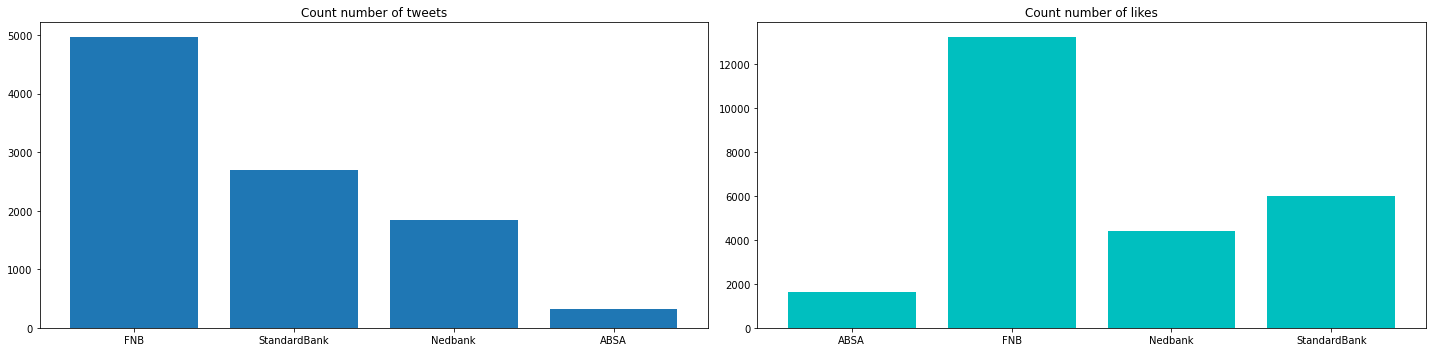

In [295]:
fig, ax = plt.subplots(1,2, figsize= (20,5))

ax[0].bar(base_tweets["Bank"].value_counts().index, base_tweets["Bank"].value_counts() )
ax[0].set_title("Count number of tweets")

#get number of likes
nlikes = base_tweets[["Bank","nlikes"]].groupby("Bank").sum()
ax[1].bar(nlikes.index, nlikes["nlikes"], color = "c")
ax[1].set_title("Count number of likes")

plt.tight_layout()
plt.show()

### Cleaning tweet data 


In [197]:
def link_at_s_removal(text):  
    pat1 = r'@_?[A-Za-z0-9]+'  # @[A-Za-z0-9]+
    pat2 = r'https?://[A-Za-z0-9./]+'  
    pat3 = r'\'s'                      #floating s's
    pat4 = r'\#\w+'
    combined_pat = r'|'.join((pat1, pat2,pat3,pat4))
    text = re.sub(combined_pat,"",text)
    return text

def clean_text(text): 
    text=link_at_s_removal(text)
    
    text = re.sub('[^A-Za-z\s]', '', text.lower())        #remove non-alphabet
    tokenized_text = WordPunctTokenizer().tokenize(text) #tokenize
    clean_text = [
         word for word in tokenized_text
         if word not in STOPWORDS
    ]
    return ' '.join(clean_text)

#### run tween cleaner

In [198]:
cleaned_list = []

for t in base_tweets["tweet"]:
    cleaned_list.append(clean_text(t))

In [199]:
##make a dataframe for sentiment analysis
clean_df = pd.DataFrame(cleaned_list,columns=['tweet'])

In [200]:
#drop empty tweet
clean_df = clean_df [ ~(clean_df["tweet"] =="")]

In [201]:
clean_df.head()

,tweet
0,fnb easy account way convenient send receive m...
1,fees starting go swana letsa much now july august
2,fnb easy zero makes life much convenient
3,final game opening round expect fireworks defe...
4,happening now opening game campaign takes tuks...


## Sentiment analysis 

In [202]:
for index, row in clean_df.iterrows():
    tweet = clean_df.at[index, 'tweet']

    #run sentiment using TextBlob
    analysis = TextBlob(tweet)

    #set value to dataframe
    clean_df.at[index, 'polarity'] = analysis.sentiment[0]
    clean_df.at[index, 'subjectivity'] = analysis.sentiment[1]

    #Create Positive / negative column depending on polariity
    if analysis.sentiment[0]>0:

        clean_df.at[index, 'Sentiment'] = "Positive"
        #printmd('Positive', color="green")

    elif analysis.sentiment[0]<0:

        clean_df.at[index, 'Sentiment'] = "Negative"
    else:

        clean_df.at[index, 'Sentiment'] = "Neutral"

In [203]:
clean_df.to_csv("cleaned.csv")
clean_df.head()

,tweet,polarity,subjectivity,Sentiment
0,fnb easy account way convenient send receive m...,0.283333,0.575000,Positive
1,fees starting go swana letsa much now july august,0.100000,0.150000,Positive
2,fnb easy zero makes life much convenient,0.316667,0.516667,Positive
3,final game opening round expect fireworks defe...,0.067273,0.660000,Positive
4,happening now opening game campaign takes tuks...,-0.131818,0.450000,Negative


## Merge cleaned and original 

In [338]:
Final_df = pd.merge(clean_df, base_tweets, left_index=True, right_index=True)

In [339]:
Final_df = Final_df.rename(columns={"tweet_x": "cleaned_tweet", "tweet_y": "Base_tweet"})
Final_df.head(2)

,cleaned_tweet,polarity,subjectivity,Sentiment,date,username,Base_tweet,language,hashtags,retweet_id,reply_to,nlikes,search,Bank
0,fnb easy account way convenient send receive m...,0.283333,0.575,Positive,2021-09-08 18:14:10,AnushaGovende13,@FNBSA FNB Easy Account is way convenient for ...,en,[],NaN,"[{'screen_name': 'FNBSA', 'name': 'FNB South A...",0,FNBSA,FNB
1,fees starting go swana letsa much now july august,0.100000,0.150,Positive,2021-09-08 18:11:47,Iam_Timbanesam,@CapitecBankSA Fees are starting go swana lets...,en,[],NaN,[],1,FNBSA,FNB


## Create rolling Mean / Expanding 

In [340]:
Final_df["date"] = pd.to_datetime(Final_df["date"])

#set index = date so as to create rolling mean 
Final_df = Final_df.sort_values('date').set_index('date')

In [341]:
#Create bank Dataframes 
Standard_df = Final_df[(Final_df.Bank=="StandardBank")]
FNB_df = Final_df[(Final_df.Bank=="FNB")]
Nedbank_df = Final_df[(Final_df.Bank=="Nedbank")]
ABSA_df = Final_df[(Final_df.Bank=="ABSA")]

#### Get rolling/ expanding mean 

In [342]:
# stop this warning as the chaining is fine
pd.options.mode.chained_assignment = None 

#Total
Final_df['mean'] = Final_df['polarity'].expanding().mean()
Final_df['rolling'] = Final_df['polarity'].rolling("1d").mean()

#Std Bank
Standard_df['mean'] = Standard_df['polarity'].expanding().mean()
Standard_df['rolling'] = Standard_df['polarity'].rolling("1d").mean()

#FNB
FNB_df['mean'] = FNB_df['polarity'].expanding().mean()
FNB_df['rolling'] = FNB_df['polarity'].rolling("1d").mean()

#Nebank
Nedbank_df['mean'] = Nedbank_df['polarity'].expanding().mean()
Nedbank_df['rolling'] = Nedbank_df['polarity'].rolling("1d").mean()

#ABSA
ABSA_df['mean'] = ABSA_df['polarity'].expanding().mean()
ABSA_df['rolling'] = ABSA_df['polarity'].rolling("1d").mean()

## Analysis and visualisation

In [343]:
# number of tweets
Final_df[["cleaned_tweet","Bank"]].groupby(["Bank"]).count().transpose()

Bank,ABSA,FNB,Nedbank,StandardBank
cleaned_tweet,321,3527,1795,2519


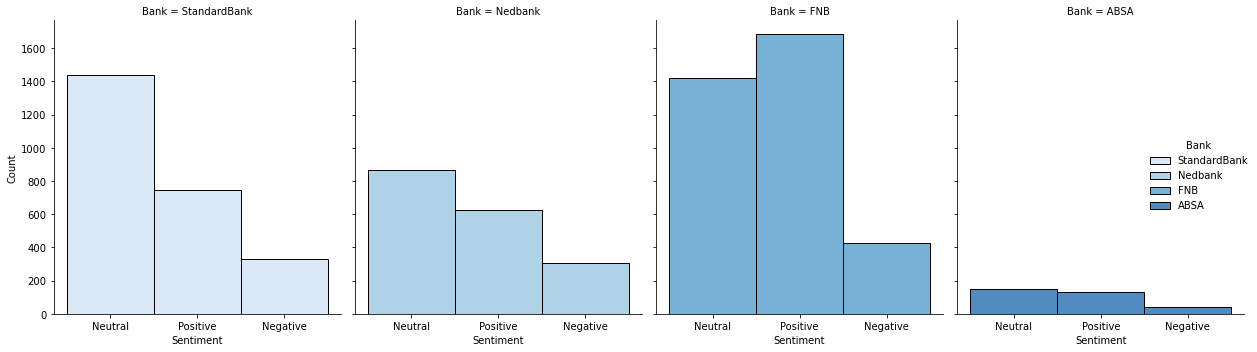

In [344]:
sns.displot(
    Final_df, x="Sentiment", col="Bank",
    binwidth=3 , hue="Bank",palette="Blues", aspect=0.8)
plt.tight_layout()

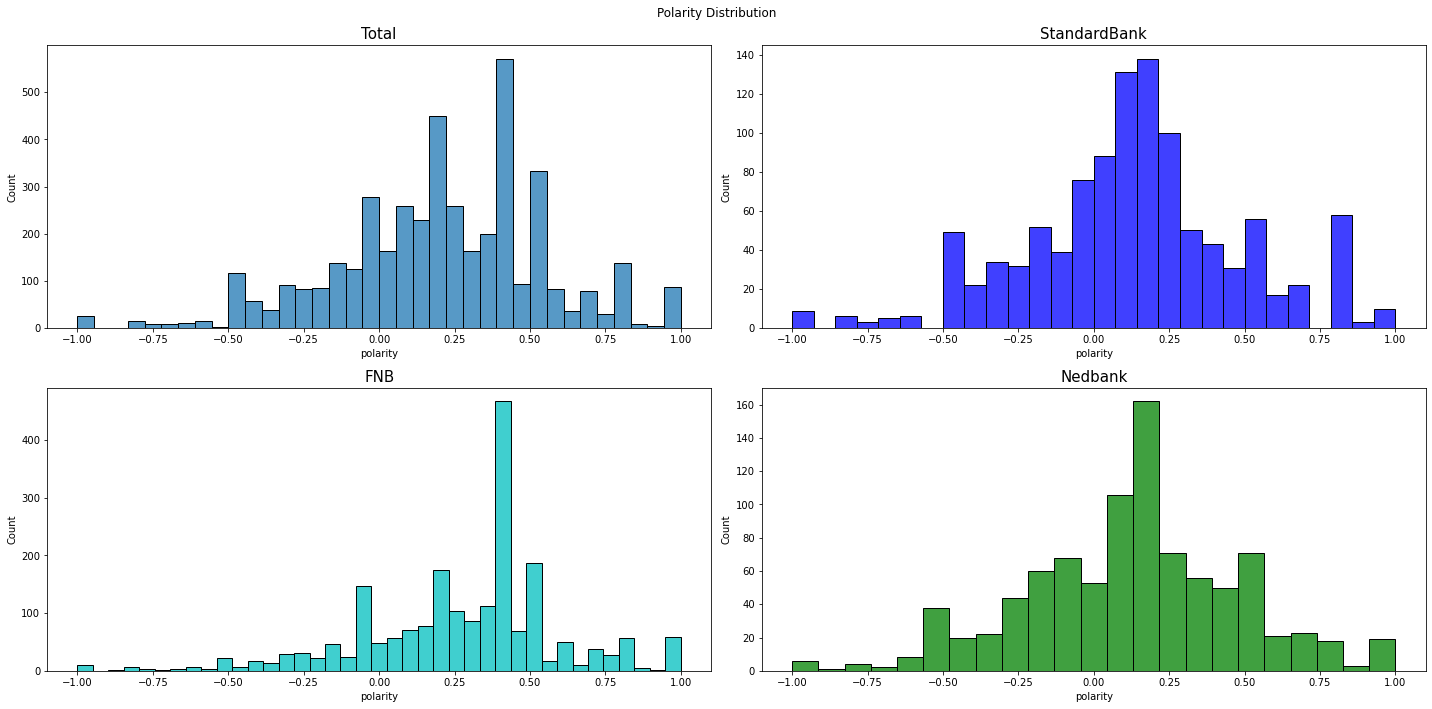

In [345]:
fig, axes = plt.subplots(2, 2,figsize=(20, 10))
fig.suptitle('Polarity Distribution')

#NB - remove the neutral values 
# total
sns.histplot(ax=axes[0,0], data = Final_df['polarity'][~(Final_df['polarity']==0)])
axes[0,0].set_title("Total", fontsize = 15)

#StandardBank
sns.histplot(ax=axes[0,1], data= Standard_df['polarity'][~(Standard_df['polarity']==0)], color="b")
axes[0,1].set_title("StandardBank", fontsize = 15)


# FNB
sns.histplot(ax=axes[1,0], data = FNB_df['polarity'][~(FNB_df['polarity']==0)], color="c")
axes[1,0].set_title("FNB", fontsize = 15)

# Nedbank
sns.histplot(ax=axes[1,1], data = Nedbank_df['polarity'][~(Nedbank_df['polarity']==0)], color="g")
axes[1,1].set_title("Nedbank", fontsize = 15)

plt.tight_layout()
plt.show()

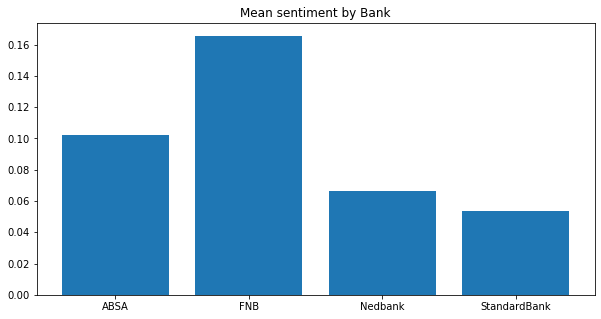

In [346]:
# Overall mean sentiment by bank
plt.figure( figsize= (10,5))
plt.bar(Final_df[["polarity","Bank"]].groupby(["Bank"]).mean().index, Final_df[["polarity","Bank"]].groupby(["Bank"]).mean()["polarity"]
       )
plt.title("Mean sentiment by Bank")
plt.show()

# Hashtag analysis 

In [347]:
#### Top 5 hastags 

In [348]:
import ast
from collections import Counter

#get all hashtags as list
def hashlist(df):
    hashlist = []
    for i in df['hashtags']:
        #ast.literal is to consider string list as a string
        hashlist.extend(ast.literal_eval(i))
    return hashlist

#Create 5 most common Hashtag values
def Create_values(hashlist):
    labels, values = zip(*Counter(hashlist).most_common(5))
    indexes = np.arange(len(labels))
    return labels,indexes,values

t_labels,t_indexes,t_values = Create_values(hashlist(Final_df))
s_labels,s_indexes,s_values = Create_values(hashlist(Standard_df))
f_labels,f_indexes,f_values = Create_values(hashlist(FNB_df))
n_labels,n_indexes,n_values = Create_values(hashlist(Nedbank_df))
a_labels,a_indexes,a_values = Create_values(hashlist(ABSA_df))

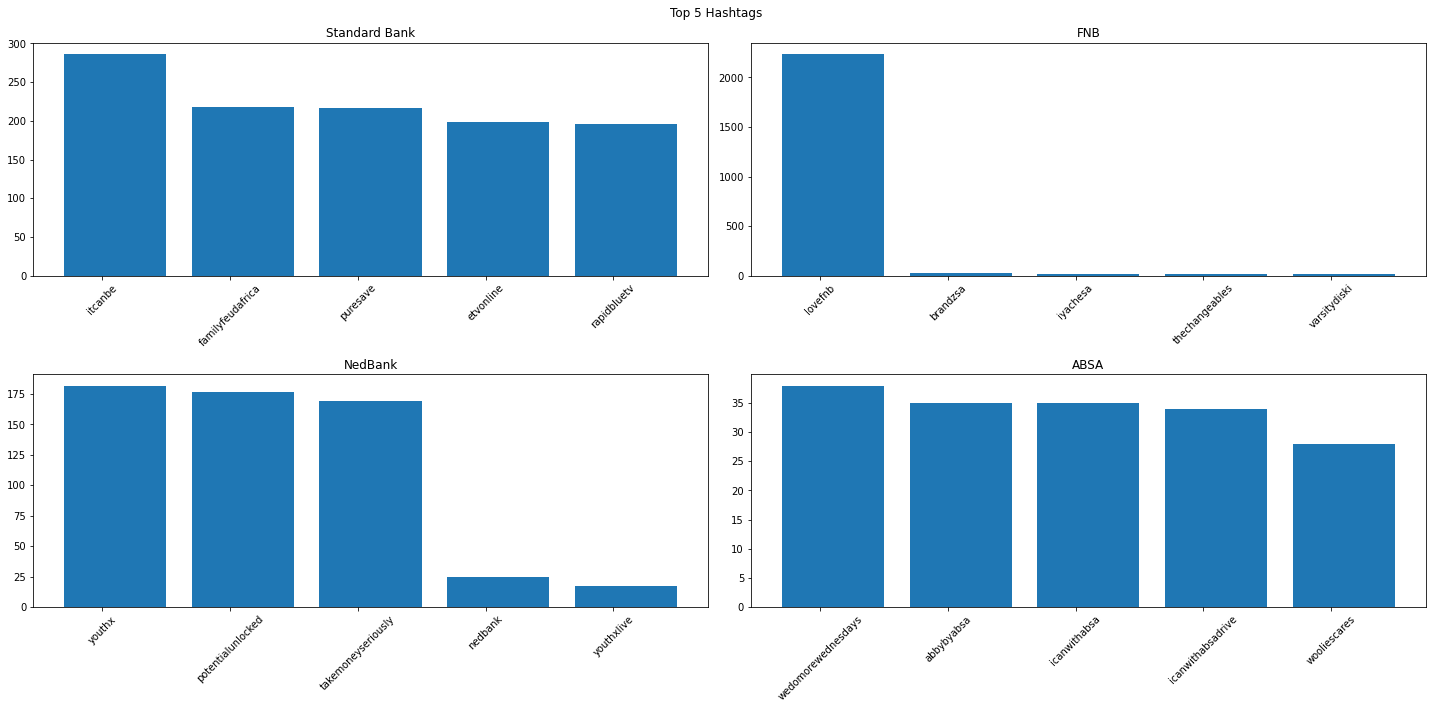

In [349]:
#plot graphs
fig, axes = plt.subplots(2, 2,figsize=(20, 10))

fig.suptitle("Top 5 Hashtags")

axes[0,0].set_title("Standard Bank")
axes[0,0].bar(s_indexes, s_values )
axes[0,0].set_xticks(np.arange(len(s_labels))-0.1)
axes[0,0].set_xticklabels(s_labels, rotation= 45)

axes[0,1].set_title("FNB")
axes[0,1].bar(f_indexes, f_values )
axes[0,1].set_xticks(np.arange(len(f_labels))-0.1)
axes[0,1].set_xticklabels(f_labels, rotation= 45)

axes[1,0].set_title("NedBank")
axes[1,0].bar(n_indexes, n_values )
axes[1,0].set_xticks(np.arange(len(n_labels))-0.1)
axes[1,0].set_xticklabels(n_labels, rotation= 45)

axes[1,1].set_title("ABSA")
axes[1,1].bar(a_indexes, a_values )
axes[1,1].set_xticks(np.arange(len(a_labels))-0.1)
axes[1,1].set_xticklabels(a_labels, rotation= 45)

plt.tight_layout()
plt.show()

# Word Cloud

In [350]:
tweetString_s = " ".join(list(Standard_df["cleaned_tweet"])).lower()
tweetString_f = " ".join(list(FNB_df["cleaned_tweet"])).lower()
tweetString_n = " ".join(list(Nedbank_df["cleaned_tweet"])).lower()
tweetString_a = " ".join(list(ABSA_df["cleaned_tweet"])).lower()

#remove bank name and set wordcloud
tweetString_s = re.sub(r"standardbankza|standard bank|bank","",tweetString_s)     
wordcloud_s = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 5).generate(tweetString_s)

tweetString_f = re.sub(r"FNB|fnb|bank","",tweetString_f)
wordcloud_f = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 5).generate(tweetString_f)

tweetString_n = re.sub(r"NedBankSA|Nedbank|nedbank|bank","",tweetString_n)   
wordcloud_n = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 5).generate(tweetString_n)

tweetString_a = re.sub(r"fnb|FNB|bank","",tweetString_a)
wordcloud_a = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 5).generate(tweetString_a)

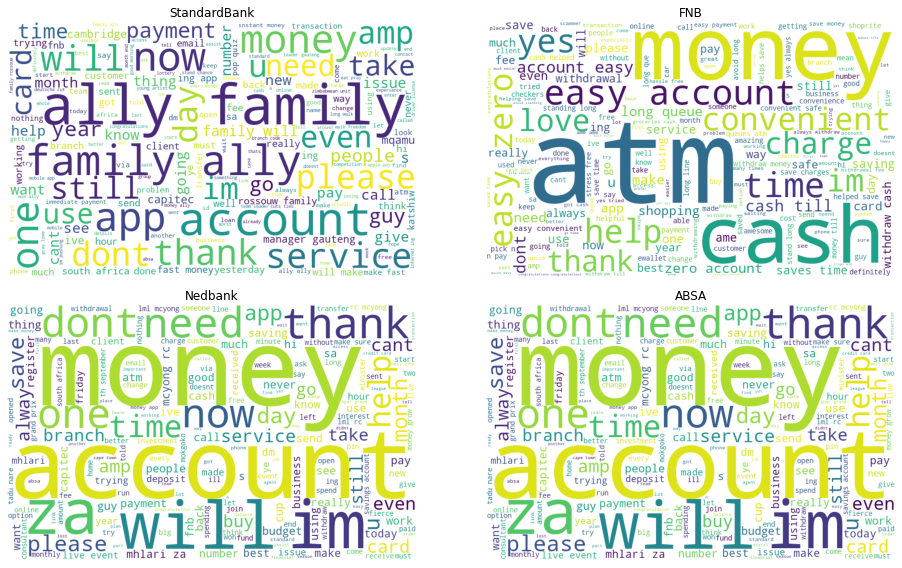

In [351]:
fig, ax = plt.subplots(2,2,figsize=(14, 8),sharey=True)

ax[0,0].imshow(wordcloud_s)
ax[0,1].imshow(wordcloud_f)
ax[1,0].imshow(wordcloud_n)
ax[1,1].imshow(wordcloud_n)

ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,0].axis("off")
ax[1,1].axis("off")

ax[0,0].set_title("StandardBank")
ax[0,1].set_title("FNB")
ax[1,0].set_title("Nedbank")
ax[1,1].set_title("ABSA")

plt.tight_layout() 
plt.show()

# Rolling plots

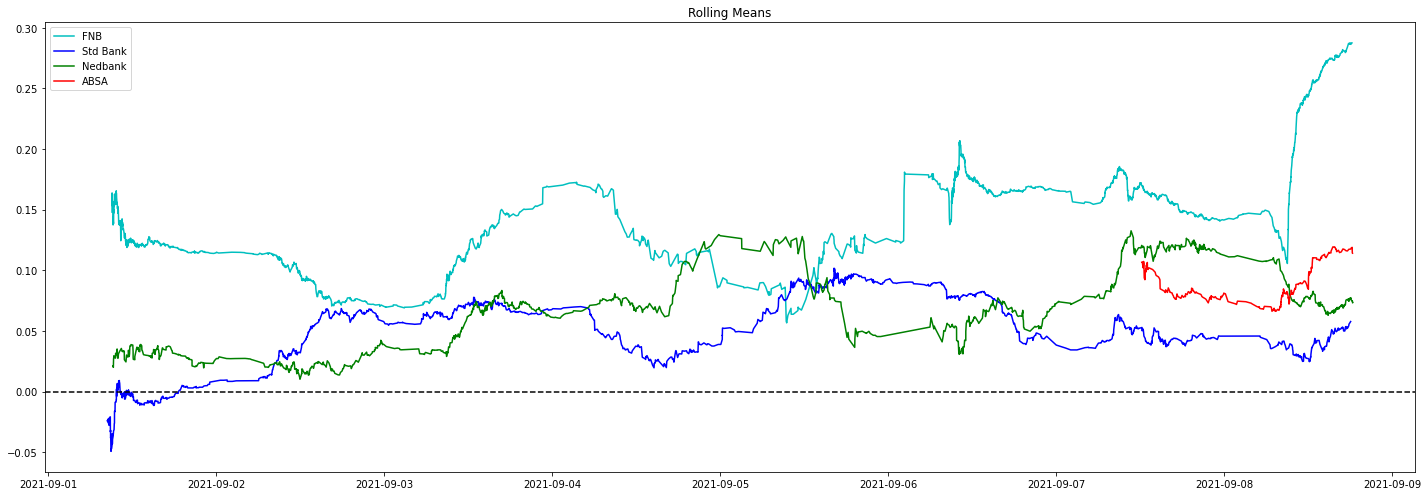

In [400]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

#ax.plot(Final_df.iloc[50:].index,Final_df['rolling'].iloc[50:], color='y', label='Total rolling mean')
ax.plot(FNB_df.iloc[50:].index,FNB_df.iloc[50:]['rolling'], color ='c', label='FNB')
ax.plot(Standard_df.iloc[50:].index,Standard_df.iloc[50:]['rolling'], color ='b', label='Std Bank')
ax.plot(Nedbank_df.iloc[50:].index,Nedbank_df.iloc[50:]['rolling'], color ='g', label='Nedbank')
ax.plot(ABSA_df.iloc[50:].index,ABSA_df.iloc[50:]['rolling'], color ='r', label='ABSA')
plt.axhline(y = 0, color = 'k', linestyle = 'dashed')
plt.legend()
plt.title("Rolling Means")
plt.tight_layout()
plt.show()

### Day / Month sentiment comparison 

In [409]:
Standard_df["Day"]= Standard_df.index.day_name()
Standard_df["Month"] = Standard_df.index.month_name()
ABSA_df["Day"]= ABSA_df.index.day_name()
ABSA_df["Month"] = ABSA_df.index.month_name()
FNB_df["Day"]= FNB_df.index.day_name()
FNB_df["Month"] = FNB_df.index.month_name()
Nedbank_df["Day"]= Nedbank_df.index.day_name()
Nedbank_df["Month"] = Nedbank_df.index.month_name()

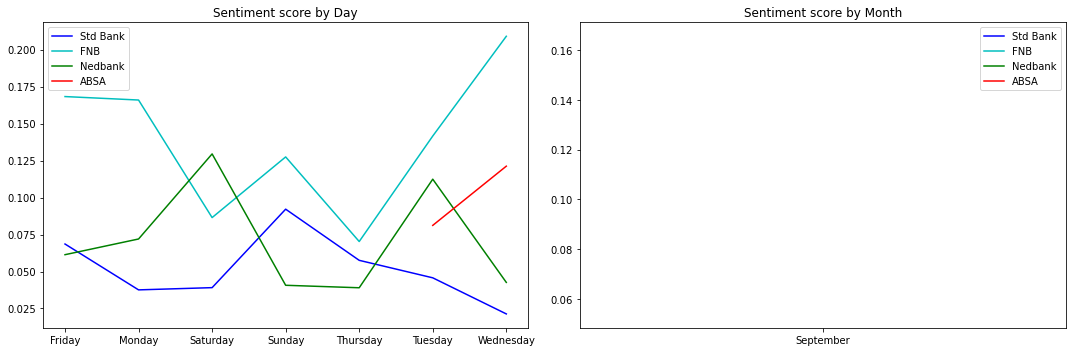

In [438]:
# Polarity by Day/Month 

fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].set_title("Sentiment score by Day")
ax[0].plot(Standard_df.groupby("Day")["polarity"].mean().index,Standard_df.groupby("Day")["polarity"].mean(), color ='b', label='Std Bank' )
ax[0].plot(FNB_df.groupby("Day")["polarity"].mean().index,FNB_df.groupby("Day")["polarity"].mean(), color ='c', label='FNB')
ax[0].plot(Nedbank_df.groupby("Day")["polarity"].mean().index,Nedbank_df.groupby("Day")["polarity"].mean(), color ='g', label='Nedbank' )
ax[0].plot(ABSA_df.groupby("Day")["polarity"].mean().index,ABSA_df.groupby("Day")["polarity"].mean(), color ='r', label='ABSA' )
ax[0].legend()

ax[1].set_title("Sentiment score by Month")
ax[1].plot(Standard_df.groupby("Month")["polarity"].mean().index,Standard_df.groupby("Month")["polarity"].mean(), color ='b', label='Std Bank' )
ax[1].plot(FNB_df.groupby("Month")["polarity"].mean().index,FNB_df.groupby("Month")["polarity"].mean(), color ='c', label='FNB')
ax[1].plot(Nedbank_df.groupby("Month")["polarity"].mean().index,Nedbank_df.groupby("Month")["polarity"].mean(), color ='g', label='Nedbank' )
ax[1].plot(ABSA_df.groupby("Month")["polarity"].mean().index,ABSA_df.groupby("Month")["polarity"].mean(), color ='r', label='ABSA' )
ax[1].legend()

plt.tight_layout()
plt.show()

In [503]:
def create_day_plot(df,ax,colour,lab):
    df["Day"] = df.index.day_name()
    x = df.groupby("Day")["polarity"].mean().index
    y = df.groupby("Day")["polarity"].mean()
    
    return ax.plot(x,y, color =colour , label = lab)

def create_month_plot(df,ax,colour,lab):
    df["Month"] = df.index.month_name()
    x = df.groupby("Month")["polarity"].mean().index
    y = df.groupby("Month")["polarity"].mean()
    
    return ax.plot(x,y, color =colour , label = lab)

def create_hr_plot(df,ax,colour,lab):
    df["Hour"] = df.index.hour
    x = df.groupby("Hour")["polarity"].mean().index
    y = df.groupby("Hour")["polarity"].mean()

    return ax.plot(x,y, color =colour , label = lab)

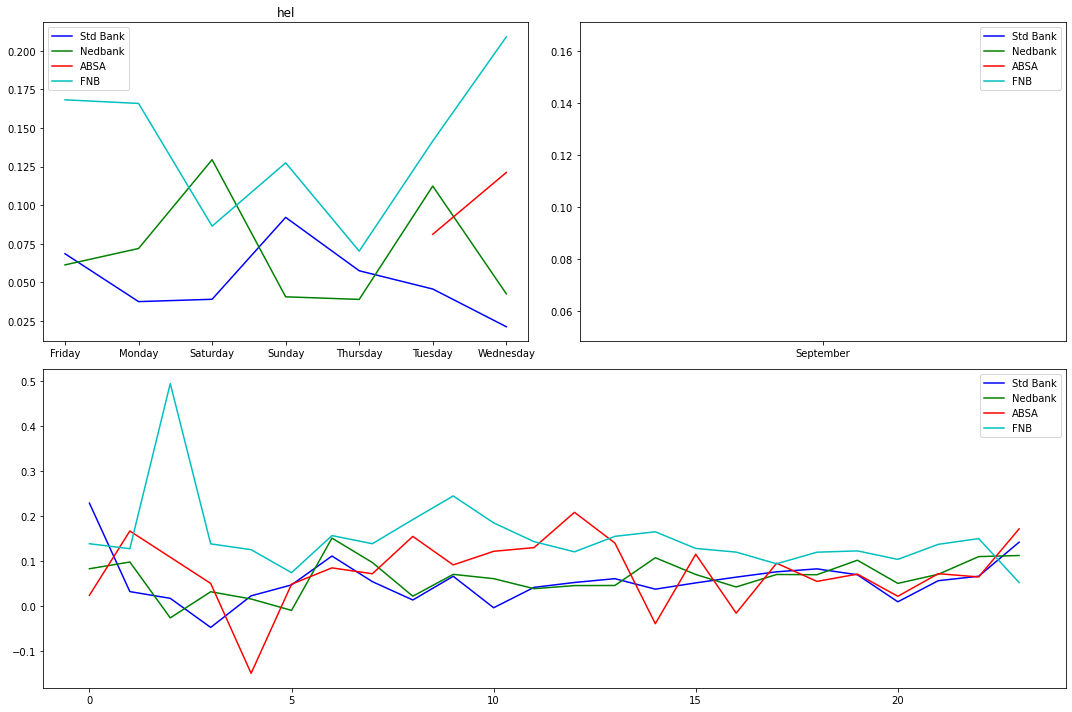

In [507]:
fig= plt.figure(figsize = (15,10))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

create_day_plot(Standard_df,ax1, "b","Std Bank" )
create_day_plot(Nedbank_df,ax1, "g","Nedbank" )
create_day_plot(ABSA_df,ax1, "r","ABSA" )
create_day_plot(FNB_df,ax1, "c","FNB" )
ax1.legend()
ax1.set_title("Sentiment by Day of the week")

create_month_plot(Standard_df,ax2, "b","Std Bank" )
create_month_plot(Nedbank_df,ax2, "g","Nedbank" )
create_month_plot(ABSA_df,ax2, "r","ABSA" )
create_month_plot(FNB_df,ax2, "c","FNB" )
ax2.legend()
ax2.set_title("Setiment by Month")

create_hr_plot(Standard_df,ax3, "b","Std Bank" )
create_hr_plot(Nedbank_df,ax3, "g","Nedbank" )
create_hr_plot(ABSA_df,ax3, "r","ABSA" )
create_hr_plot(FNB_df,ax3, "c","FNB" )
ax3.legend()
ax3.set_title("Setiment by Month")

plt.tight_layout()

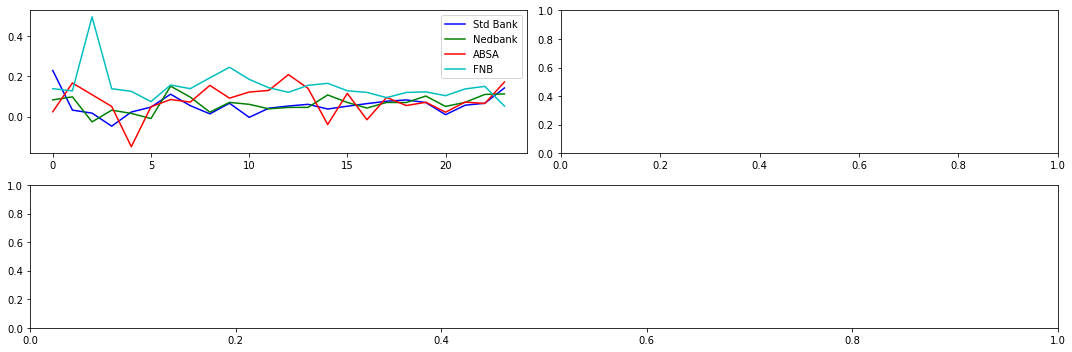

In [502]:

fig = plt.figure(figsize = (15,5))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

create_hr_plot(Standard_df,ax1, "b","Std Bank" )
create_hr_plot(Nedbank_df,ax1, "g","Nedbank" )
create_hr_plot(ABSA_df,ax1, "r","ABSA" )
create_hr_plot(FNB_df,ax1, "c","FNB" )
ax1.legend()

plt.tight_layout()


## Project 2: 
do outages affect sentiment 
get outages overlap to rolling mean

In [488]:
check = create_hr_plot(Standard_df,3, "b","Std Bank" )

AttributeError: 'int' object has no attribute 'plot'